# **The Influence of Class Imbalance on Classification Task**

**Group members**:


1.   Gasbarri Francesca (1900644) gasbarri.1900644@studenti.uniroma1.it
2.   Zauner Angelica (1883247) zauner.1883247@studenti.uniroma1.it
3.   Lattanzio Federico (1886519) lattanzio.1886519@studenti.uniroma1.it

## **Import**

In [437]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from functions.pipeline import kfold
from functions.plots import plot_metrics
from functions.plots import plot_pie
warnings.simplefilter(action='ignore')

In [396]:
df = pd.read_csv("SDSS_DR18.csv")
df = df.drop(columns=['objid', 'specobjid', 'run', 'rerun', 'camcol' ,'field', 'plate', 'mjd', 'fiberid'])

## **Datasets and Pre-Processing**

**Original Dataset**:

In [397]:
df1 = df.copy()

# Encode classes
encoding = {'GALAXY': 0, 'STAR': 1, 'QSO': 2}
df1['class'] = df1['class'].map(encoding)

# Separate features and labels
features = df1.drop(columns=['class'])
y = df1['class']

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Split in train and test set
X = pd.DataFrame(scaled_features, columns=features.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Galaxy** and **Quasar**:

In [2]:
df2 = df.copy()
df2 = df2[df2['class'] != 'STAR']

# Encode classes
encoding2 = {'GALAXY': 0, 'QSO': 1}
df2['class'] = df2['class'].map(encoding2)

# Separate features and labels
features2 = df2.drop(columns=['class'])
y2 = df2['class']

# Scale the features
scaler = StandardScaler()
scaled_features2 = scaler.fit_transform(features2)

# Split in train and test set
X2 = pd.DataFrame(scaled_features2, columns=features2.columns)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

**Star** and **Quasar**:

In [3]:
df3 = df.copy()
df3 = df3[df3['class'] != 'GALAXY']

# Encode classes
encoding3 = {'STAR': 0, 'QSO': 1}
df3['class'] = df3['class'].map(encoding3)

# Separate features and labels
features3 = df3.drop(columns=['class'])
y3 = df3['class']

# Scale the features
scaler = StandardScaler()
scaled_features3 = scaler.fit_transform(features3)

# Split in train and test set
X3 = pd.DataFrame(scaled_features3, columns=features3.columns)
X3_train, X3_test, y3_train, y3_test= train_test_split(X3, y3, test_size=0.2, random_state=42)

**Galaxy** and **Star**:

In [366]:
df4 = df.copy()
df4 = df4[df4['class'] != 'QSO']

# Encode classes
encoding4 = {'GALAXY': 0, 'STAR': 1}
df4['class'] = df4['class'].map(encoding4)

# Split features and target
features4 = df4.drop(columns=['class'])
y4 = df4['class']

# Normalize features
scaler = StandardScaler()
scaled_features4 = scaler.fit_transform(features4)

# Split in training and test sets
X4 = pd.DataFrame(scaled_features4, columns=features4.columns)
X4_train, X4_test, y4_train, y4_test= train_test_split(features4, y4, test_size=0.2, random_state=42)

## **EDA**

Plotting the **distribution of the classes** for each dataset:

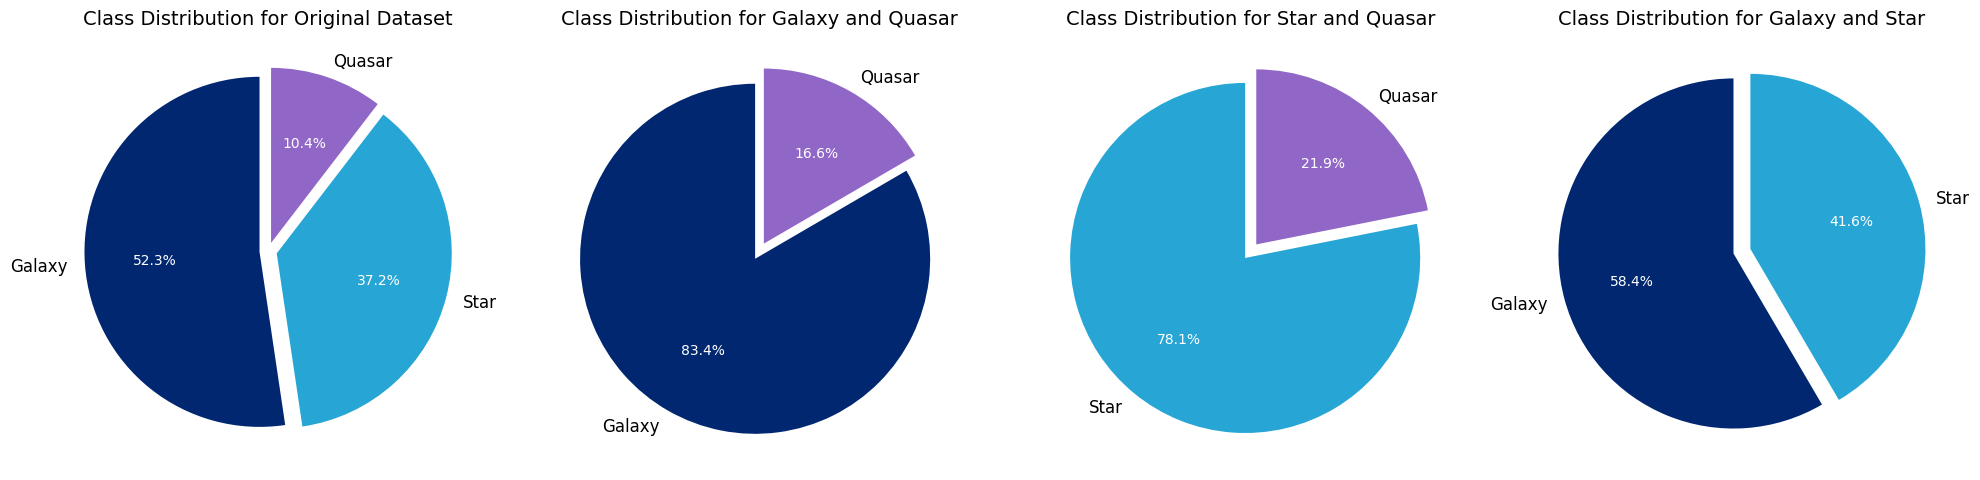

In [ ]:
# Data for each pie chart
data = [(y.value_counts(), ['Galaxy', 'Star', 'Quasar'], ['#002770', '#27A6D5', '#9067C6'], 'Class Distribution for Original Dataset'),
        (y2.value_counts(), ['Galaxy', 'Quasar'], ['#002770', '#9067C6'], 'Class Distribution for Galaxy and Quasar'),
        (y3.value_counts(), ['Star', 'Quasar'], ['#27A6D5', '#9067C6'], 'Class Distribution for Star and Quasar'),
        (y4.value_counts(), ['Galaxy', 'Star'], ['#002770', '#27A6D5'], 'Class Distribution for Galaxy and Star')]

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

# Plot each pie chart
for ax, (class_counts, labels, colors, title) in zip(axes, data):
    explode = [0.05] * len(class_counts)  # Slightly "explode" all slices
    plot_pie(ax, class_counts, labels, colors, explode, title)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

Plotting the **mean values of each feature for each class**:

<Figure size 4000x600 with 0 Axes>

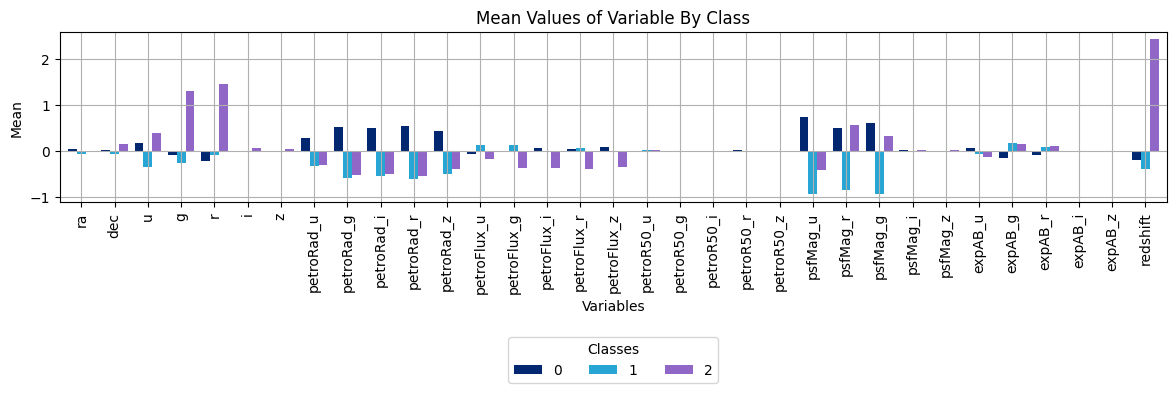

In [ ]:
X['class'] = df1['class']
grouped_stats = X.groupby('class').mean()
transposed_grouped_stats = grouped_stats.T

palette = {0:'#002770', 1:'#27A6D5', 2:'#9067C6'}

plt.figure(figsize=(40, 6))

ax = transposed_grouped_stats.plot(kind='bar', figsize=(12, 6), width=0.8, color=palette)

plt.xlabel('Variables')
plt.ylabel('Mean')
plt.xticks(rotation=90, ha='center')
plt.legend(title='Classes', loc='upper center', bbox_to_anchor=(0.5, -0.75), ncol=len(transposed_grouped_stats.columns))
plt.grid(True)
plt.tight_layout()
plt.title("Mean Values of Variable By Class")
plt.show()

Plotting the **correlation matrix** and the **most significant features correlation**:

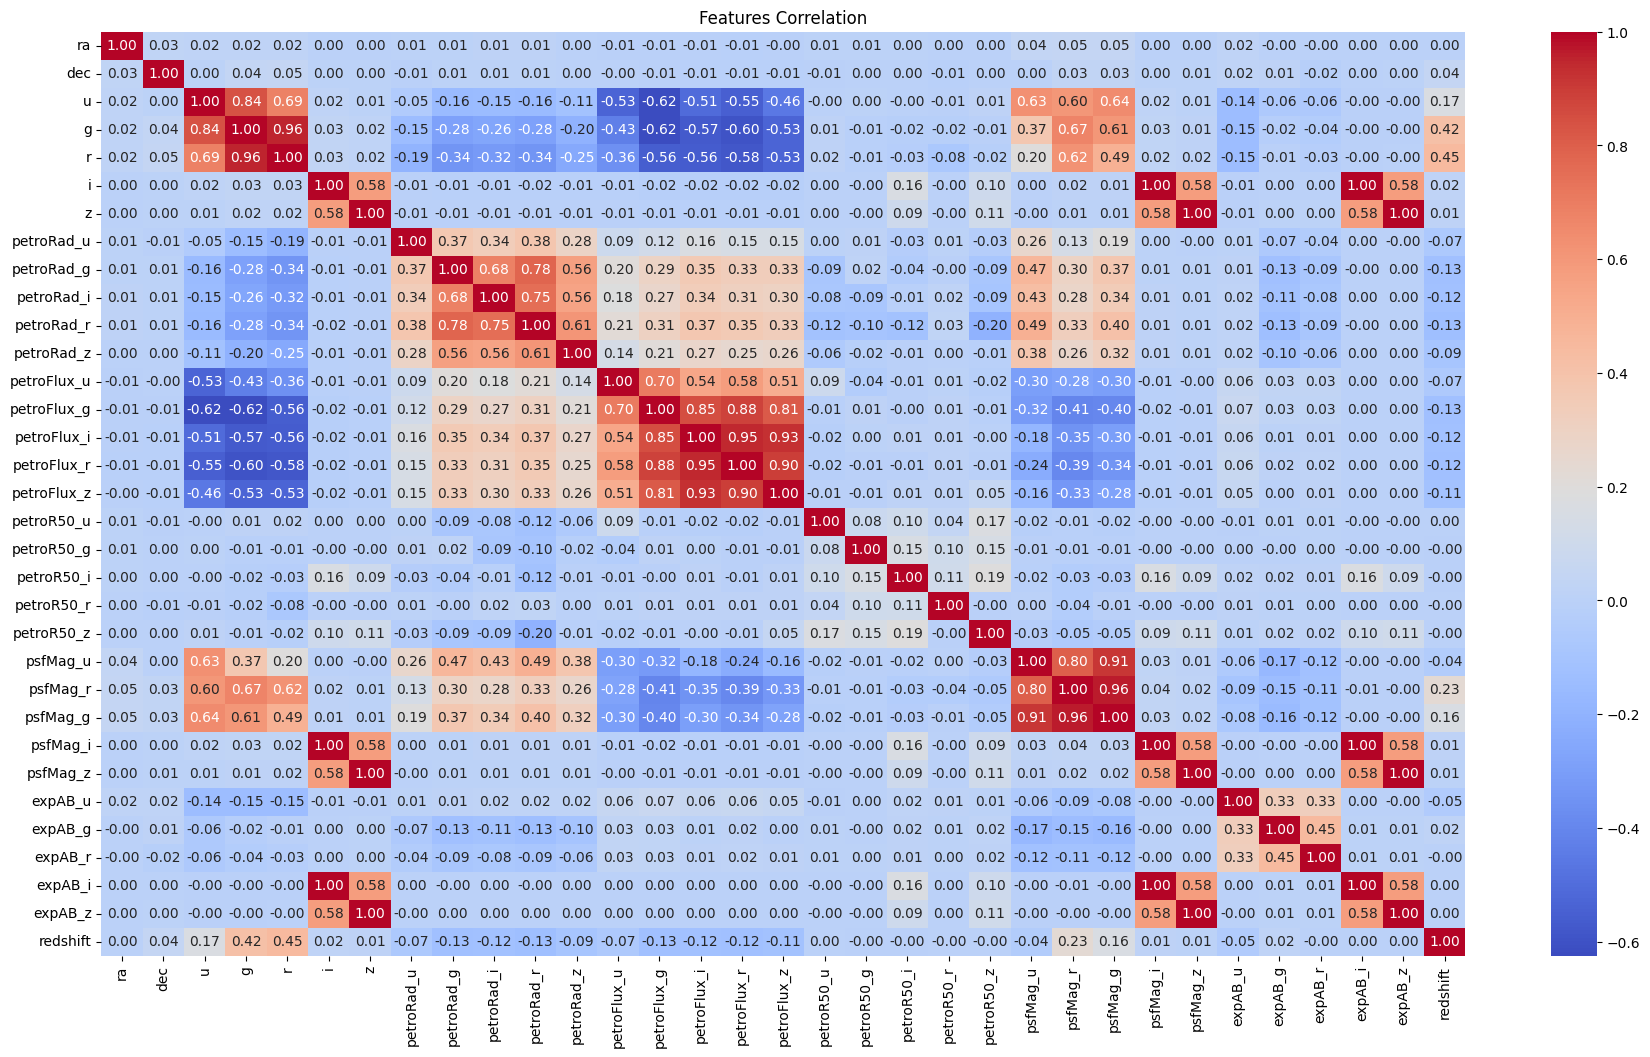

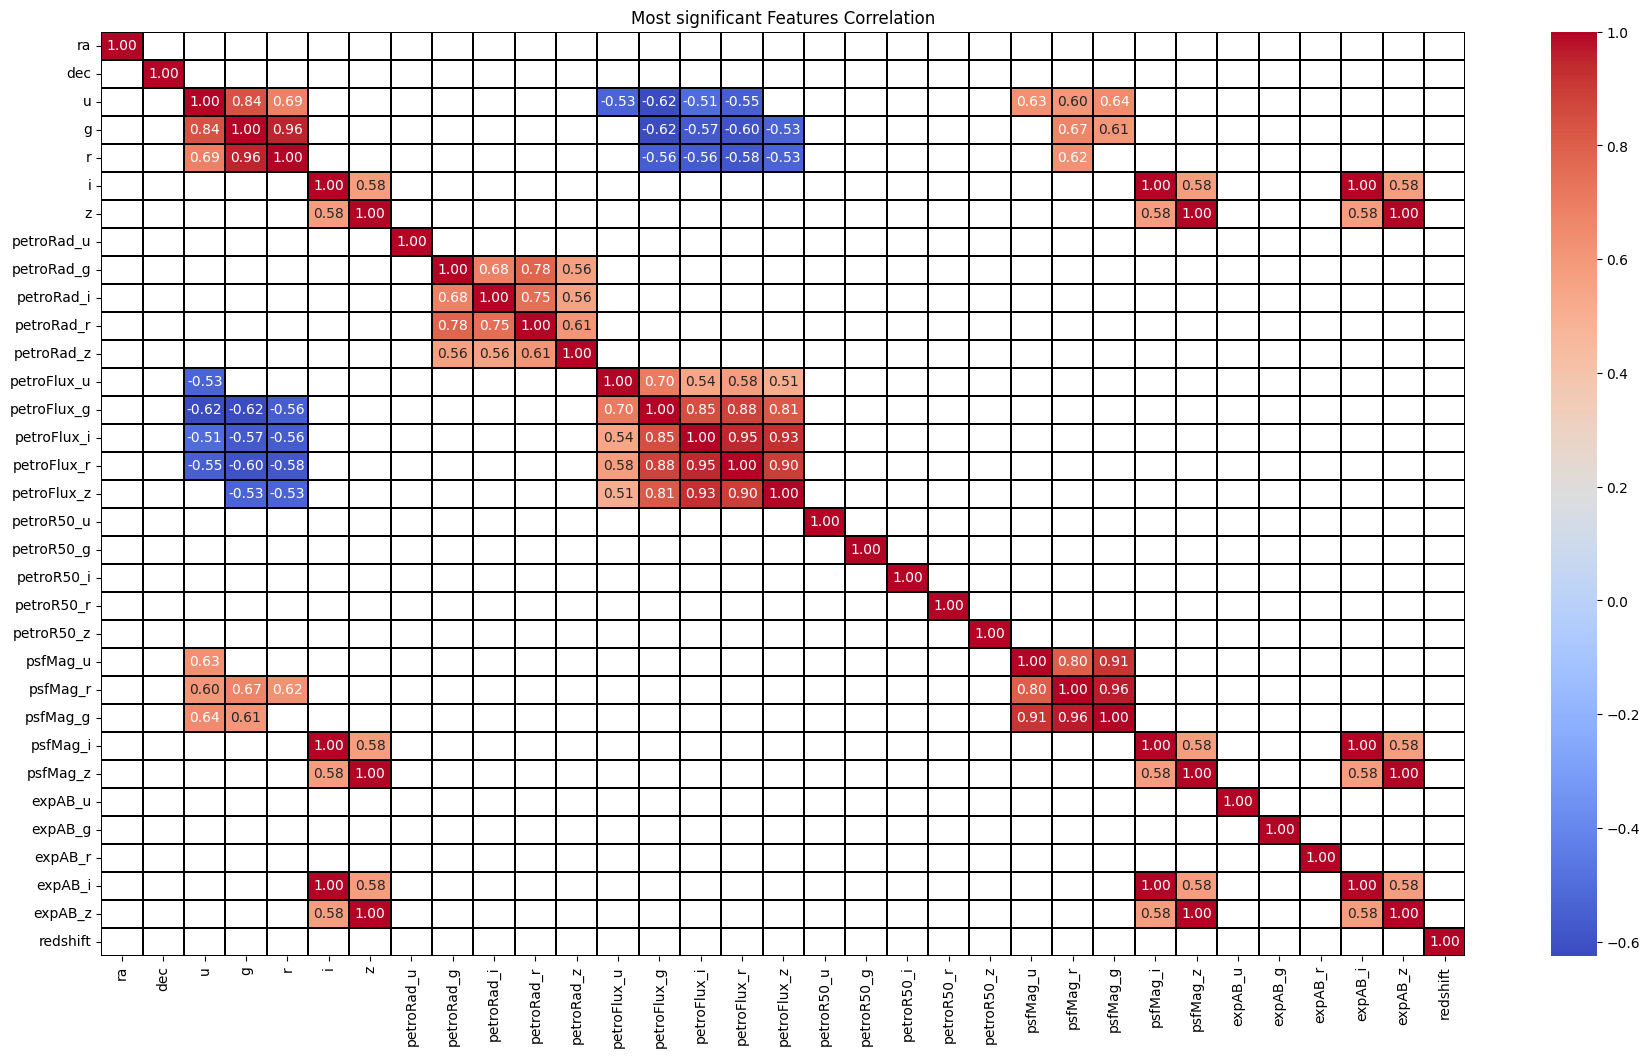

In [438]:
correlation_matrix = pd.DataFrame(X, columns=features.columns).corr()

# General features correlation
plt.figure(figsize=(22, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Features Correlation')
plt.show()

# Most significant features correlation (ranges [-1, -0.5] and [0.5, 1], ignoring the  range [-0.5, 0.5])
plt.figure(figsize=(22, 12))
sns.heatmap(correlation_matrix[(correlation_matrix >= 0.5) | (correlation_matrix <= -0.5)], annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.1, linecolor='black')
plt.title('Most significant Features Correlation')
plt.show()

Plotting the **distributions of some highly correlated features for each class**: 

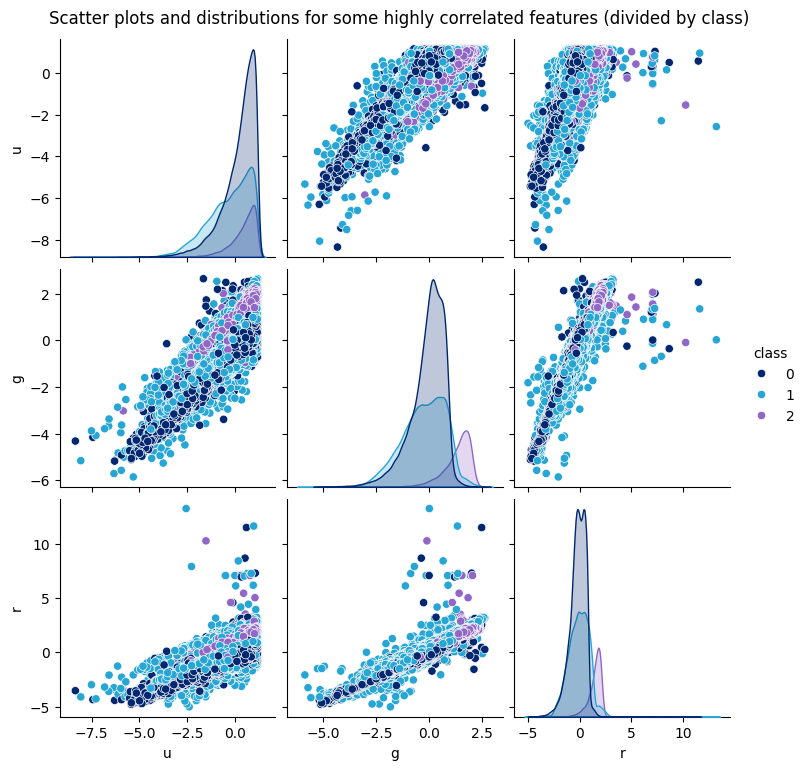

In [439]:
pairplot = sns.pairplot(X, vars=['u', 'g', 'r'], hue='class', palette=palette)
pairplot.fig.suptitle("Scatter plots and distributions for some highly correlated features (divided by class)", y=1.02)
plt.show()

Plotting the **spatial distributions of celestial objects**: 

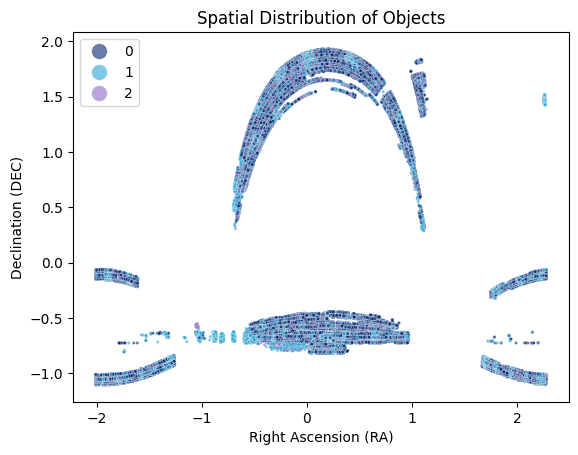

In [ ]:
sns.scatterplot(data=X, x='ra', y='dec', hue='class', palette=palette, s=5, alpha=0.6)

# Xoordinates used in astronomy to specify the position of an object in the sky
plt.xlabel('Right Ascension (RA)')
plt.ylabel('Declination (DEC)')
plt.title('Spatial Distribution of Objects')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, markerscale=5, loc='upper left')

plt.show()

## **Models and Balancing Methods**

In [7]:
# Classification models
models = {"LogisticRegression": LogisticRegression(solver='lbfgs', random_state=42, max_iter=2000),
        "LogisticRegressionBalanced": LogisticRegression(solver='lbfgs', random_state=42, class_weight='balanced', max_iter=2000),
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "RandomForestBalanced": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "KNNBalanced": KNeighborsClassifier(n_neighbors=5, weights='distance'),
        "NaiveBayes": GaussianNB(),
        "NaiveBayesBalanced": GaussianNB(priors=[0.1043, 0.3723, 0.5234]),
        "BinaryNaiveBayesBalanced2": GaussianNB(priors=[0.166, 0.834]),
        "BinaryNaiveBayesBalanced3": GaussianNB(priors=[0.219, 0.781]),
        "BinaryNaiveBayesBalanced4": GaussianNB(priors=[0.415, 0.585]),
        "XGBoost": XGBClassifier(objective='multi:softmax', num_class = 3, eval_metric = ['mlogloss', 'auc'], learning_rate = 0.1, max_depth = 6),
        "BinaryXGBoost": XGBClassifier(objective='binary:logistic', eval_metric = ['mlogloss', 'auc'], learning_rate = 0.1, max_depth = 6)}

# Balancing methods: 2 for oversampling, 2 for undersampling
balancing_methods = {"SMOTE": SMOTE(random_state=42),
                     "KMeansSMOTE": KMeansSMOTE(kmeans_estimator=MiniBatchKMeans(n_clusters= 15, n_init=1, random_state=0), random_state=42),
                     "RandomUnderSampler": RandomUnderSampler(random_state=42),
                     "ClusterCentroids": ClusterCentroids(random_state=42)}

In [400]:
# Color Map for the plots
color_map = colors = ["#2EB491", "#A1CE3F", "#002770", "#27A6D5", "#9067C6"]
color_map2 = colors = ["#2EB491", "#A1CE3F", "#002770", "#9067C6"]
color_map3 = colors = ["#2EB491", "#A1CE3F", "#27A6D5", "#9067C6"]
color_map4 = colors = ["#2EB491", "#A1CE3F", "#002770", "#27A6D5"]

## **Logistic Regression**

##### Logistic Regression for **original dataset**:

In [8]:
lr_fold = kfold('Logistic Regression', models['LogisticRegression'], "None", X, y)
lr_fold_internal = kfold('Logistic Regression', models['LogisticRegressionBalanced'], "Internal", X, y)
lr_fold_smote = kfold('Logistic Regression', models['LogisticRegression'], "SMOTE", X, y, balancing_methods['SMOTE'])
lr_fold_kmeanssmote = kfold('Logistic Regression', models['LogisticRegression'], "KMeans SMOTE", X, y, balancing_methods['KMeansSMOTE'])
lr_fold_rus = kfold('Logistic Regression', models['LogisticRegression'], "Random Under Sampler", X, y, balancing_methods['RandomUnderSampler'])
lr_fold_cc = kfold('Logistic Regression', models['LogisticRegression'], "Cluster Centroids", X, y, balancing_methods['ClusterCentroids'])
lr = pd.concat([lr_fold, lr_fold_internal, lr_fold_smote, lr_fold_kmeanssmote, lr_fold_rus, lr_fold_cc], ignore_index = True)
lr

Model             Balancing  Accuracy   ROC-AUC  \
0  Logistic Regression                  None   0.98934  0.995723   
1  Logistic Regression              Internal   0.98815  0.995819   
2  Logistic Regression                 SMOTE   0.98841  0.995921   
3  Logistic Regression          KMeans SMOTE   0.98913  0.995792   
4  Logistic Regression  Random Under Sampler   0.98733  0.995403   
5  Logistic Regression     Cluster Centroids   0.98720  0.995745   

   Precision Class 0  Precision Class 1  Precision Class 2  Recall Class 0  \
0           0.988907           0.992455           0.980116        0.991212   
1           0.992173           0.991632           0.956137        0.985633   
2           0.992309           0.991738           0.957518        0.986015   
3           0.988455           0.992243           0.981136        0.991231   
4           0.991631           0.990302           0.955735        0.984659   
5           0.992138           0.987971           0.960128        0.983723   

   Recall Class 1  Recall Class 2  F1 Class 0  F1 Class 1  F1 Class 2  
0        0.996213        0.955396    0.990058    0.994330    0.967594  
1        0.996159        0.972182    0.988892    0.993890    0.964089  
2        0.996132        0.972854    0.989152    0.993930    0.965121  
3        0.996267        0.953094    0.989841    0.994250    0.966902  
4        0.995595        0.971223    0.988132    0.992941    0.963413  
5        0.996938        0.969880    0.987913    0.992433    0.964969

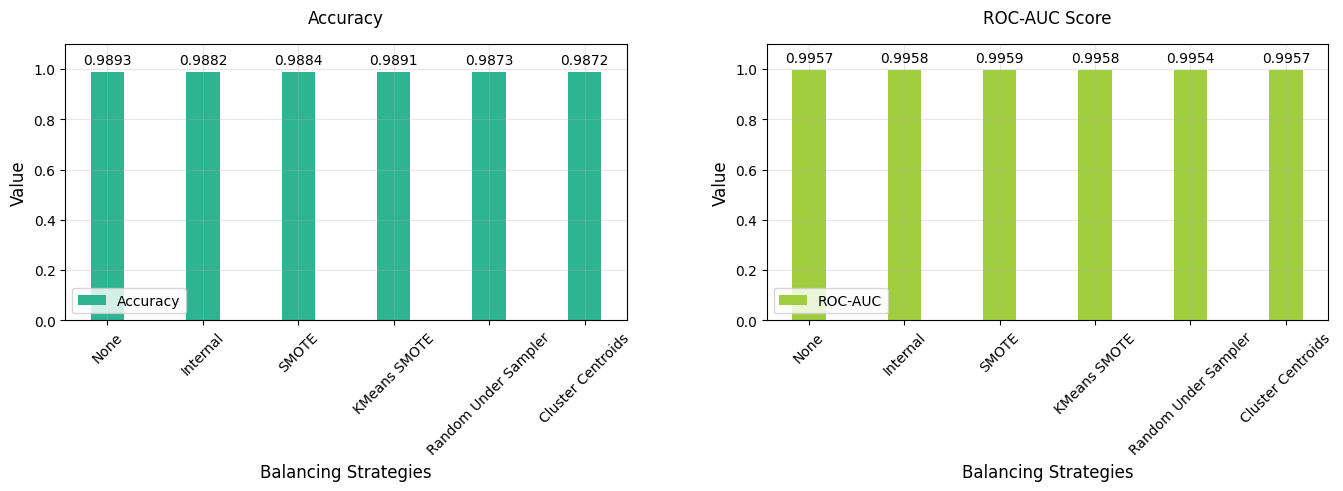

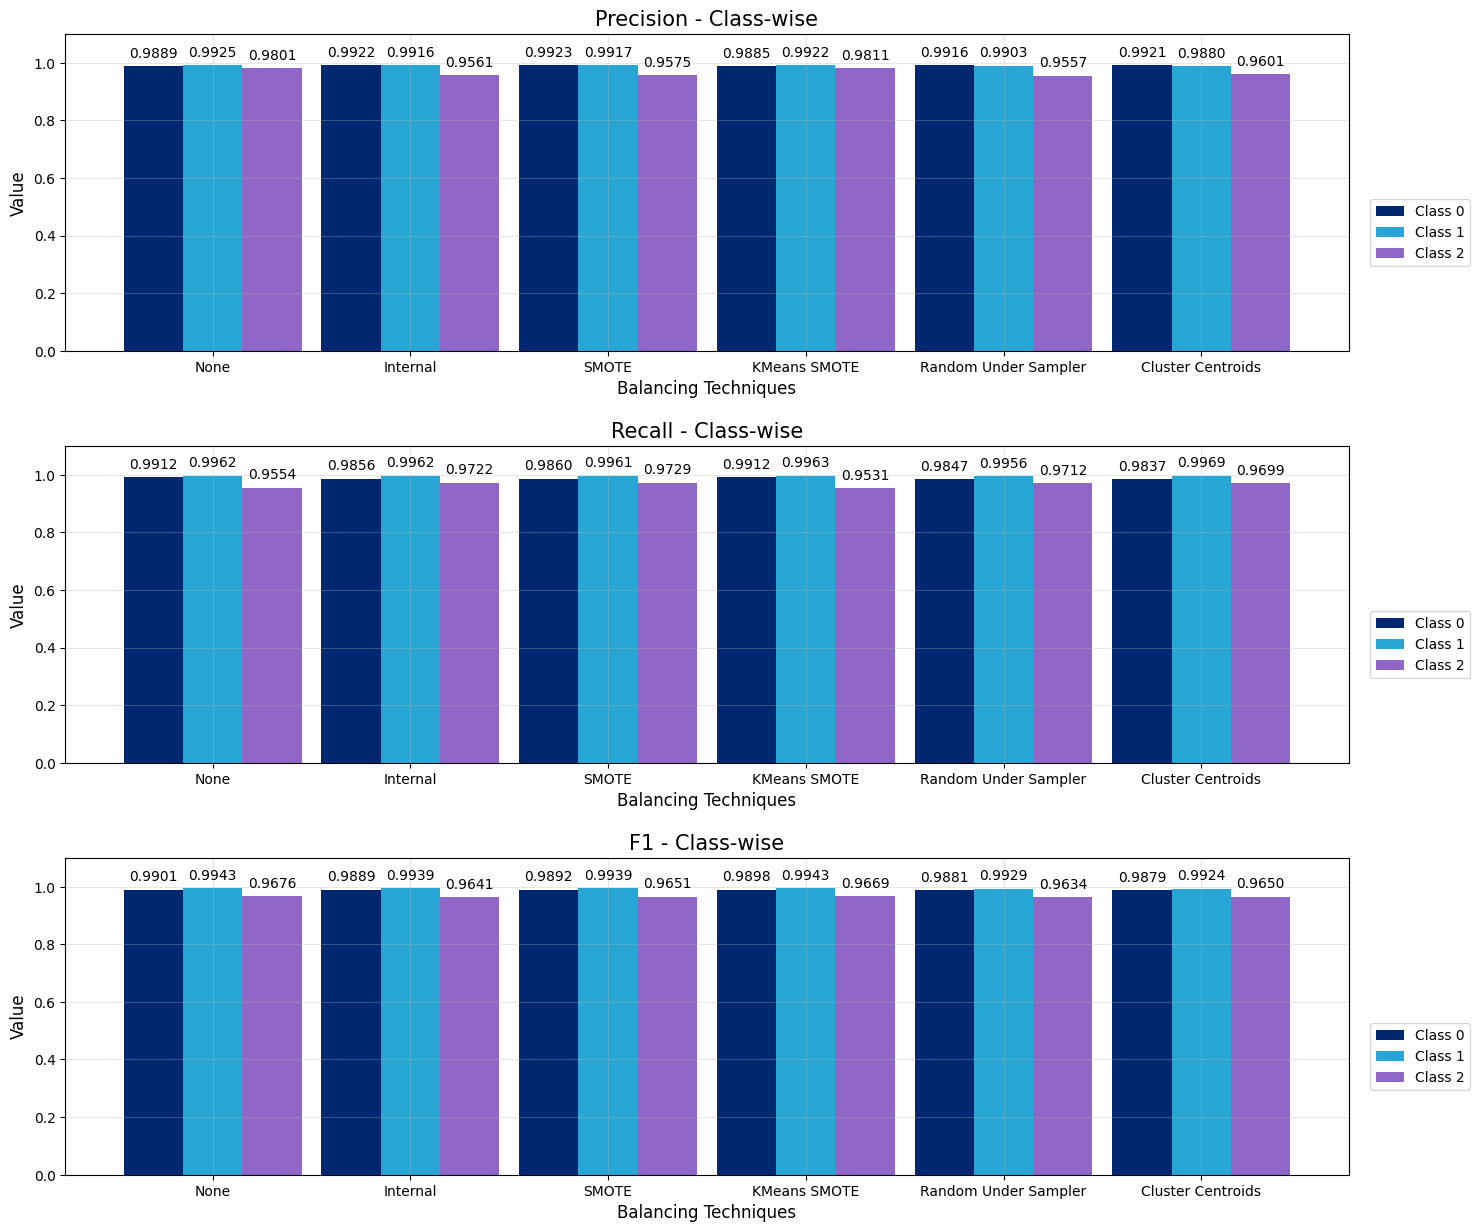

In [425]:
plot_metrics(lr, color_map)

##### Logistic Regression for dataset including **Galaxy** and **QSO**:

In [9]:
lr_fold2 = kfold('Logistic Regression', models['LogisticRegression'], "None", X2, y2)
lr_fold_internal2 = kfold('Logistic Regression', models['LogisticRegressionBalanced'], "Internal", X2, y2)
lr_fold_smote2 = kfold('Logistic Regression', models['LogisticRegression'], "SMOTE",  X2, y2, balancing_methods['SMOTE'])
lr_fold_kmeanssmote2 = kfold('Logistic Regression', models['LogisticRegression'], "KMeans SMOTE", X2, y2, balancing_methods['KMeansSMOTE'])
lr_fold_rus2 = kfold('Logistic Regression', models['LogisticRegression'], "Random Under Sampler", X2, y2, balancing_methods['RandomUnderSampler'])
lr_fold_cc2 = kfold('Logistic Regression', models['LogisticRegression'], "Cluster Centroids", X2, y2, balancing_methods['ClusterCentroids'])
lr2 = pd.concat([lr_fold2, lr_fold_internal2, lr_fold_smote2, lr_fold_kmeanssmote2, lr_fold_rus2, lr_fold_cc2])
lr2

Model             Balancing  Accuracy   ROC-AUC  \
0  Logistic Regression                  None  0.989660  0.993516   
0  Logistic Regression              Internal  0.988179  0.994164   
0  Logistic Regression                 SMOTE  0.988529  0.994290   
0  Logistic Regression          KMeans SMOTE  0.989103  0.993446   
0  Logistic Regression  Random Under Sampler  0.987796  0.993918   
0  Logistic Regression     Cluster Centroids  0.988450  0.993276   

   Precision Class 0  Precision Class 1  Recall Class 0  Recall Class 1  \
0           0.991445           0.980458        0.996198        0.956835   
0           0.994632           0.956454        0.991174        0.973141   
0           0.994767           0.957833        0.991460        0.973813   
0           0.991307           0.977735        0.995663        0.956163   
0           0.994516           0.954808        0.990830        0.972566   
0           0.994482           0.958691        0.991651        0.972374   

   F1 Class 0  F1 Class 1  
0    0.993815    0.968493  
0    0.992900    0.964721  
0    0.993111    0.965753  
0    0.993480    0.966829  
0    0.992669    0.963601  
0    0.993065    0.965478

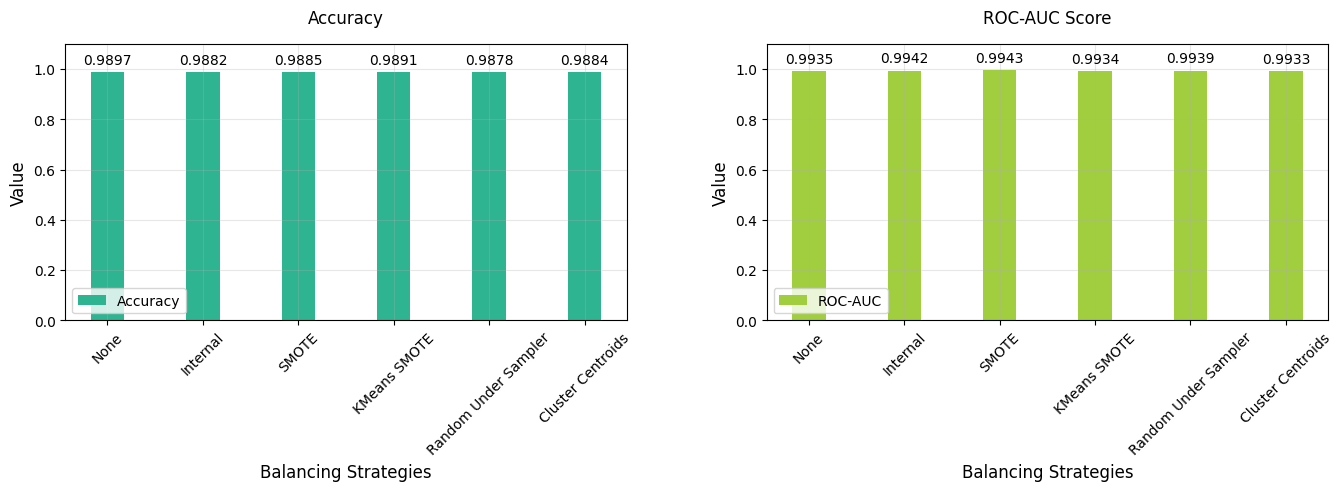

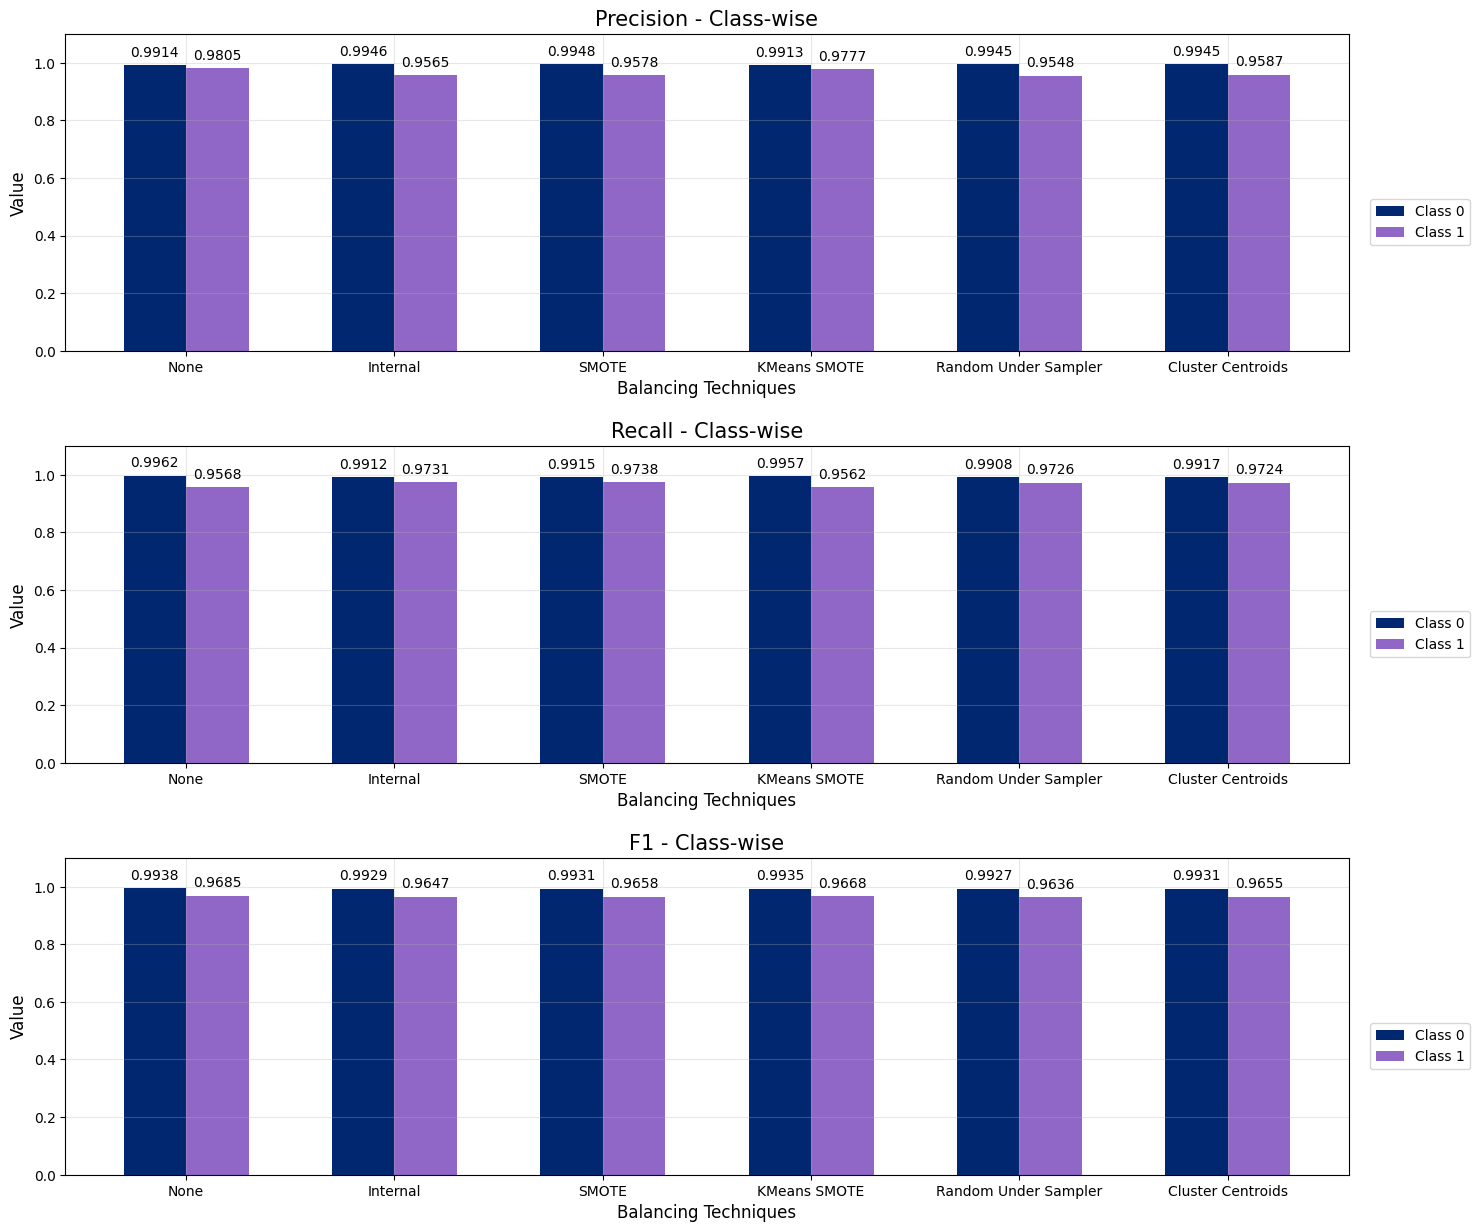

In [422]:
plot_metrics(lr2, color_map2)

##### Logistic Regression for dataset including **Star** and **QSO**:

In [10]:
lr_fold3 = kfold('Logistic Regression', models['LogisticRegression'], "None", X3, y3)
lr_fold_internal3 = kfold('Logistic Regression', models['LogisticRegressionBalanced'], "Internal", X3, y3)
lr_fold_smote3 = kfold('Logistic Regression', models['LogisticRegression'], "SMOTE", X3, y3, balancing_methods['SMOTE'])
lr_fold_kmeanssmote3 = kfold('Logistic Regression', models['LogisticRegression'], "KMeans SMOTE", X3, y3, balancing_methods['KMeansSMOTE'])
lr_fold_rus3 = kfold('Logistic Regression', models['LogisticRegression'], "Random Under Sampler", X3, y3, balancing_methods['RandomUnderSampler'])
lr_fold_cc3 = kfold('Logistic Regression', models['LogisticRegression'], "Cluster Centroids", X3, y3, balancing_methods['ClusterCentroids'])
lr3 = pd.concat([lr_fold3, lr_fold_internal3, lr_fold_smote3, lr_fold_kmeanssmote3, lr_fold_rus3, lr_fold_cc3])
lr3

Model             Balancing  Accuracy   ROC-AUC  \
0  Logistic Regression                  None  0.997062  0.999542   
0  Logistic Regression              Internal  0.997650  0.999497   
0  Logistic Regression                 SMOTE  0.997965  0.999580   
0  Logistic Regression          KMeans SMOTE  0.997020  0.999491   
0  Logistic Regression  Random Under Sampler  0.996915  0.999262   
0  Logistic Regression     Cluster Centroids  0.997524  0.999383   

   Precision Class 0  Precision Class 1  Recall Class 0  Recall Class 1  \
0           0.997559           0.995281        0.998684        0.991271   
0           0.999086           0.992550        0.997905        0.996739   
0           0.999140           0.993785        0.998254        0.996930   
0           0.997505           0.995281        0.998684        0.991079   
0           0.998897           0.989897        0.997153        0.996067   
0           0.998174           0.995196        0.998657        0.993477   

   F1 Class 0  F1 Class 1  
0    0.998121    0.993272  
0    0.998495    0.994640  
0    0.998697    0.995355  
0    0.998094    0.993175  
0    0.998024    0.992972  
0    0.998416    0.994336

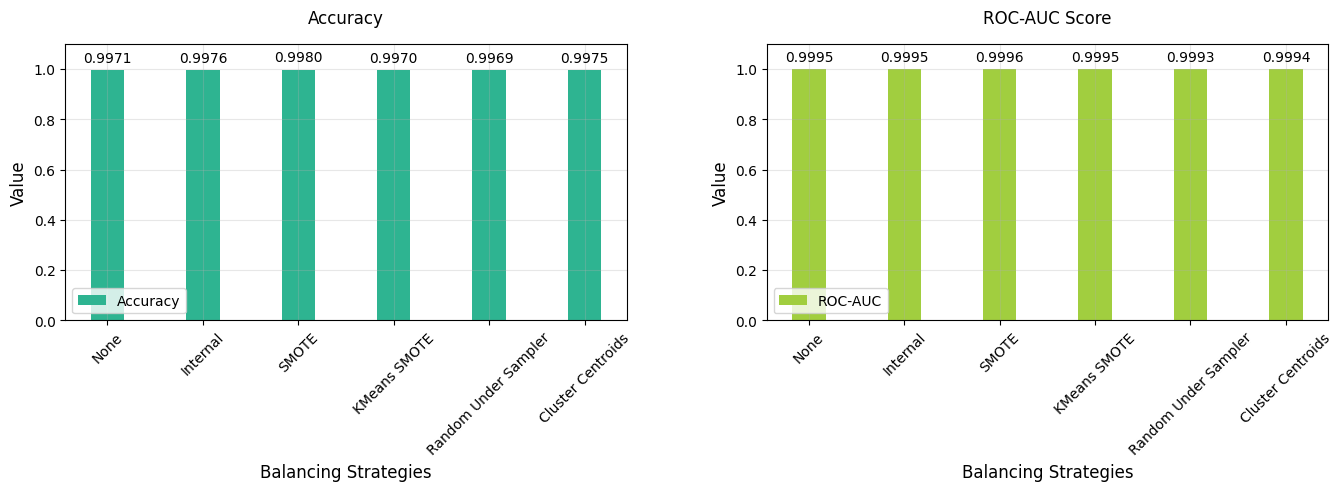

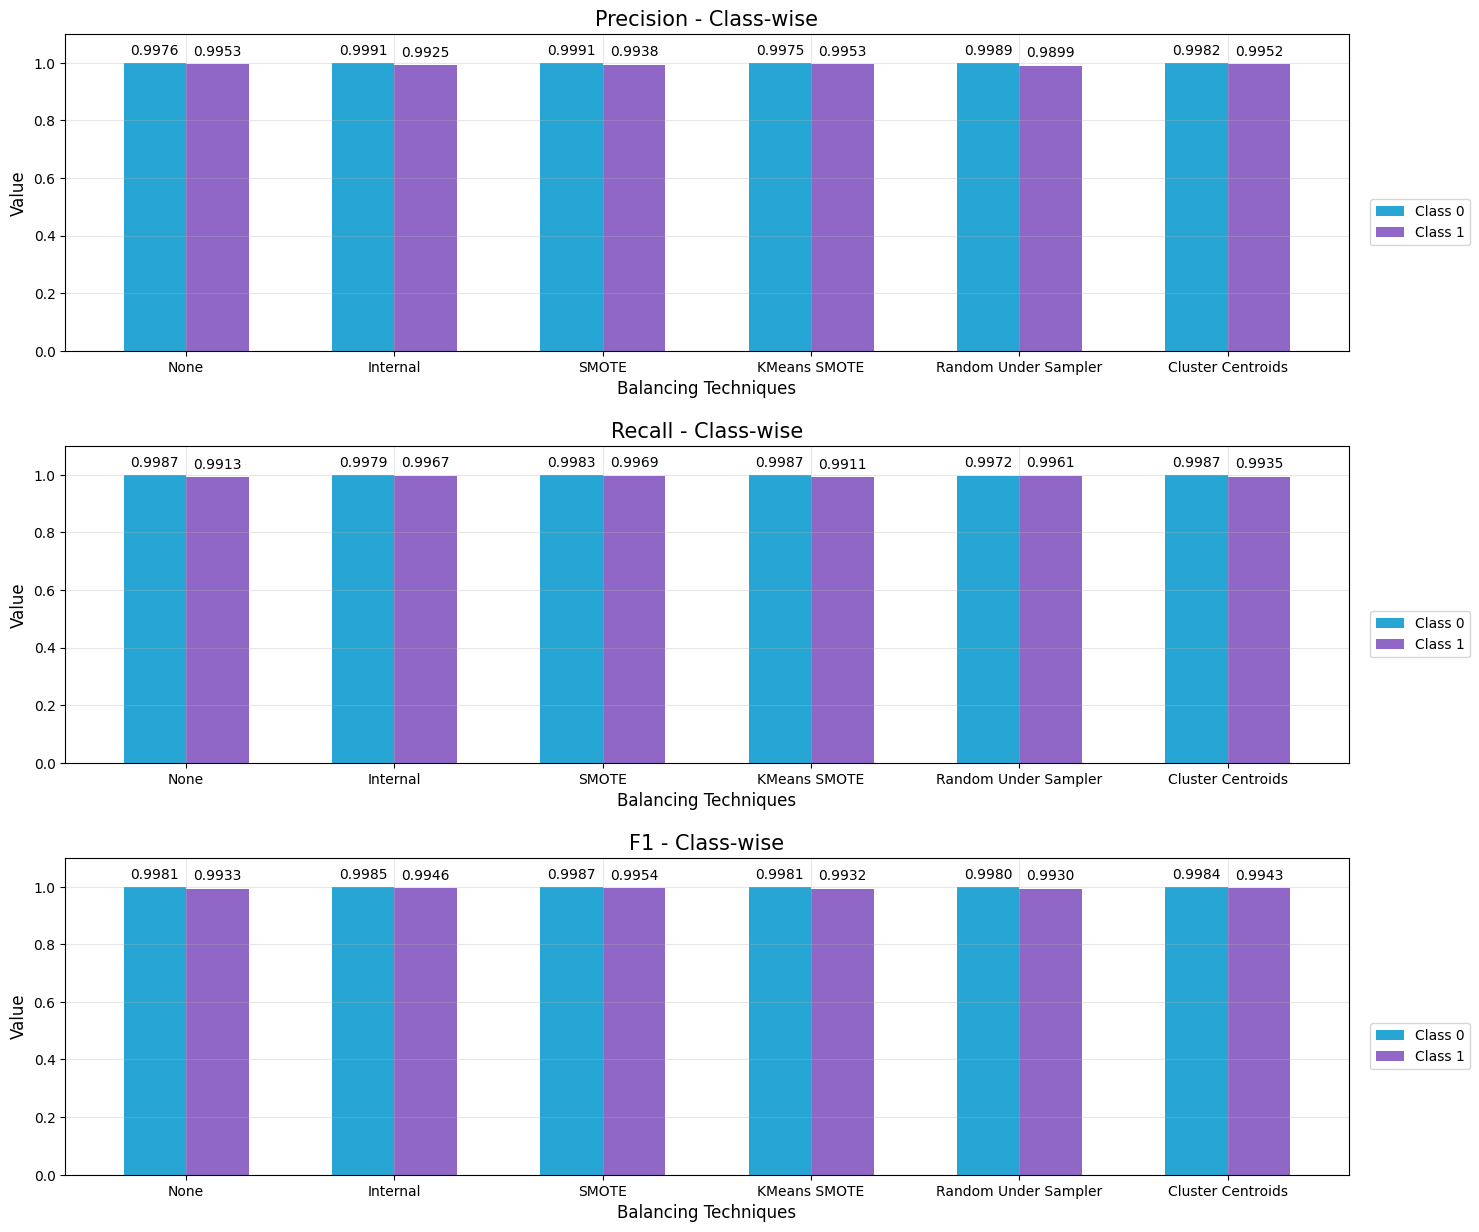

In [421]:
plot_metrics(lr3, color_map3)

##### Logistic Regression for dataset including **Galaxy** and **Star**:

In [11]:
lr_fold4 = kfold('Logistic Regression', models['LogisticRegression'], "None", X4, y4)
lr_fold_internal4 = kfold('Logistic Regression', models['LogisticRegressionBalanced'], "Internal", X4, y4)
lr_fold_smote4 = kfold('Logistic Regression', models['LogisticRegression'], "SMOTE", X4, y4, balancing_methods['SMOTE'])
lr_fold_kmeanssmote4 = kfold('Logistic Regression', models['LogisticRegression'], "KMeans SMOTE", X4, y4, balancing_methods['KMeansSMOTE'])
lr_fold_rus4 = kfold('Logistic Regression', models['LogisticRegression'], "Random Under Sampler", X4, y4, balancing_methods['RandomUnderSampler'])
lr_fold_cc4 = kfold('Logistic Regression', models['LogisticRegression'], "Cluster Centroids", X4, y4, balancing_methods['ClusterCentroids'])
lr4 = pd.concat([lr_fold4, lr_fold_internal4, lr_fold_smote4, lr_fold_kmeanssmote4, lr_fold_rus4, lr_fold_cc4])
lr4

Model             Balancing  Accuracy   ROC-AUC  \
0  Logistic Regression                  None  0.996182  0.998124   
0  Logistic Regression              Internal  0.996070  0.998120   
0  Logistic Regression                 SMOTE  0.996126  0.998127   
0  Logistic Regression          KMeans SMOTE  0.996193  0.998077   
0  Logistic Regression  Random Under Sampler  0.995992  0.998048   
0  Logistic Regression     Cluster Centroids  0.996148  0.998099   

   Precision Class 0  Precision Class 1  Recall Class 0  Recall Class 1  \
0           0.998677           0.992708        0.994784        0.998147   
0           0.998830           0.992233        0.994441        0.998362   
0           0.998773           0.992444        0.994593        0.998281   
0           0.998677           0.992735        0.994804        0.998147   
0           0.998753           0.992152        0.994383        0.998254   
0           0.998696           0.992602        0.994708        0.998174   

   F1 Class 0  F1 Class 1  
0    0.996727    0.995420  
0    0.996630    0.995287  
0    0.996678    0.995354  
0    0.996736    0.995433  
0    0.996563    0.995194  
0    0.996698    0.995380

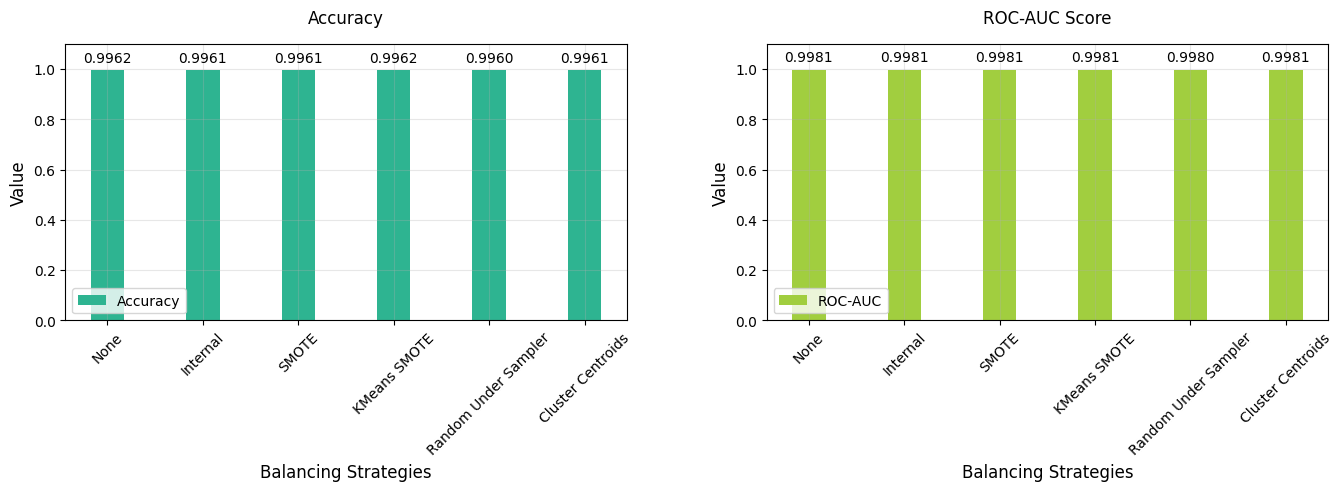

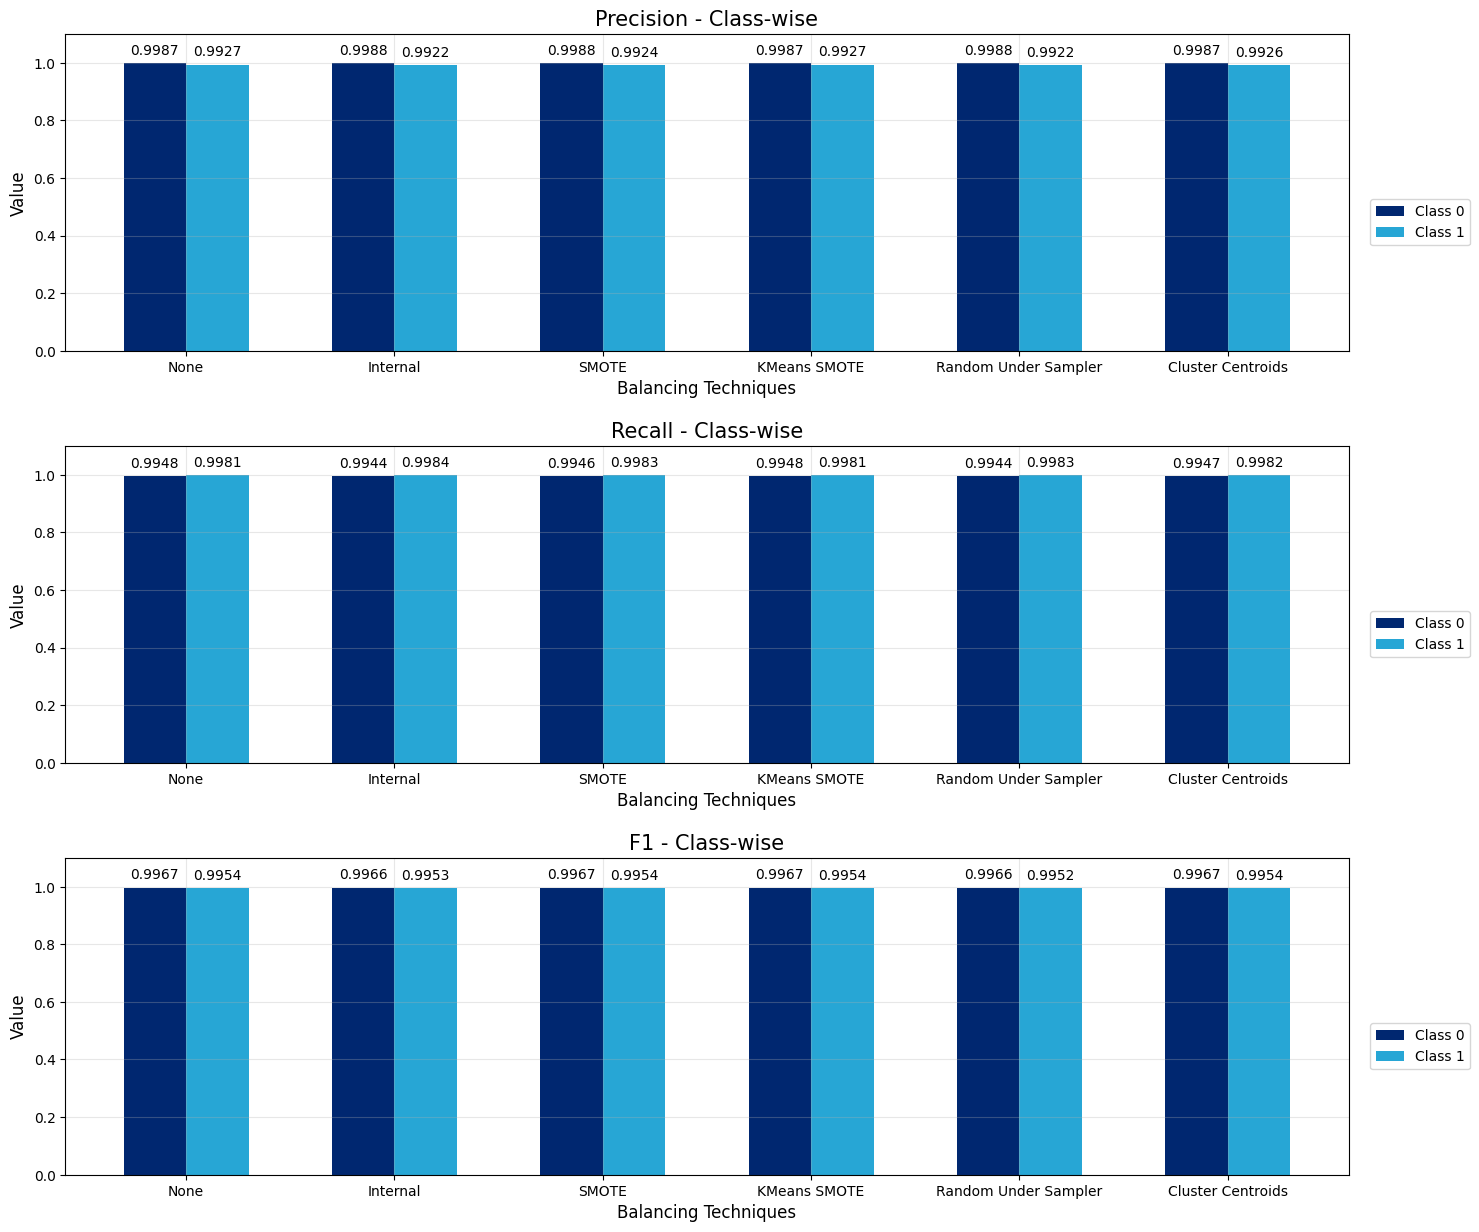

In [420]:
plot_metrics(lr4, color_map4)

## **KNN**

##### KNN for **original dataset**:

In [12]:
knn_fold = kfold('KNN', models['KNN'], "None", X, y)
knn_fold_internal = kfold('KNN', models['KNNBalanced'], "Internal", X, y)
knn_fold_smote = kfold('KNN', models['KNN'], "SMOTE", X, y, balancing_methods['SMOTE'])
knn_fold_kmeanssmote = kfold('KNN', models['KNN'], "KMeans SMOTE", X, y, balancing_methods['KMeansSMOTE'])
knn_fold_rus = kfold('KNN', models['KNN'], "Random Under Sampler", X, y, balancing_methods['RandomUnderSampler'])
knn_fold_cc = kfold('KNN', models['KNN'], "Cluster Centroids", X, y, balancing_methods['ClusterCentroids'])
knn = pd.concat([knn_fold, knn_fold_internal, knn_fold_smote, knn_fold_kmeanssmote, knn_fold_rus, knn_fold_cc])
knn

Model             Balancing  Accuracy   ROC-AUC  Precision Class 0  \
0   KNN                  None   0.98244  0.987106           0.981215   
0   KNN              Internal   0.98272  0.987145           0.981953   
0   KNN                 SMOTE   0.97739  0.987276           0.986652   
0   KNN          KMeans SMOTE   0.98240  0.987005           0.981565   
0   KNN  Random Under Sampler   0.97849  0.990085           0.985061   
0   KNN     Cluster Centroids   0.98155  0.990554           0.985637   

   Precision Class 1  Precision Class 2  Recall Class 0  Recall Class 1  \
0           0.983301           0.985817        0.990963        0.991513   
0           0.983671           0.983216        0.990658        0.991728   
0           0.986216           0.902960        0.977227        0.987645   
0           0.982832           0.985313        0.990792        0.991593   
0           0.984547           0.924744        0.985117        0.980501   
0           0.985821           0.945478        0.985882        0.987752   

   Recall Class 2  F1 Class 0  F1 Class 1  F1 Class 2  
0        0.907242    0.986065    0.987389    0.944892  
0        0.910695    0.986286    0.987682    0.945563  
0        0.941583    0.981917    0.986930    0.921861  
0        0.907434    0.986157    0.987192    0.944764  
0        0.938034    0.985089    0.982519    0.931337  
0        0.937650    0.985759    0.986785    0.941542

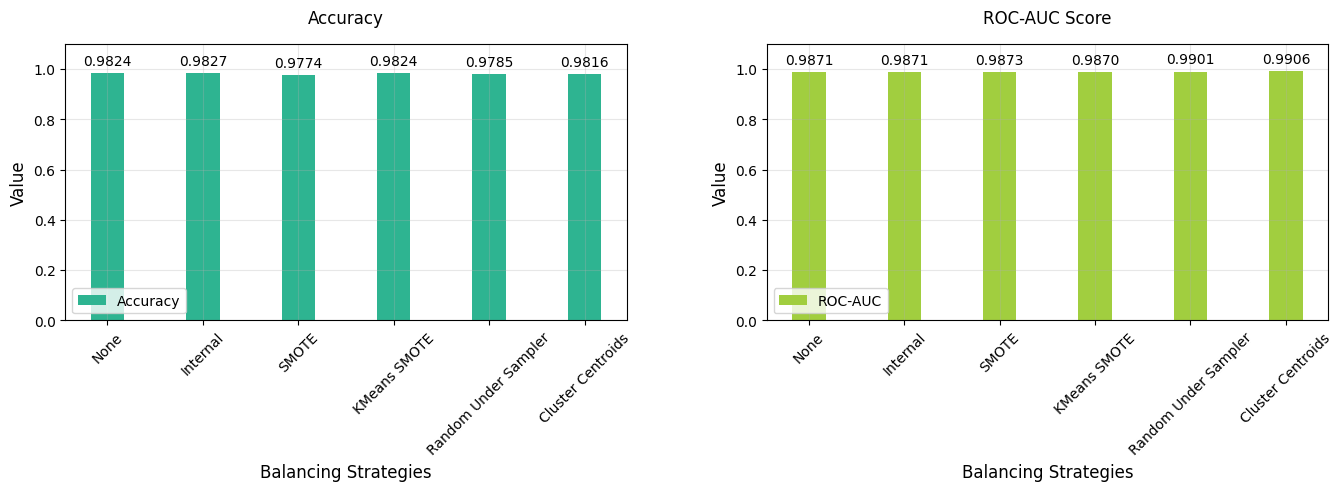

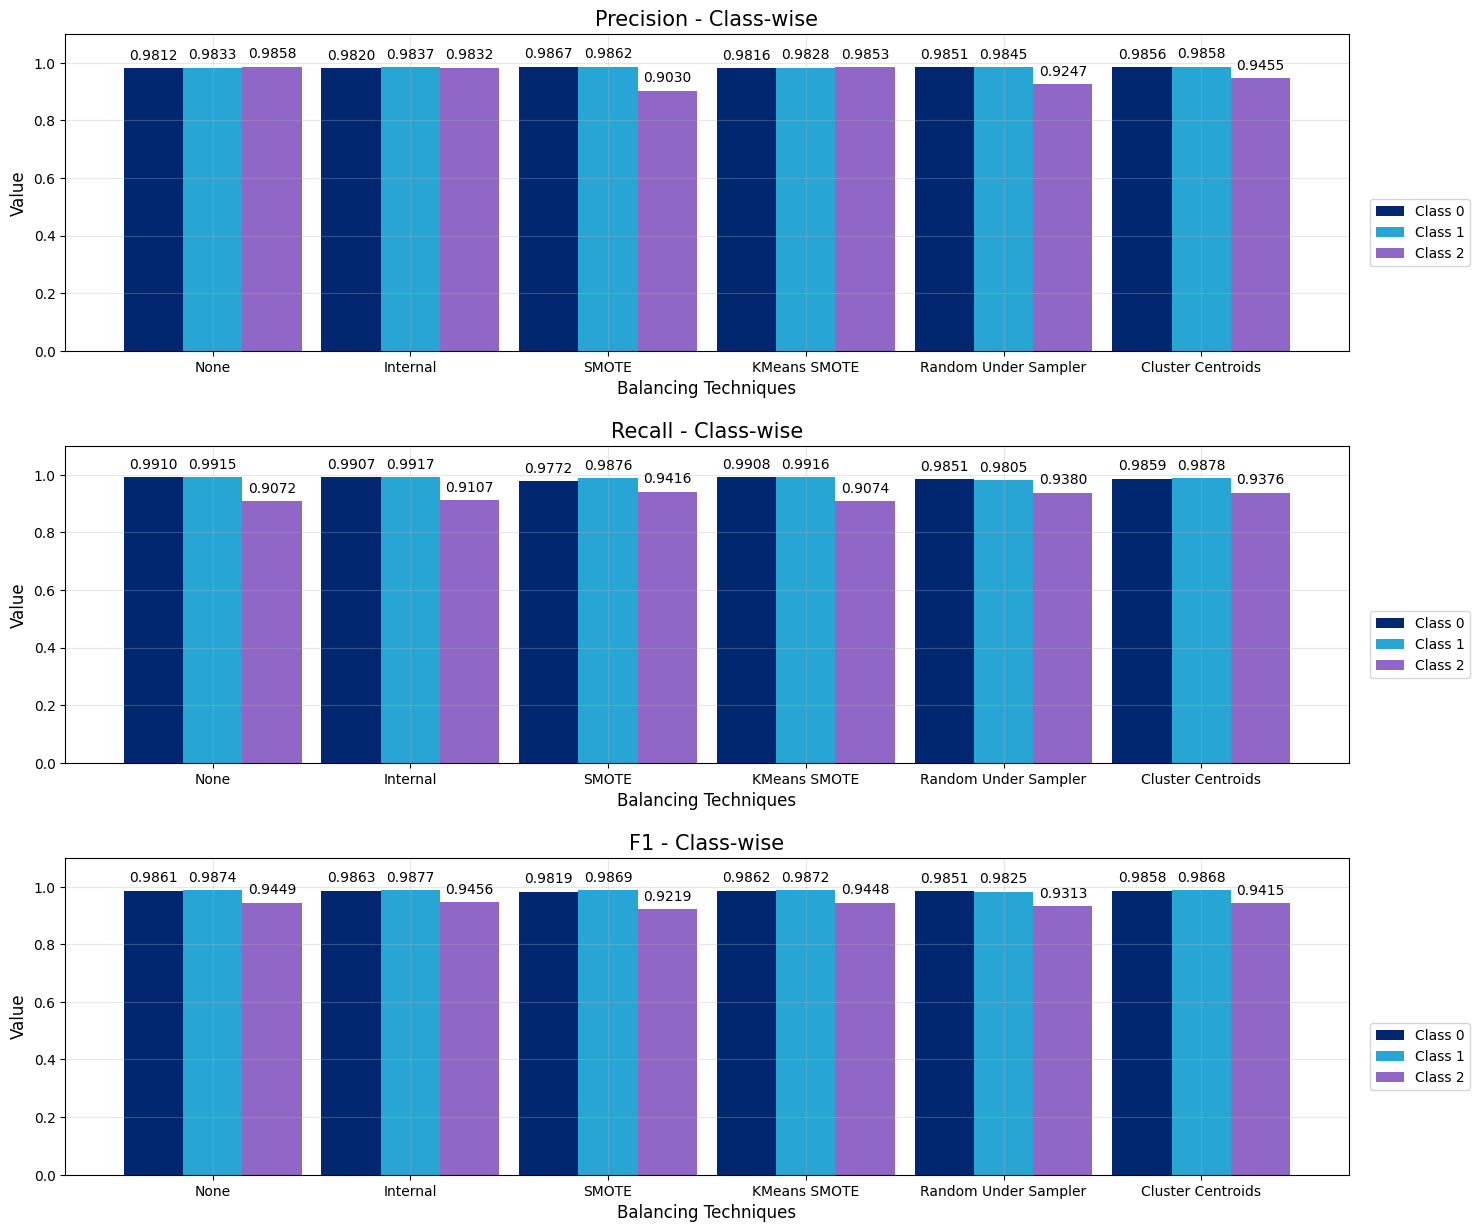

In [416]:
plot_metrics(knn, color_map)

##### KNN for dataset including **Galaxy** and **QSO**:

In [13]:
knn_fold2 = kfold('KNN', models['KNN'], "None", X2, y2)
knn_fold_internal2 = kfold('KNN', models['KNNBalanced'], "Internal", X2, y2)
knn_fold_smote2 = kfold('KNN', models['KNN'], "SMOTE", X2, y2, balancing_methods['SMOTE'])
knn_fold_kmeanssmote2 = kfold('KNN', models['KNN'], "KMeans SMOTE", X2, y2, balancing_methods['KMeansSMOTE'])
knn_fold_rus2 = kfold('KNN', models['KNN'], "Random Under Sampler", X2, y2, balancing_methods['RandomUnderSampler'])
knn_fold_cc2 = kfold('KNN', models['KNN'], "Cluster Centroids", X2, y2, balancing_methods['ClusterCentroids'])
knn2 = pd.concat([knn_fold2, knn_fold_internal2, knn_fold_smote2, knn_fold_kmeanssmote2, knn_fold_rus2, knn_fold_cc2])
knn2

Model             Balancing  Accuracy   ROC-AUC  Precision Class 0  \
0   KNN                  None  0.985056  0.979414           0.986799   
0   KNN              Internal  0.985072  0.979476           0.986836   
0   KNN                 SMOTE  0.976692  0.979957           0.991291   
0   KNN          KMeans SMOTE  0.985343  0.979263           0.987561   
0   KNN  Random Under Sampler  0.982157  0.983582           0.990877   
0   KNN     Cluster Centroids  0.983065  0.984193           0.990399   

   Precision Class 1  Recall Class 0  Recall Class 1  F1 Class 0  F1 Class 1  
0           0.975839        0.995396        0.933141    0.991079    0.954007  
0           0.975747        0.995377        0.933333    0.991088    0.954064  
0           0.907886        0.980666        0.956739    0.985950    0.931671  
0           0.973701        0.994956        0.937074    0.991245    0.955032  
0           0.939224        0.987697        0.954341    0.989284    0.946715  
0           0.946508        0.989282        0.951847    0.989840    0.949163

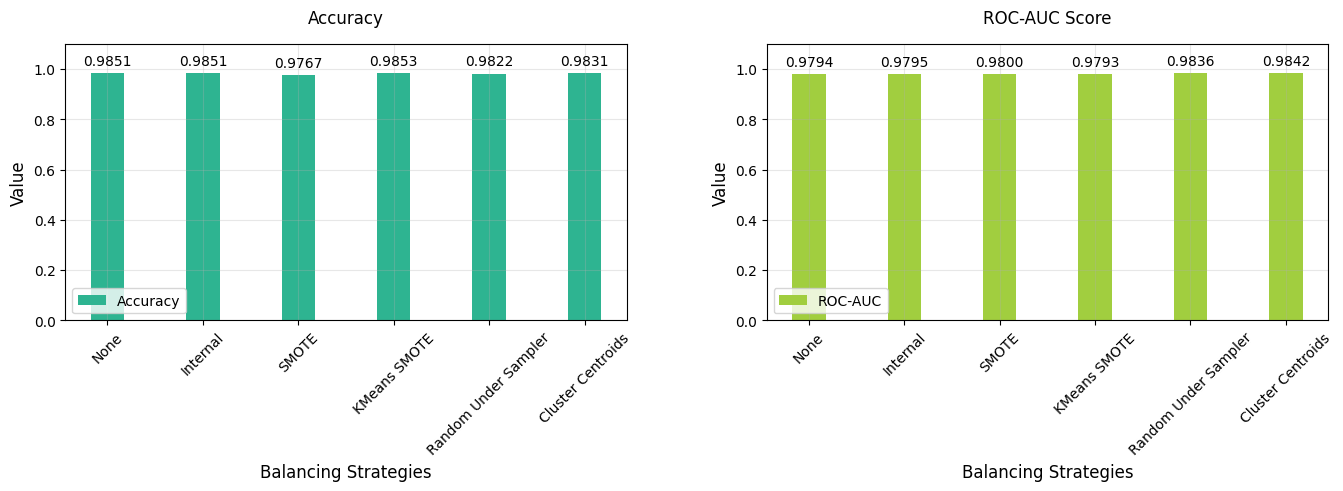

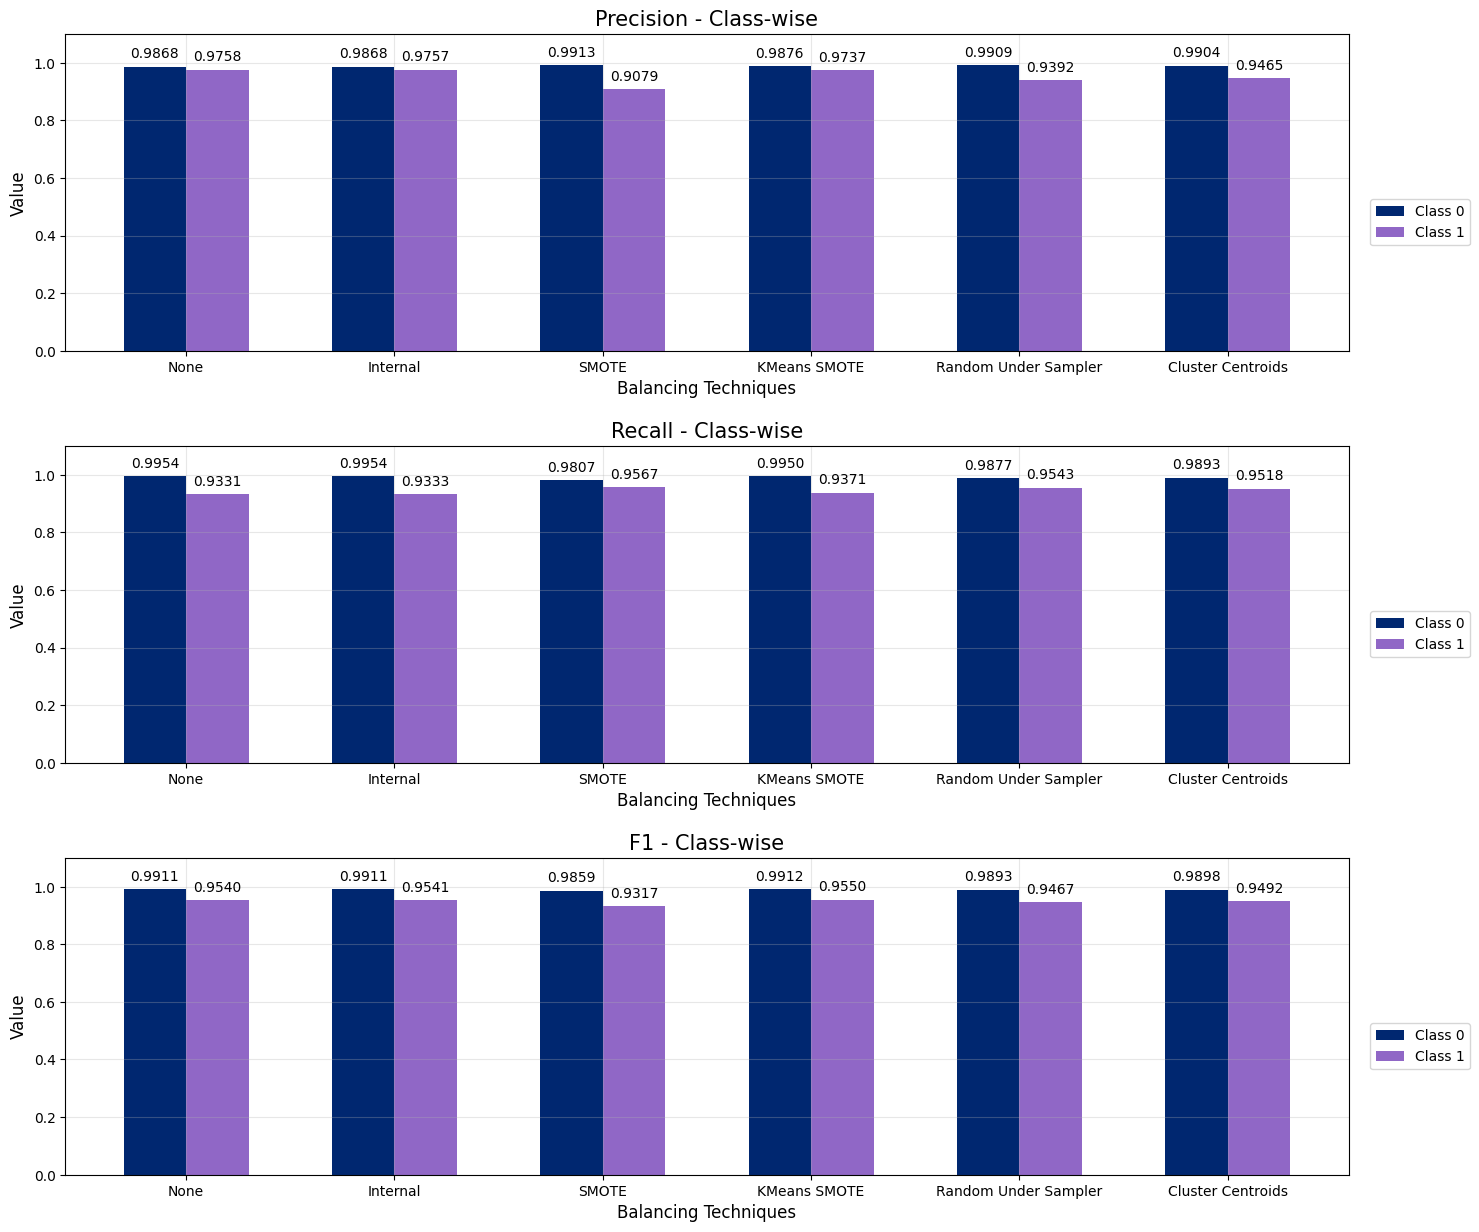

In [417]:
plot_metrics(knn2, color_map2)

##### KNN for dataset including **Star** and **QSO**:

In [14]:
knn_fold3 = kfold('KNN', models['KNN'], "None", X3, y3)
knn_fold_internal3 = kfold('KNN', models['KNNBalanced'], "Internal", X3, y3)
knn_fold_smote3 = kfold('KNN', models['KNN'], "SMOTE", X3, y3, balancing_methods['SMOTE'])
knn_fold_kmeanssmote3 = kfold('KNN', models['KNN'], "KMeans SMOTE", X3, y3, balancing_methods['KMeansSMOTE'])
knn_fold_rus3 = kfold('KNN', models['KNN'], "Random Under Sampler", X3, y3, balancing_methods['RandomUnderSampler'])
knn_fold_cc3 = kfold('KNN', models['KNN'], "Cluster Centroids", X3, y3, balancing_methods['ClusterCentroids'])
knn3 = pd.concat([knn_fold3, knn_fold_internal3, knn_fold_smote3, knn_fold_kmeanssmote3, knn_fold_rus3, knn_fold_cc3])
knn3

Model             Balancing  Accuracy   ROC-AUC  Precision Class 0  \
0   KNN                  None  0.987221  0.994494           0.990098   
0   KNN              Internal  0.987263  0.994610           0.990151   
0   KNN                 SMOTE  0.984871  0.993761           0.995763   
0   KNN          KMeans SMOTE  0.986361  0.994113           0.991536   
0   KNN  Random Under Sampler  0.978597  0.994734           0.995024   
0   KNN     Cluster Centroids  0.984682  0.995758           0.994018   

   Precision Class 1  Recall Class 0  Recall Class 1  F1 Class 0  F1 Class 1  
0           0.976788        0.993581        0.964508    0.991836    0.970606  
0           0.976793        0.993581        0.964700    0.991863    0.970706  
0           0.947865        0.984825        0.985036    0.990264    0.966090  
0           0.967957        0.991002        0.969784    0.991268    0.968860  
0           0.924395        0.977492        0.982542    0.986180    0.952577  
0           0.952493        0.986329        0.978801    0.990158    0.965467

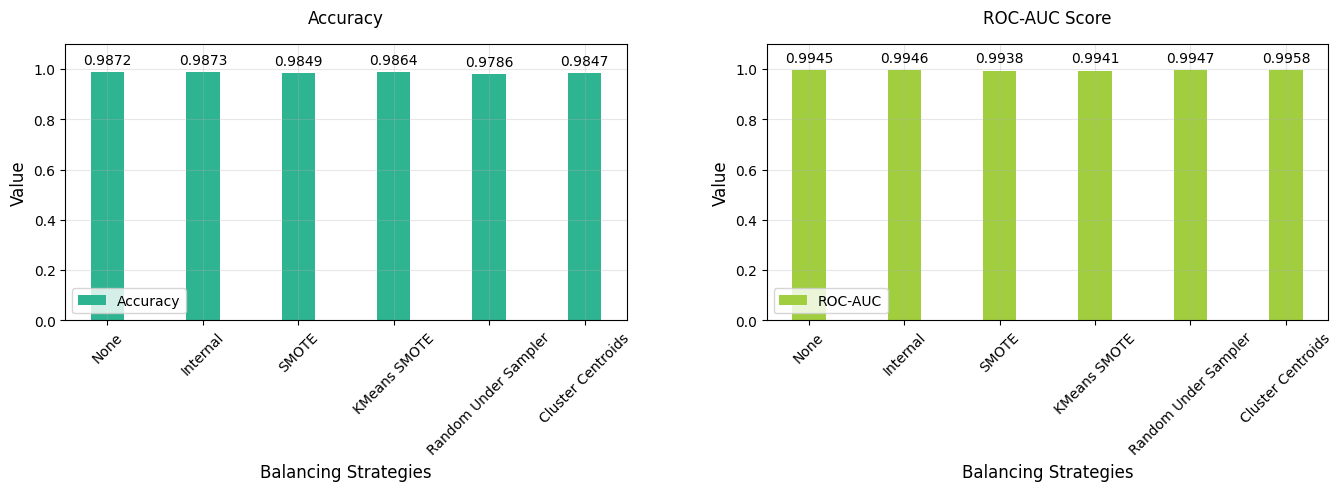

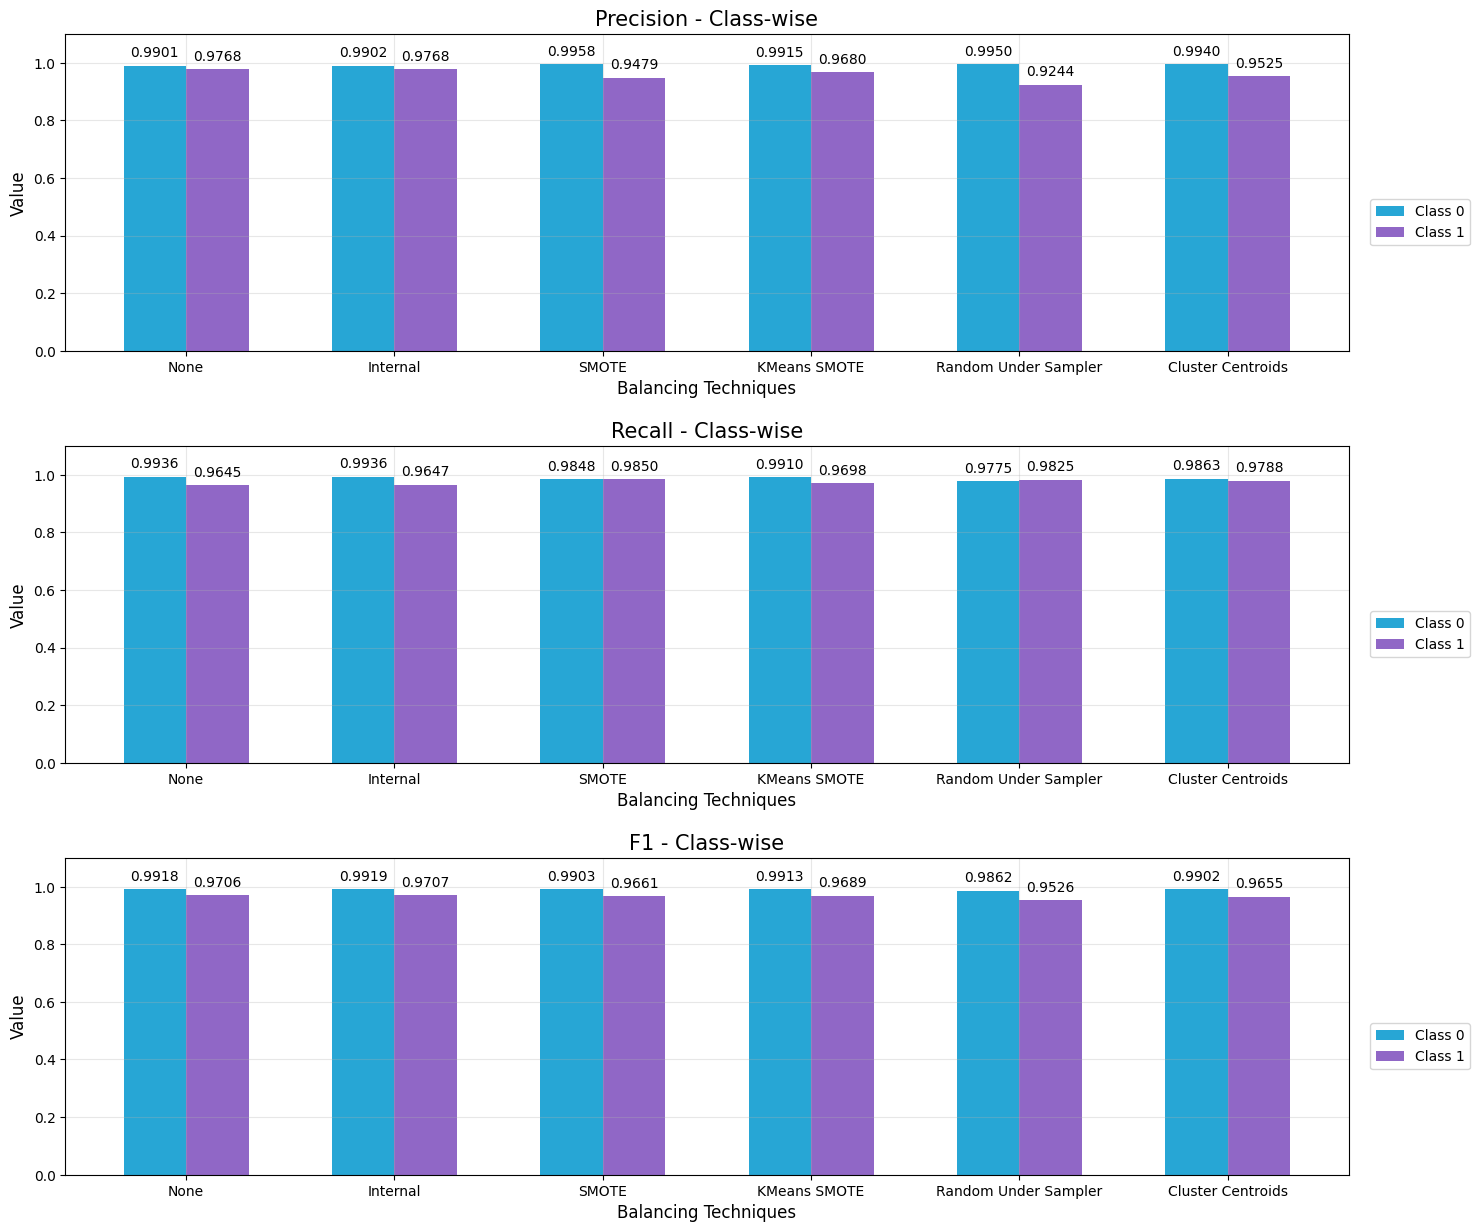

In [418]:
plot_metrics(knn3, color_map3)

##### KNN for dataset including **Galaxy** and **Star**:

In [15]:
knn_fold4 = kfold('KNN', models['KNN'], "None", X4, y4)
knn_fold_internal4 = kfold('KNN', models['KNNBalanced'], "Internal", X4, y4)
knn_fold_smote4 = kfold('KNN', models['KNN'], "SMOTE", X4, y4, balancing_methods['SMOTE'])
knn_fold_kmeanssmote4 = kfold('KNN', models['KNN'], "KMeans SMOTE", X4, y4, balancing_methods['KMeansSMOTE'])
knn_fold_rus4 = kfold('KNN', models['KNN'], "Random Under Sampler", X4, y4, balancing_methods['RandomUnderSampler'])
knn_fold_cc4 = kfold('KNN', models['KNN'], "Cluster Centroids", X4, y4, balancing_methods['ClusterCentroids'])
knn4 = pd.concat([knn_fold4, knn_fold_internal4, knn_fold_smote4, knn_fold_kmeanssmote4, knn_fold_rus4, knn_fold_cc4])
knn4

Model             Balancing  Accuracy   ROC-AUC  Precision Class 0  \
0   KNN                  None  0.994842  0.996463           0.996194   
0   KNN              Internal  0.994842  0.996464           0.996213   
0   KNN                 SMOTE  0.994798  0.996450           0.996459   
0   KNN          KMeans SMOTE  0.994809  0.996484           0.996213   
0   KNN  Random Under Sampler  0.994708  0.996599           0.996554   
0   KNN     Cluster Centroids  0.994809  0.996489           0.996212   

   Precision Class 1  Recall Class 0  Recall Class 1  F1 Class 0  F1 Class 1  
0           0.992948        0.994975        0.994655    0.995584    0.993801  
0           0.992922        0.994956        0.994682    0.995584    0.993801  
0           0.992472        0.994632        0.995031    0.995545    0.993750  
0           0.992842        0.994899        0.994682    0.995555    0.993761  
0           0.992128        0.994383        0.995165    0.995467    0.993644  
0           0.992842        0.994899        0.994682    0.995555    0.993761

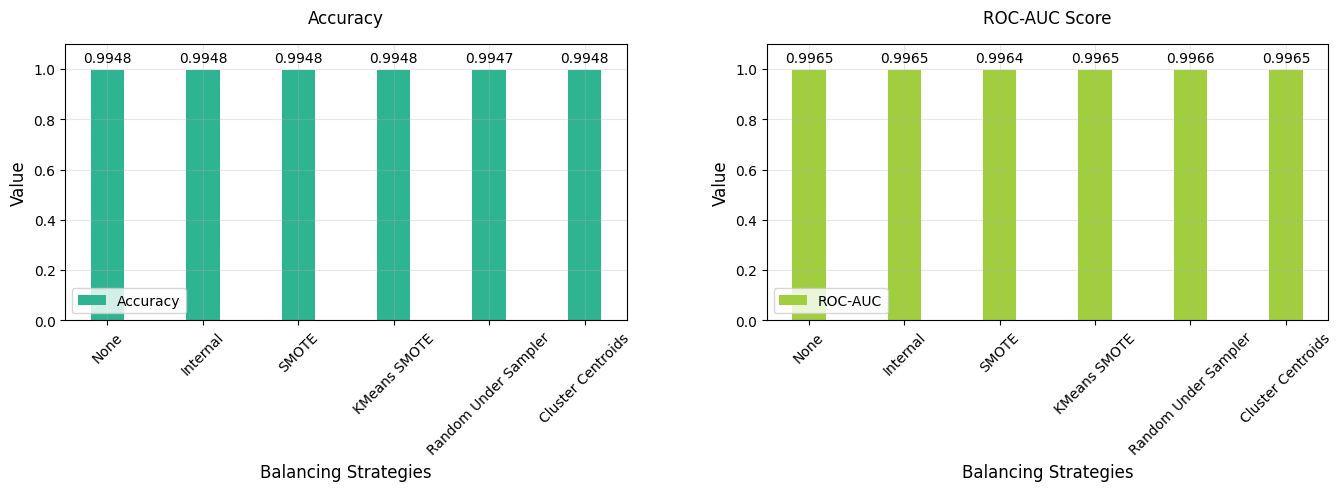

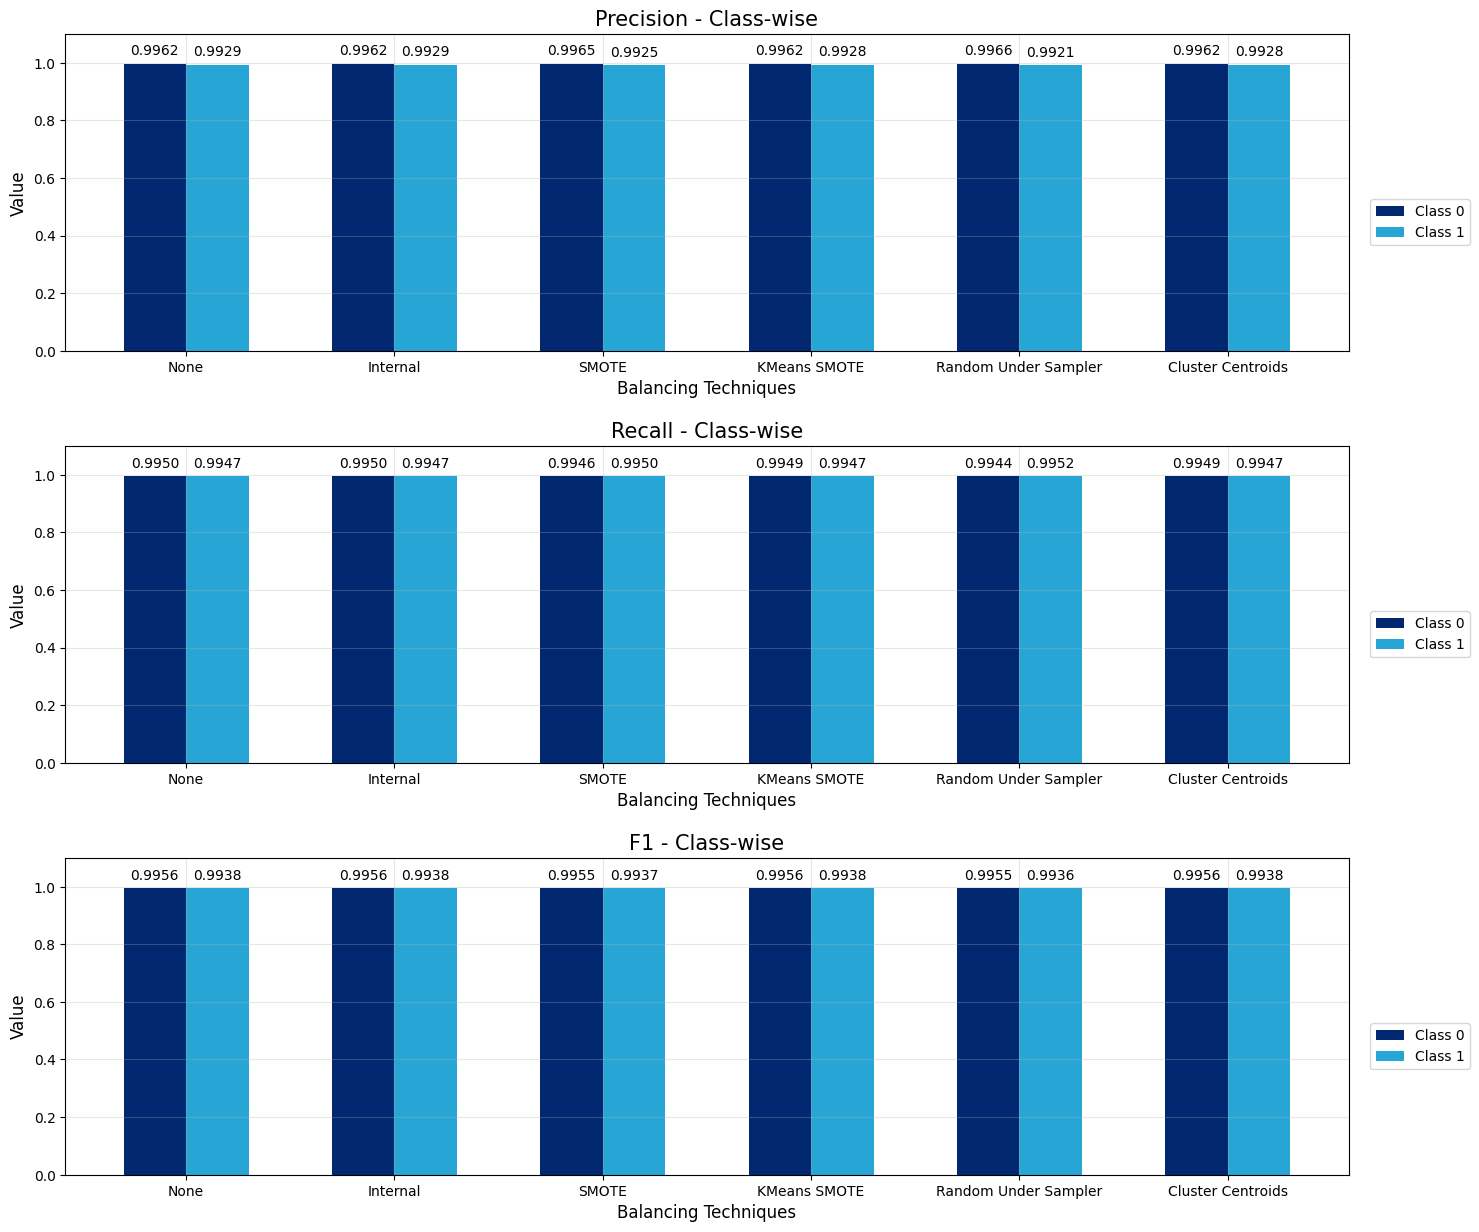

In [419]:
plot_metrics(knn4, color_map4)

## **Random Forest**

##### Random Forest for **original dataset**:

In [20]:
rf_fold = kfold('Random Forest', models['RandomForest'], "None", X, y)
rf_fold_internal = kfold('Random Forest', models['RandomForestBalanced'], "Internal", X, y)
rf_fold_smote = kfold('Random Forest', models['RandomForest'], "SMOTE", X, y, balancing_methods['SMOTE'])
rf_fold_kmeanssmote = kfold('Random Forest', models['RandomForest'], "KMeans SMOTE", X, y, balancing_methods['KMeansSMOTE'])
rf_fold_rus = kfold('Random Forest', models['RandomForest'], "Random Under Sampler", X, y, balancing_methods['RandomUnderSampler'])
rf_fold_cc = kfold('Random Forest', models['RandomForest'], "Cluster Centroids", X, y, balancing_methods['ClusterCentroids'])
rf = pd.concat([rf_fold, rf_fold_internal, rf_fold_smote, rf_fold_kmeanssmote, rf_fold_rus, rf_fold_cc])
rf

Model             Balancing  Accuracy   ROC-AUC  Precision Class 0  \
0  Random Forest                  None   0.99104  0.997736           0.990262   
0  Random Forest              Internal   0.99088  0.997889           0.989549   
0  Random Forest                 SMOTE   0.99092  0.998597           0.992249   
0  Random Forest          KMeans SMOTE   0.99108  0.997780           0.990375   
0  Random Forest  Random Under Sampler   0.98866  0.998288           0.992708   
0  Random Forest     Cluster Centroids   0.98630  0.997933           0.993552   

   Precision Class 1  Precision Class 2  Recall Class 0  Recall Class 1  \
0           0.994412           0.982608        0.992740        0.999006   
0           0.994943           0.982764        0.993161        0.998603   
0           0.994757           0.970388        0.990486        0.998791   
0           0.994598           0.981752        0.992702        0.998899   
0           0.993929           0.950334        0.985710        0.998254   
0           0.993298           0.927922        0.980284        0.999167   

   Recall Class 2  F1 Class 0  F1 Class 1  F1 Class 2  
0        0.954053    0.991499    0.996704    0.968119  
0        0.951847    0.991352    0.996769    0.967058  
0        0.964988    0.991366    0.996770    0.967679  
0        0.955012    0.991537    0.996744    0.968196  
0        0.969209    0.989196    0.996087    0.959677  
0        0.970552    0.986873    0.996224    0.948758

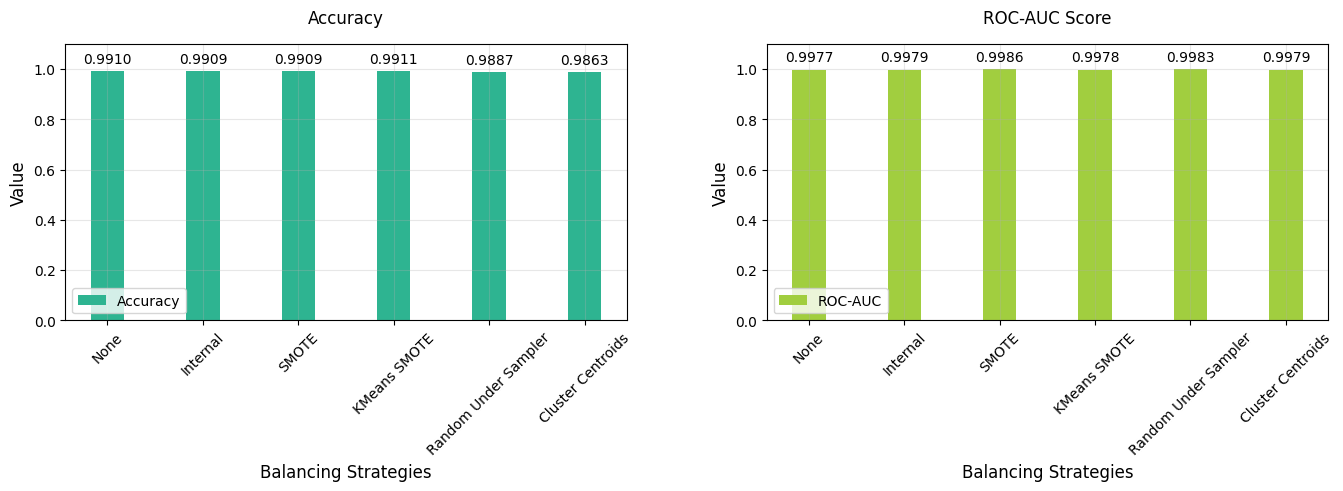

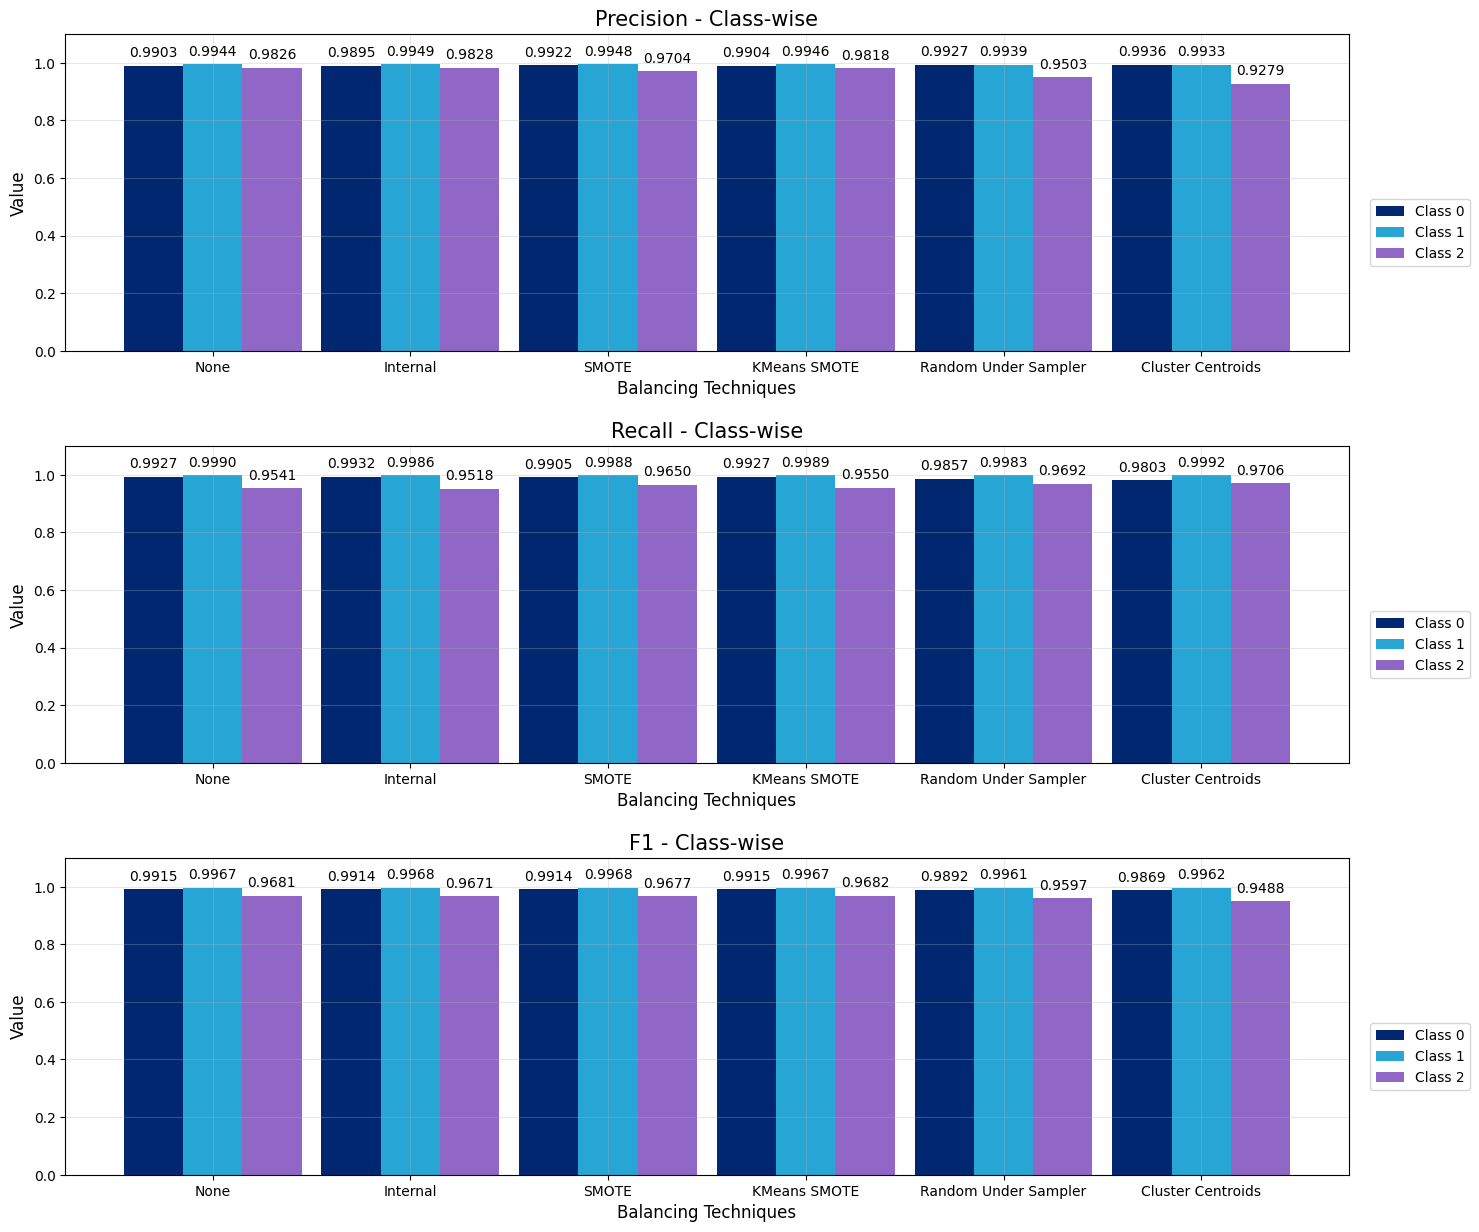

In [413]:
plot_metrics(rf, color_map)

##### Random Forest for dataset including **Galaxy** and **QSO**:

In [21]:
rf_fold2 = kfold('Random Forest', models['RandomForest'], "None", X2, y2)
rf_fold_internal2 = kfold('Random Forest', models['RandomForestBalanced'], "Internal", X2, y2)
rf_fold_smote2 = kfold('Random Forest', models['RandomForest'], "SMOTE", X2, y2, balancing_methods['SMOTE'])
rf_fold_kmeanssmote2 = kfold('Random Forest', models['RandomForest'], "KMeans SMOTE", X2, y2, balancing_methods['KMeansSMOTE'])
rf_fold_rus2 = kfold('Random Forest', models['RandomForest'], "Random Under Sampler", X2, y2, balancing_methods['RandomUnderSampler'])
rf_fold_cc2 = kfold('Random Forest', models['RandomForest'], "Cluster Centroids", X2, y2, balancing_methods['ClusterCentroids'])
rf2 = pd.concat([rf_fold2, rf_fold_internal2, rf_fold_smote2, rf_fold_kmeanssmote2, rf_fold_rus2, rf_fold_cc2])
rf2

Model             Balancing  Accuracy   ROC-AUC  Precision Class 0  \
0  Random Forest                  None  0.989740  0.994418           0.991015   
0  Random Forest              Internal  0.989262  0.994149           0.990284   
0  Random Forest                 SMOTE  0.989533  0.995696           0.993056   
0  Random Forest          KMeans SMOTE  0.989597  0.993709           0.991088   
0  Random Forest  Random Under Sampler  0.987143  0.994910           0.993773   
0  Random Forest     Cluster Centroids  0.981694  0.994230           0.994247   

   Precision Class 1  Recall Class 0  Recall Class 1  F1 Class 0  F1 Class 1  
0           0.983117        0.996733        0.954628    0.993866    0.968660  
0           0.983926        0.996905        0.950887    0.993583    0.967122  
0           0.971725        0.994402        0.965084    0.993728    0.968382  
0           0.981859        0.996485        0.955012    0.993779    0.968248  
0           0.954459        0.990792        0.968825    0.992280    0.961585  
0           0.922620        0.983742        0.971415    0.988964    0.946350

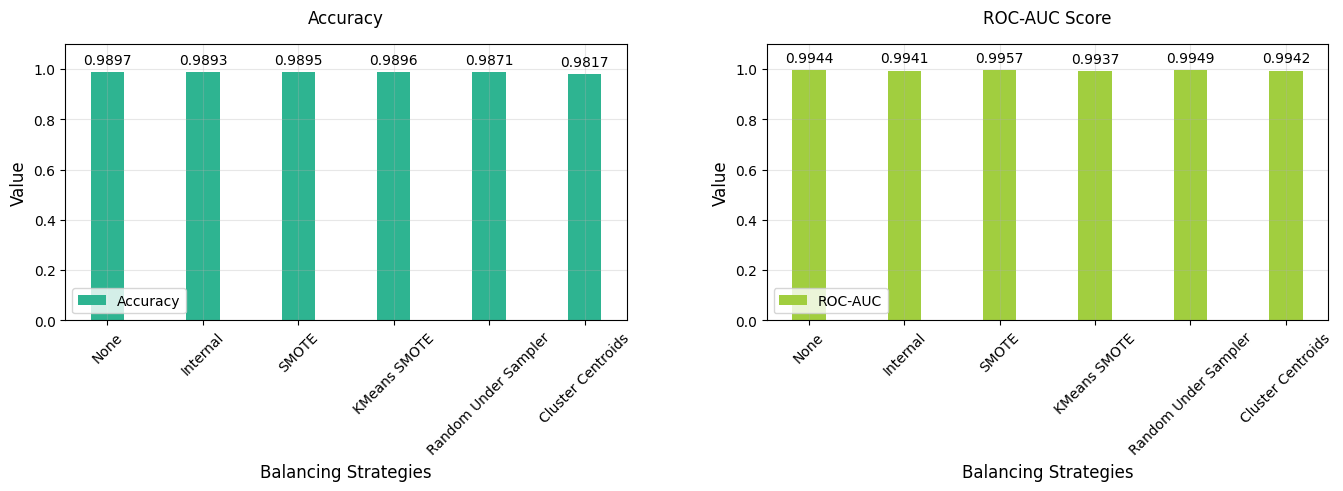

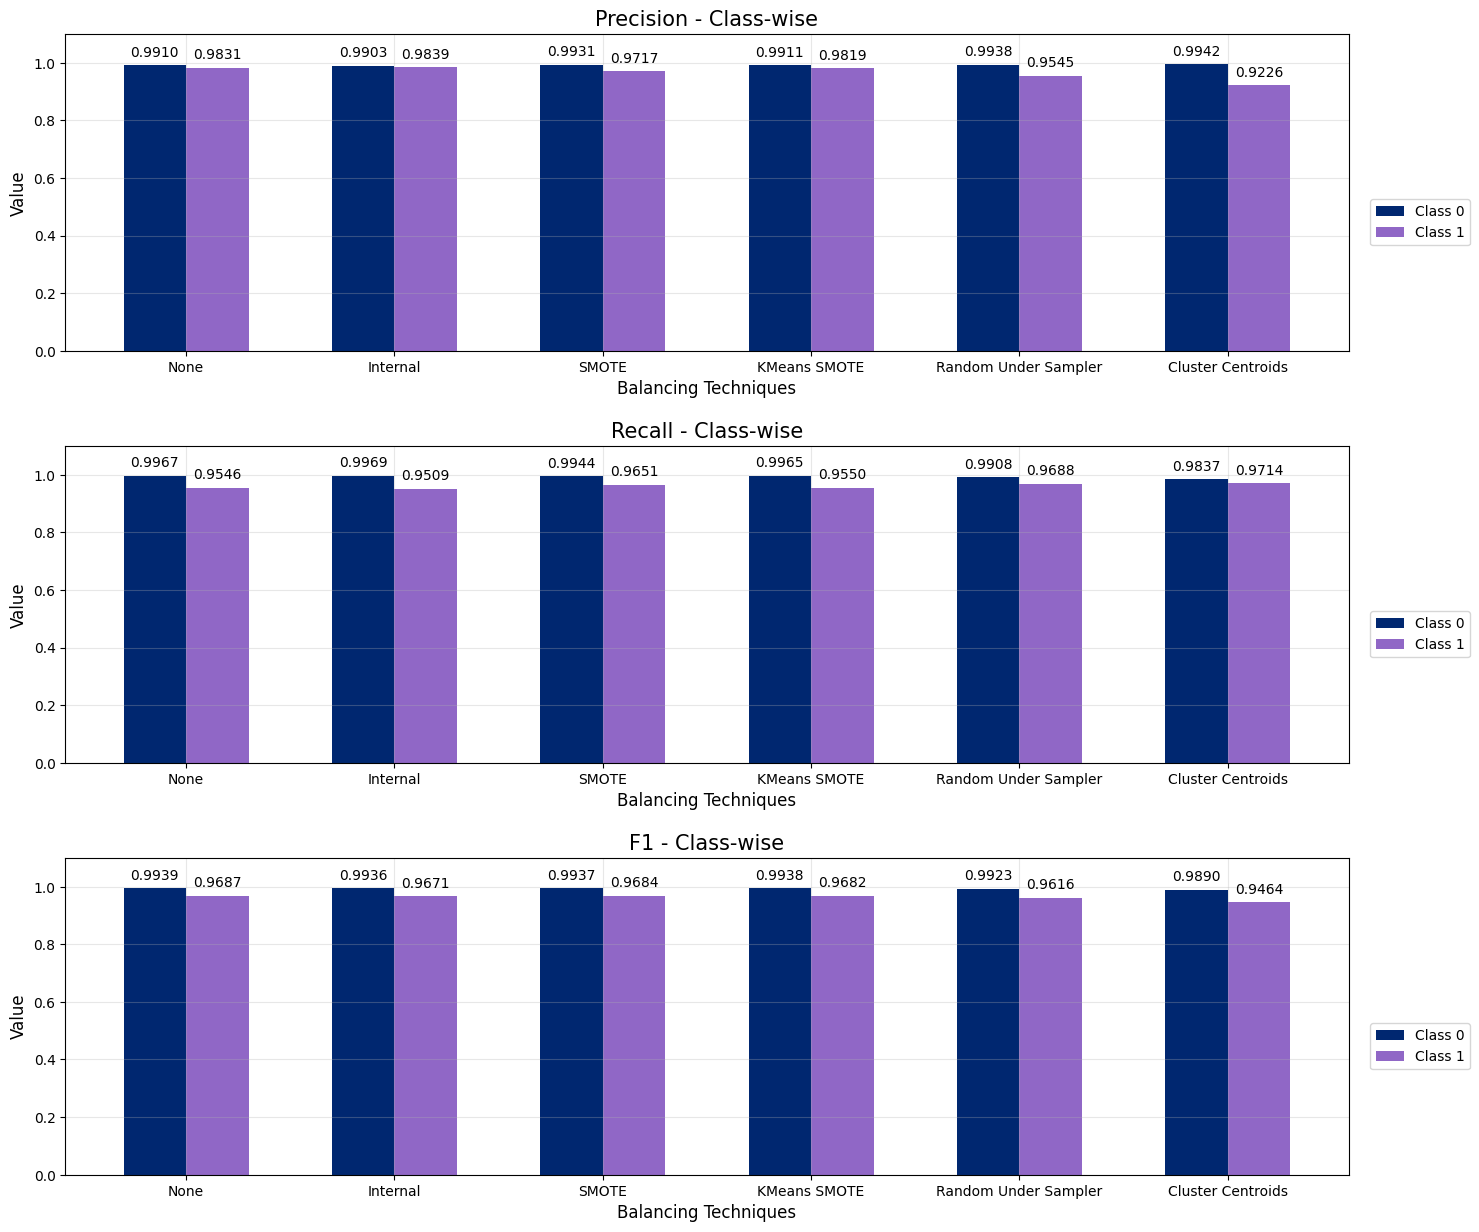

In [412]:
plot_metrics(rf2, color_map2)

##### Random Forest for dataset including **Star** and **QSO**:

In [22]:
rf_fold3 = kfold('Random Forest', models['RandomForest'], "None", X3, y3)
rf_fold_internal3 = kfold('Random Forest', models['RandomForestBalanced'], "Internal", X3, y3)
rf_fold_smote3 = kfold('Random Forest', models['RandomForest'], "SMOTE", X3, y3, balancing_methods['SMOTE'])
rf_fold_kmeanssmote3 = kfold('Random Forest', models['RandomForest'], "KMeans SMOTE", X3, y3, balancing_methods['KMeansSMOTE'])
rf_fold_rus3 = kfold('Random Forest', models['RandomForest'], "Random Under Sampler", X3, y3, balancing_methods['RandomUnderSampler'])
rf_fold_cc3 = kfold('Random Forest', models['RandomForest'], "Cluster Centroids", X3, y3, balancing_methods['ClusterCentroids'])
rf3 = pd.concat([rf_fold3, rf_fold_internal3, rf_fold_smote3, rf_fold_kmeanssmote3, rf_fold_rus3, rf_fold_cc3])
rf3

Model             Balancing  Accuracy   ROC-AUC  Precision Class 0  \
0  Random Forest                  None  0.999853  0.999887           0.999812   
0  Random Forest              Internal  0.999874  0.999882           0.999839   
0  Random Forest                 SMOTE  0.999874  0.999920           0.999839   
0  Random Forest          KMeans SMOTE  0.999874  0.999880           0.999839   
0  Random Forest  Random Under Sampler  0.999895  0.999966           0.999866   
0  Random Forest     Cluster Centroids  0.999874  0.999886           0.999839   

   Precision Class 1  Recall Class 0  Recall Class 1  F1 Class 0  F1 Class 1  
0                1.0             1.0        0.999329    0.999906    0.999664  
0                1.0             1.0        0.999424    0.999919    0.999712  
0                1.0             1.0        0.999424    0.999919    0.999712  
0                1.0             1.0        0.999424    0.999919    0.999712  
0                1.0             1.0        0.999520    0.999933    0.999760  
0                1.0             1.0        0.999424    0.999919    0.999712

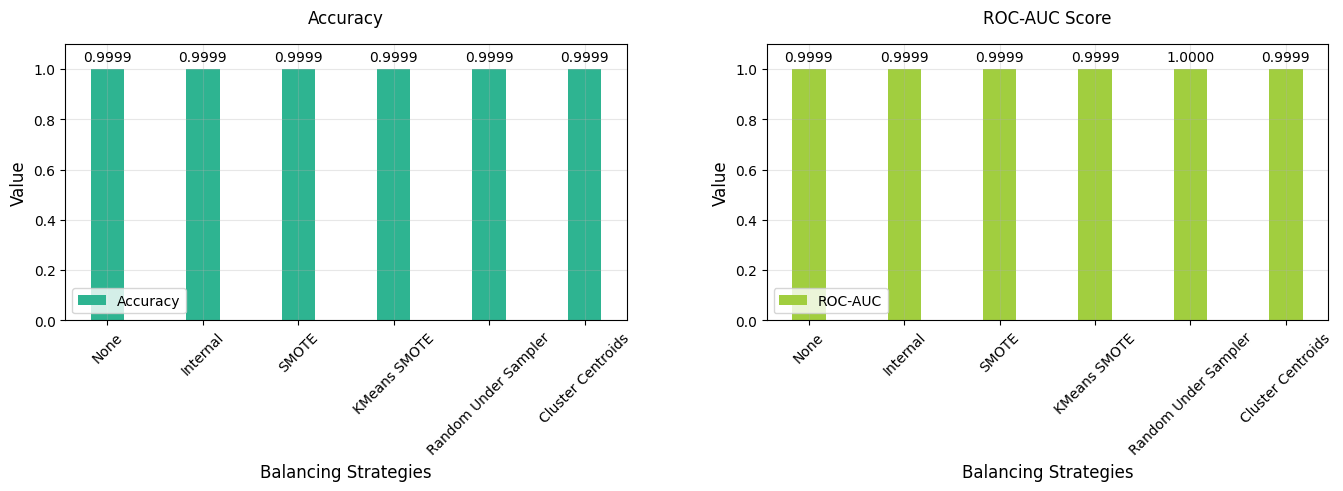

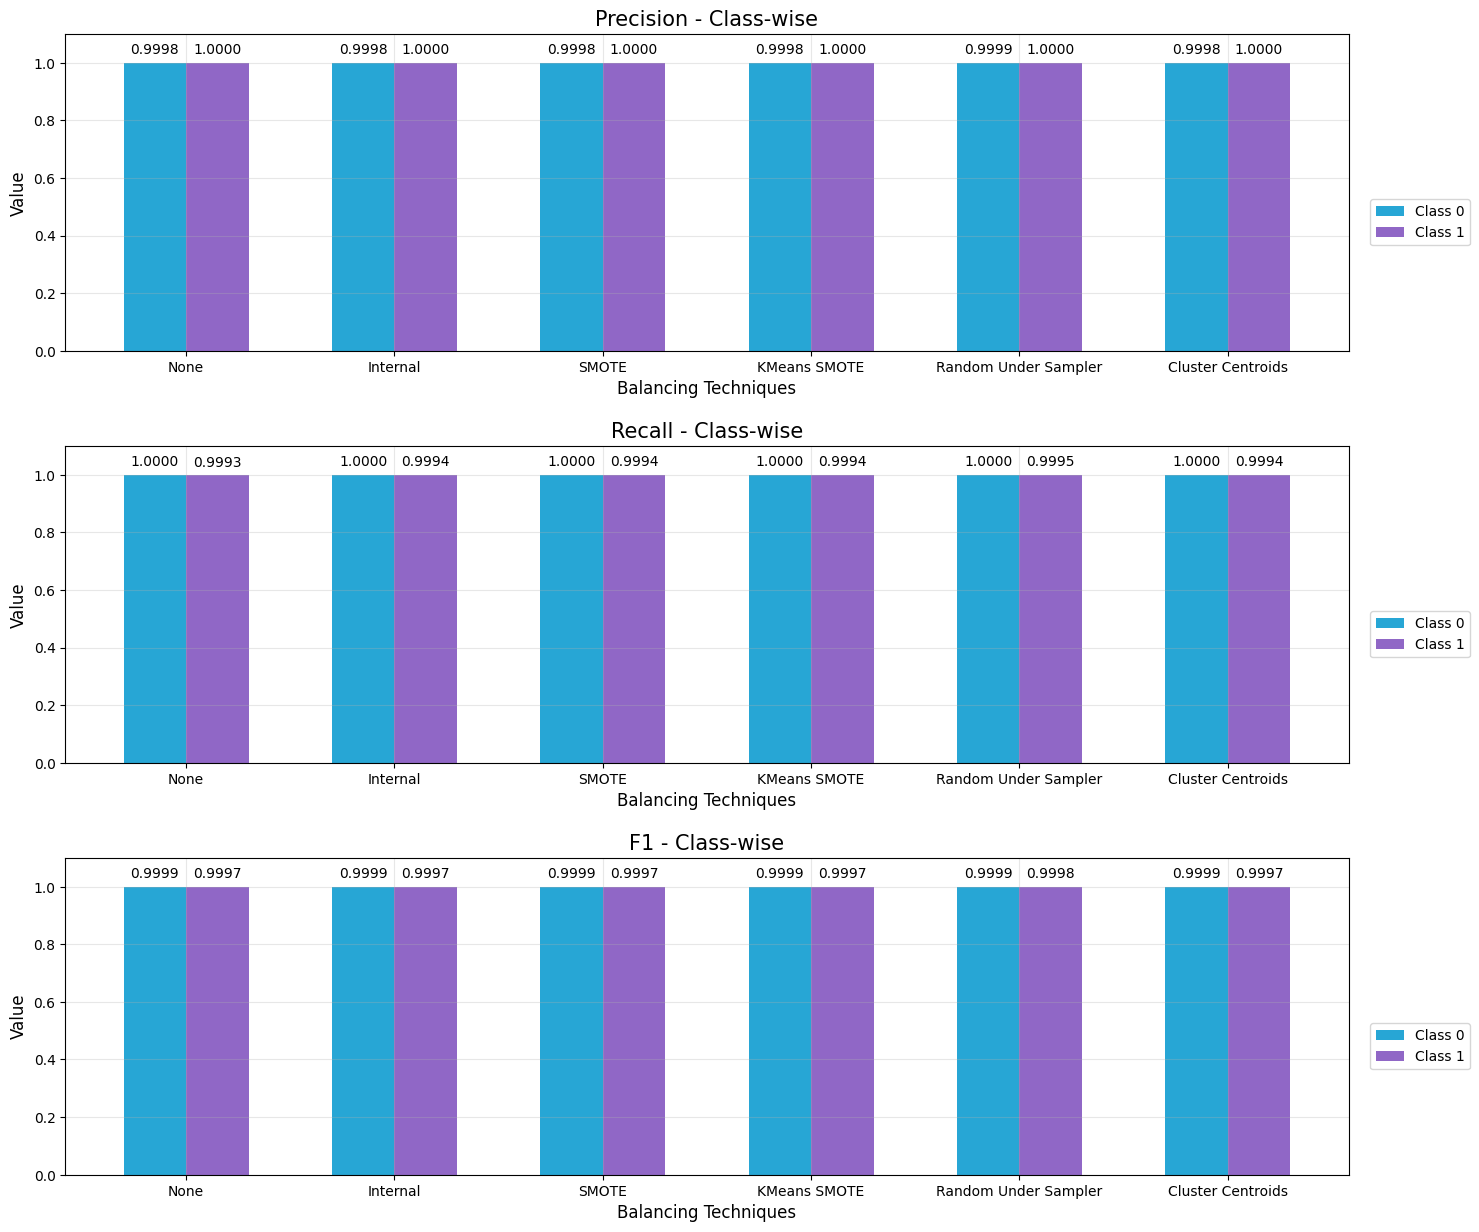

In [414]:
plot_metrics(rf3, color_map3)

##### Random Forest for dataset including **Galaxy** and **Star**:

In [23]:
rf_fold4 = kfold('Random Forest', models['RandomForest'], "None", X4, y4)
rf_fold_internal4 = kfold('Random Forest', models['RandomForestBalanced'], "Internal", X4, y4)
rf_fold_smote4 = kfold('Random Forest', models['RandomForest'], "SMOTE", X4, y4, balancing_methods['SMOTE'])
rf_fold_kmeanssmote4 = kfold('Random Forest', models['RandomForest'], "KMeans SMOTE", X4, y4, balancing_methods['KMeansSMOTE'])
rf_fold_rus4 = kfold('Random Forest', models['RandomForest'], "Random Under Sampler", X4, y4, balancing_methods['RandomUnderSampler'])
rf_fold_cc4 = kfold('Random Forest', models['RandomForest'], "Cluster Centroids", X4, y4, balancing_methods['ClusterCentroids'])
rf4 = pd.concat([rf_fold4, rf_fold_internal4, rf_fold_smote4, rf_fold_kmeanssmote4, rf_fold_rus4, rf_fold_cc4])
rf4

Model             Balancing  Accuracy   ROC-AUC  Precision Class 0  \
0  Random Forest                  None  0.997801  0.999875           0.999311   
0  Random Forest              Internal  0.998069  0.999853           0.999368   
0  Random Forest                 SMOTE  0.998113  0.999864           0.999388   
0  Random Forest          KMeans SMOTE  0.997745  0.999838           0.999349   
0  Random Forest  Random Under Sampler  0.997276  0.999879           0.999444   
0  Random Forest     Cluster Centroids  0.997745  0.999861           0.999272   

   Precision Class 1  Recall Class 0  Recall Class 1  F1 Class 0  F1 Class 1  
0           0.995692        0.996924        0.999033    0.998116    0.997359  
0           0.996251        0.997325        0.999114    0.998346    0.997680  
0           0.996331        0.997383        0.999141    0.998384    0.997734  
0           0.995504        0.996790        0.999087    0.998068    0.997292  
0           0.994254        0.995892        0.999221    0.997665    0.996731  
0           0.995610        0.996867        0.998979    0.998068    0.997292

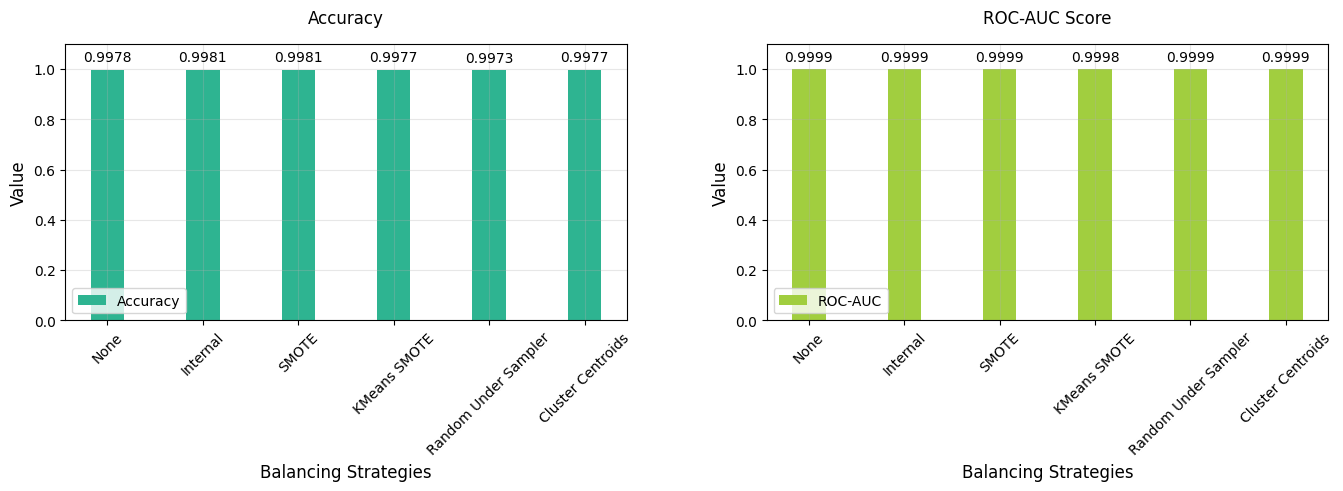

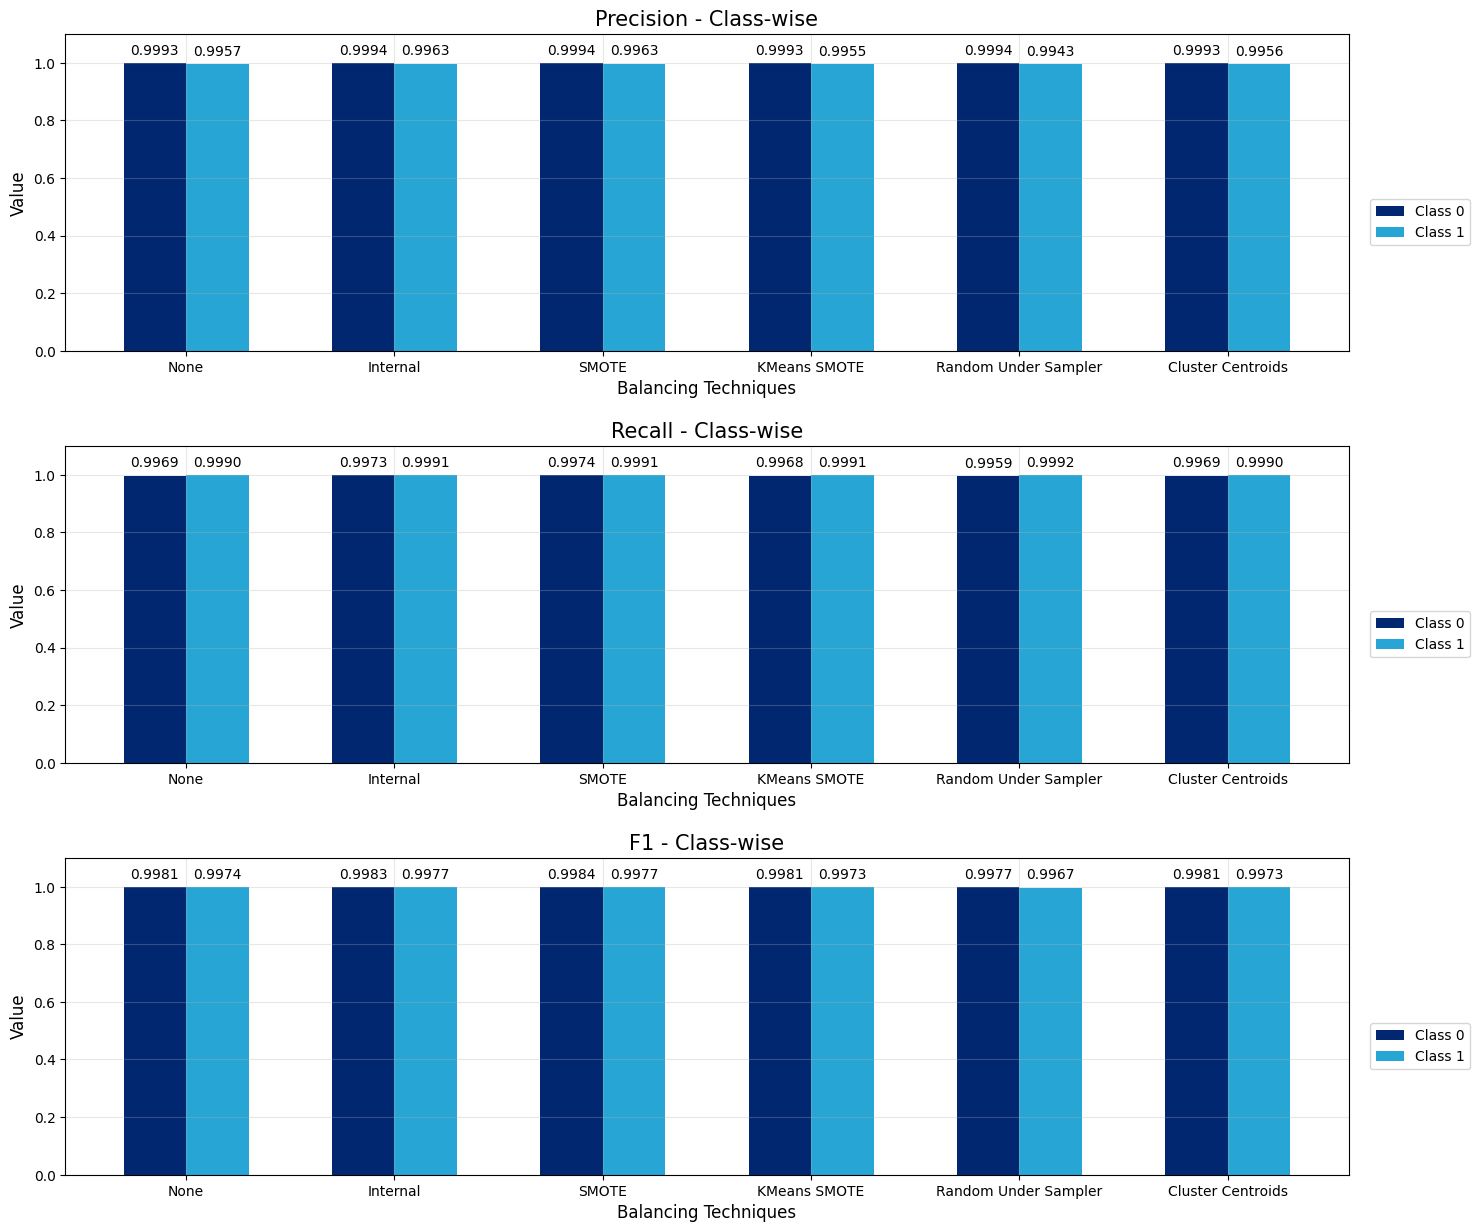

In [415]:
plot_metrics(rf4, color_map4)

## **Naive Bayes**

##### Naive Bayes for **original dataset**:

In [16]:
nv_fold = kfold('Naive Bayes', models['NaiveBayes'], "None", X, y)
nv_fold_internal = kfold('Naive Bayes', models['NaiveBayesBalanced'], "Internal", X, y)
nv_fold_smote = kfold('Naive Bayes', models['NaiveBayes'], "SMOTE", X, y, balancing_methods['SMOTE'])
nv_fold_kmeanssmote = kfold('Naive Bayes', models['NaiveBayes'], "KMeans SMOTE", X, y, balancing_methods['KMeansSMOTE'])
nv_fold_rus = kfold('Naive Bayes', models['NaiveBayes'], "Random Under Sampler", X, y, balancing_methods['RandomUnderSampler'])
nv_fold_cc = kfold('Naive Bayes', models['NaiveBayes'], "Cluster Centroids", X, y, balancing_methods['ClusterCentroids'])
nv = pd.concat([nv_fold, nv_fold_internal, nv_fold_smote, nv_fold_kmeanssmote, nv_fold_rus, nv_fold_cc])
nv

Model             Balancing  Accuracy   ROC-AUC  Precision Class 0  \
0  Naive Bayes                  None  0.576639  0.978628           0.979313   
0  Naive Bayes              Internal  0.549129  0.975186           0.979122   
0  Naive Bayes                 SMOTE  0.584249  0.974331           0.978824   
0  Naive Bayes          KMeans SMOTE  0.751730  0.972374           0.979146   
0  Naive Bayes  Random Under Sampler  0.801511  0.986067           0.984133   
0  Naive Bayes     Cluster Centroids  0.441320  0.916116           0.978206   

   Precision Class 1  Precision Class 2  Recall Class 0  Recall Class 1  \
0           0.994003           0.199433        0.483061        0.594975   
0           0.993988           0.188971        0.443190        0.576604   
0           0.993920           0.202289        0.508413        0.580014   
0           0.993773           0.298270        0.786981        0.644045   
0           0.994803           0.390861        0.801733        0.755134   
0           0.993510           0.156841        0.313851        0.468417   

   Recall Class 2  F1 Class 0  F1 Class 1  F1 Class 2  
0        0.981007    0.636975    0.740755    0.330903  
0        0.982926    0.601267    0.726355    0.316605  
0        0.980144    0.661098    0.730236    0.334813  
0        0.959329    0.871054    0.779792    0.454431  
0        0.966043    0.878030    0.853303    0.544275  
0        0.984556    0.469792    0.632999    0.270470

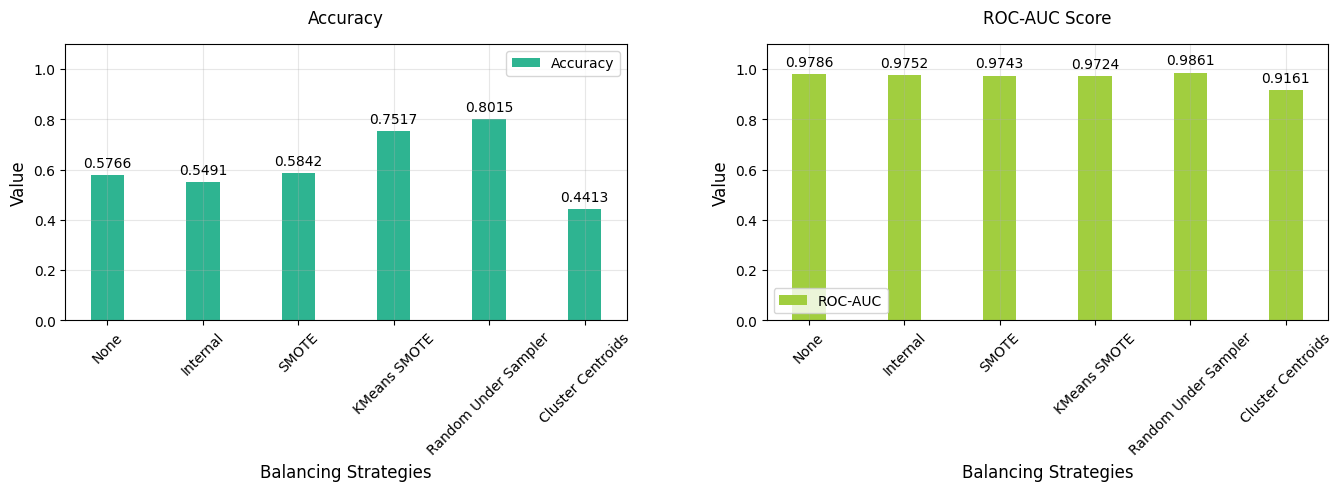

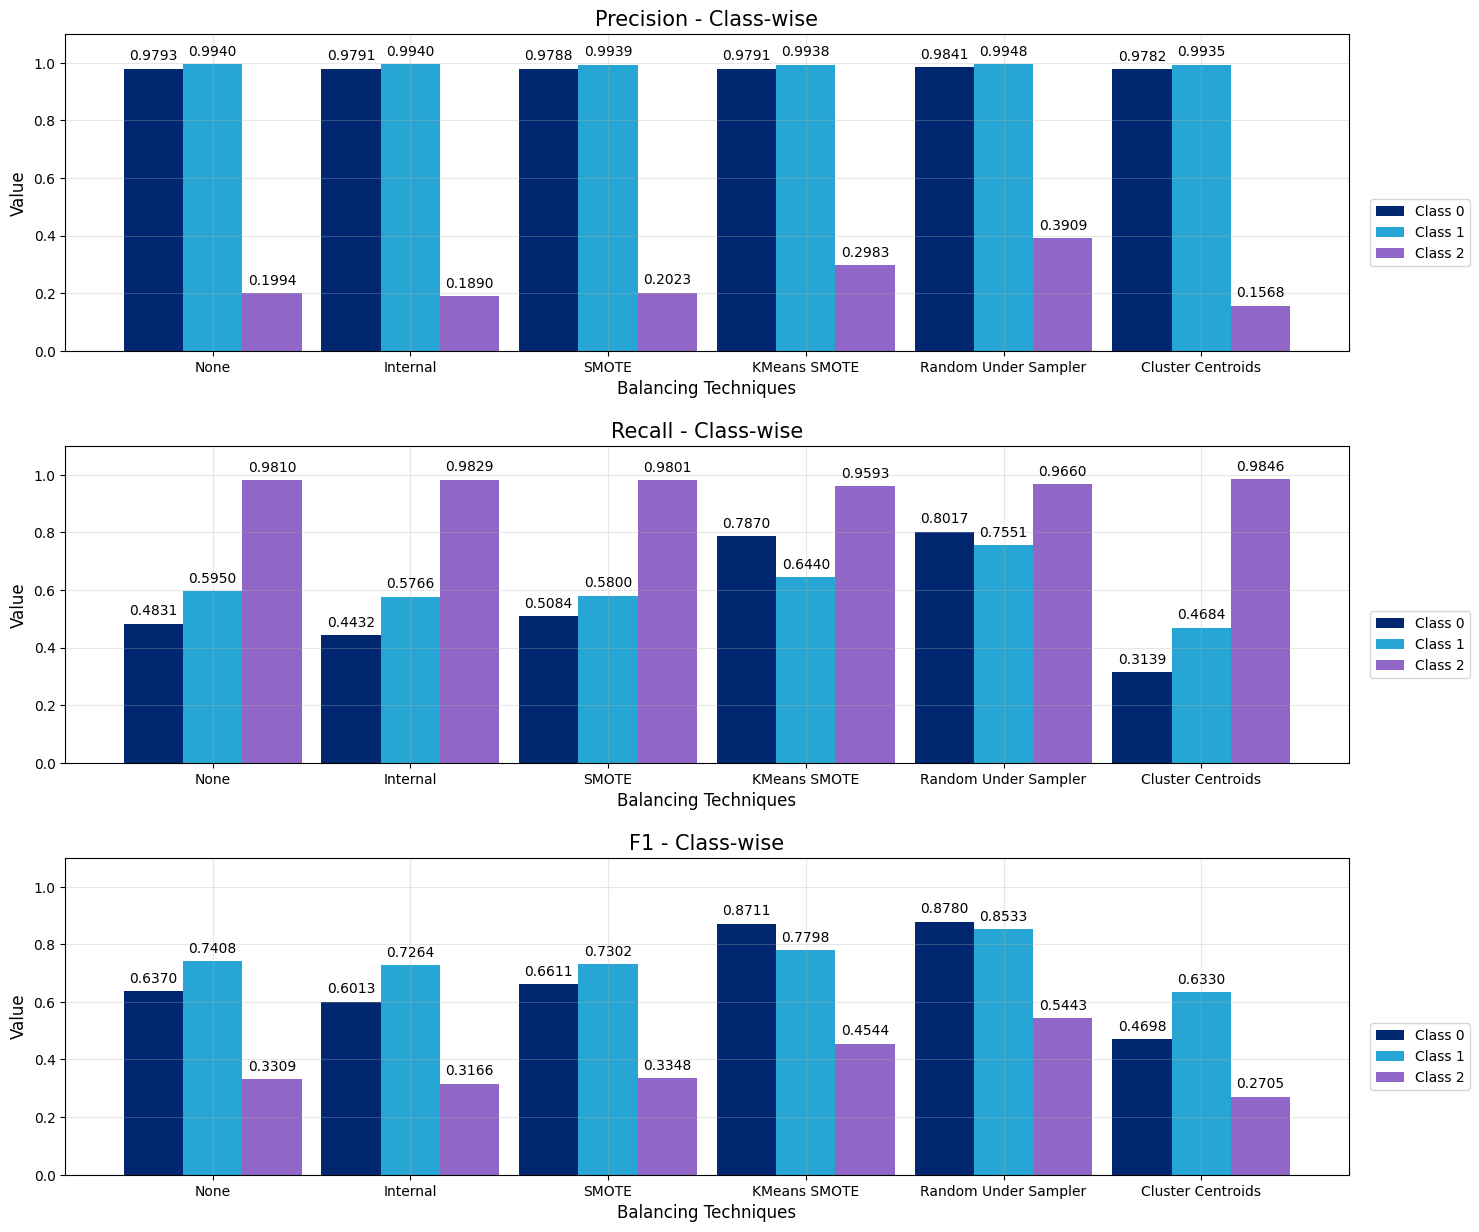

In [411]:
plot_metrics(nv, color_map)

##### Naive Bayes for dataset including **Galaxy** and **QSO**:

In [17]:
nv_fold2 = kfold('Naive Bayes', models['NaiveBayes'], "None", X2, y2)
nv_fold_internal2 = kfold('Naive Bayes', models['BinaryNaiveBayesBalanced2'], "Internal", X2, y2)
nv_fold_smote2 = kfold('Naive Bayes', models['NaiveBayes'], "SMOTE", X2, y2, balancing_methods['SMOTE'])
nv_fold_kmeanssmote2 = kfold('Naive Bayes', models['NaiveBayes'], "KMeans SMOTE", X2, y2, balancing_methods['KMeansSMOTE'])
nv_fold_rus2 = kfold('Naive Bayes', models['NaiveBayes'], "Random Under Sampler", X2, y2, balancing_methods['RandomUnderSampler'])
nv_fold_cc2 = kfold('Naive Bayes', models['NaiveBayes'], "Cluster Centroids", X2, y2, balancing_methods['ClusterCentroids'])
nv2 = pd.concat([nv_fold2, nv_fold_internal2, nv_fold_smote2, nv_fold_kmeanssmote2, nv_fold_rus2, nv_fold_cc2])
nv2

Model             Balancing  Accuracy   ROC-AUC  Precision Class 0  \
0  Naive Bayes                  None  0.617193  0.950478           0.991931   
0  Naive Bayes              Internal  0.582558  0.939833           0.991692   
0  Naive Bayes                 SMOTE  0.635116  0.944075           0.992063   
0  Naive Bayes          KMeans SMOTE  0.856535  0.962522           0.989770   
0  Naive Bayes  Random Under Sampler  0.849286  0.976943           0.991568   
0  Naive Bayes     Cluster Centroids  0.464871  0.846989           0.990646   

   Precision Class 1  Recall Class 0  Recall Class 1  F1 Class 0  F1 Class 1  
0           0.331978        0.545363        0.977842    0.685148    0.485113  
0           0.302748        0.503581        0.979089    0.650814    0.456040  
0           0.332665        0.566990        0.977170    0.708924    0.489218  
0           0.546300        0.836578        0.956739    0.906124    0.693238  
0           0.541305        0.826338        0.964508    0.900179    0.688352  
0           0.239384        0.361538        0.983693    0.518938    0.383870

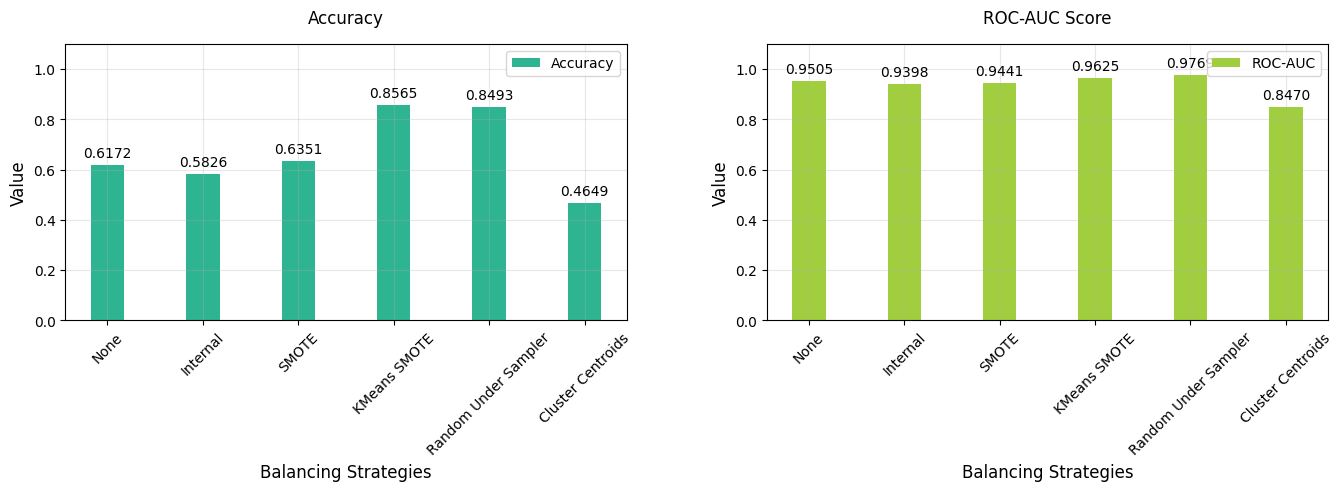

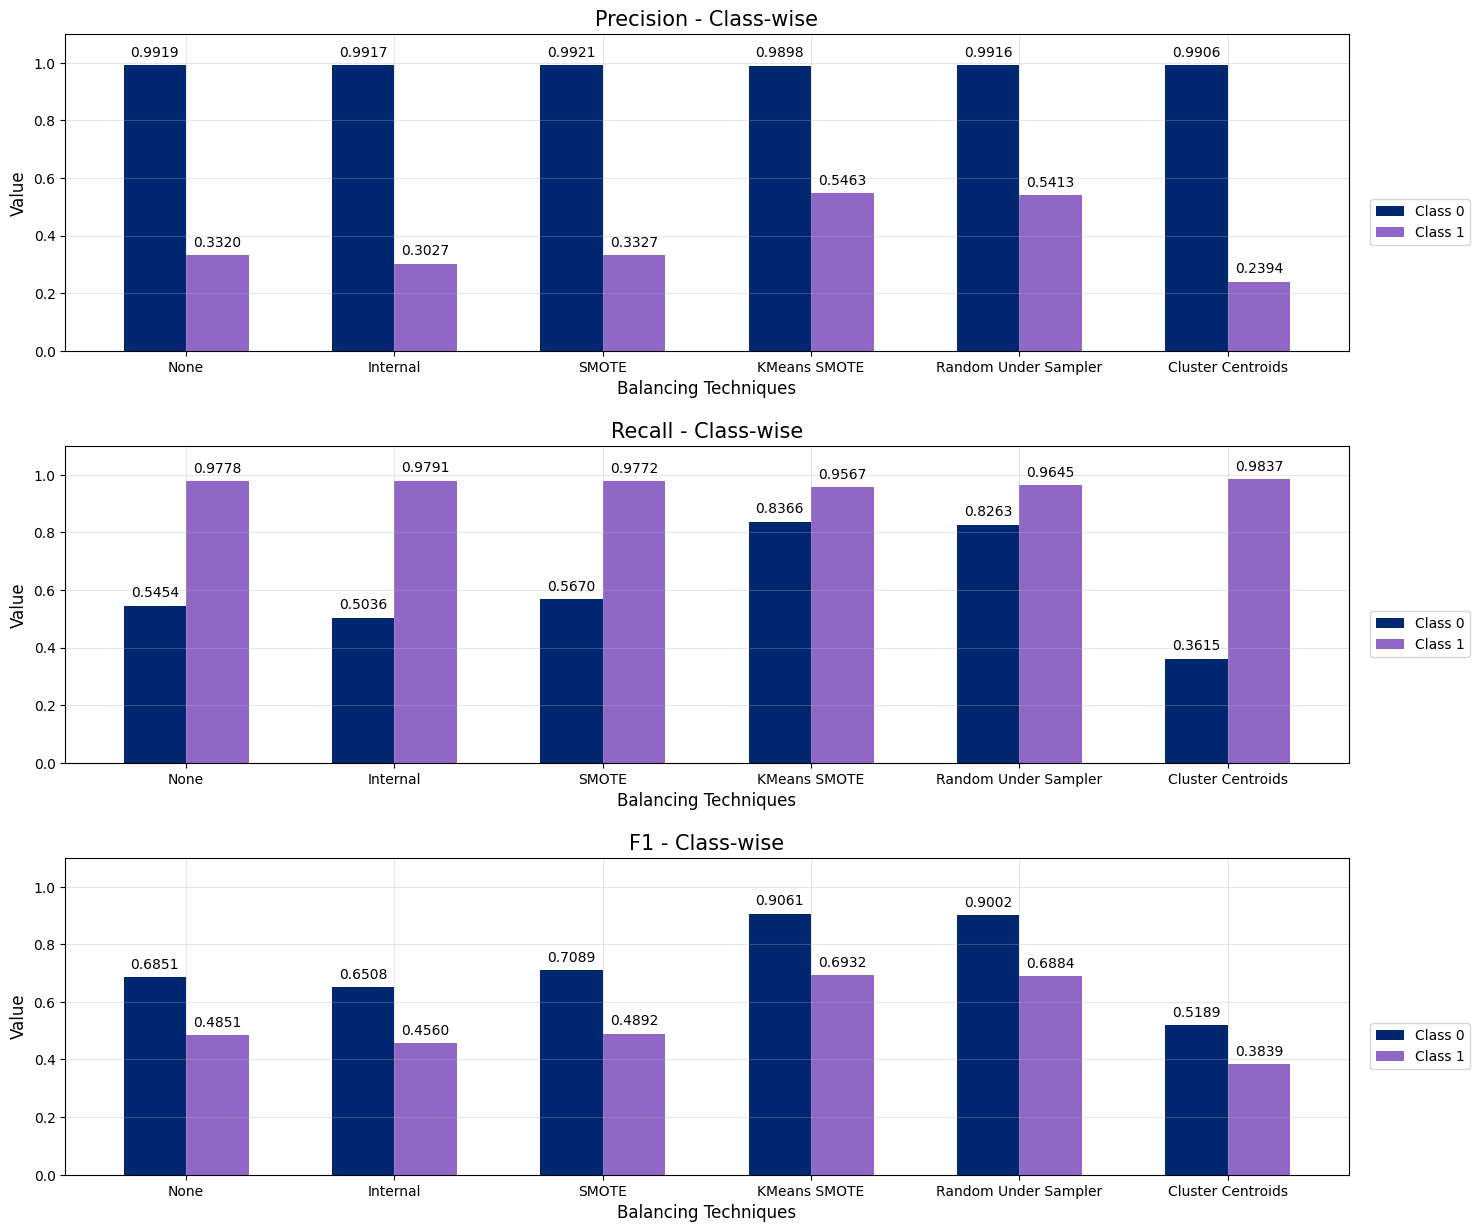

In [410]:
plot_metrics(nv2, color_map2)

##### Naive Bayes for dataset including **Star** and **QSO**:

In [18]:
nv_fold3 = kfold('Naive Bayes', models['NaiveBayes'], "None", X3, y3)
nv_fold_internal3 = kfold('Naive Bayes', models['BinaryNaiveBayesBalanced3'], "Internal", X3, y3)
nv_fold_smote3 = kfold('Naive Bayes', models['NaiveBayes'], "SMOTE", X3, y3, balancing_methods['SMOTE'])
nv_fold_kmeanssmote3 = kfold('Naive Bayes', models['NaiveBayes'], "KMeans SMOTE", X3, y3, balancing_methods['KMeansSMOTE'] )
nv_fold_rus3 = kfold('Naive Bayes', models['NaiveBayes'], "Random Under Sampler", X3, y3, balancing_methods['RandomUnderSampler'])
nv_fold_cc3 = kfold('Naive Bayes', models['NaiveBayes'], "Cluster Centroids", X3, y3, balancing_methods['ClusterCentroids'])
nv3 = pd.concat([nv_fold3, nv_fold_internal3, nv_fold_smote3, nv_fold_kmeanssmote3, nv_fold_rus3, nv_fold_cc3])
nv3

Model             Balancing  Accuracy   ROC-AUC  Precision Class 0  \
0  Naive Bayes                  None  0.711126  0.989945           0.999789   
0  Naive Bayes              Internal  0.687792  0.981729           0.999824   
0  Naive Bayes                 SMOTE  0.692346  0.978884           0.999826   
0  Naive Bayes          KMeans SMOTE  0.768388  0.975885           0.999691   
0  Naive Bayes  Random Under Sampler  0.819714  0.998255           0.999844   
0  Naive Bayes     Cluster Centroids  0.607300  0.949193           0.999843   

   Precision Class 1  Recall Class 0  Recall Class 1  F1 Class 0  F1 Class 1  
0           0.451258        0.630376        0.999520    0.764683    0.615548  
0           0.427991        0.600482        0.999616    0.742139    0.594479  
0           0.429099        0.606310        0.999616    0.748067    0.596345  
0           0.497053        0.703752        0.999233    0.823154    0.660364  
0           0.592959        0.769369        0.999520    0.861127    0.731937  
0           0.365534        0.497425        0.999712    0.656893    0.533007

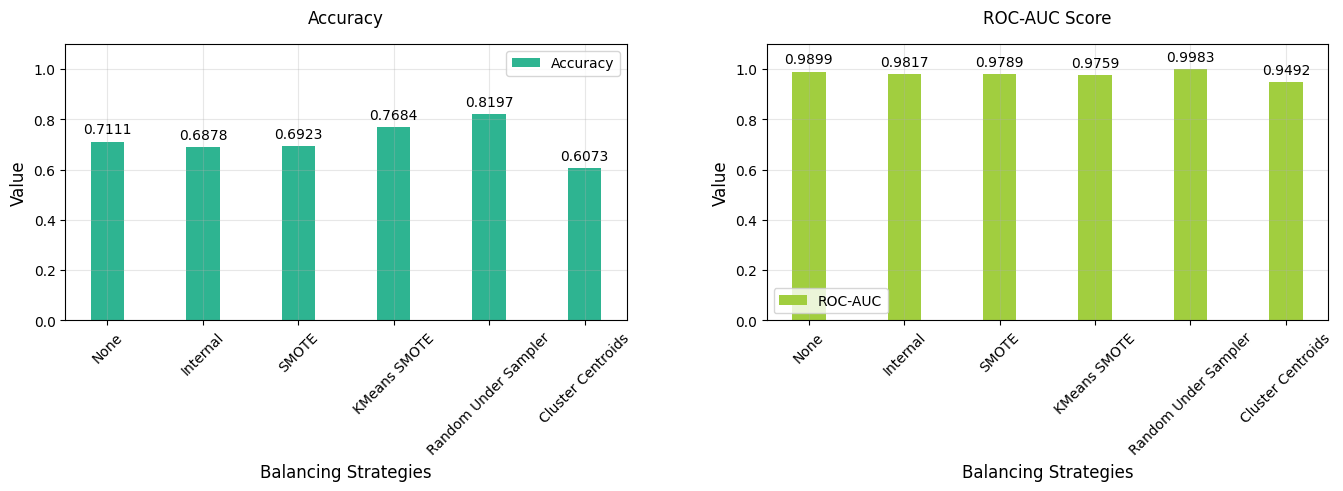

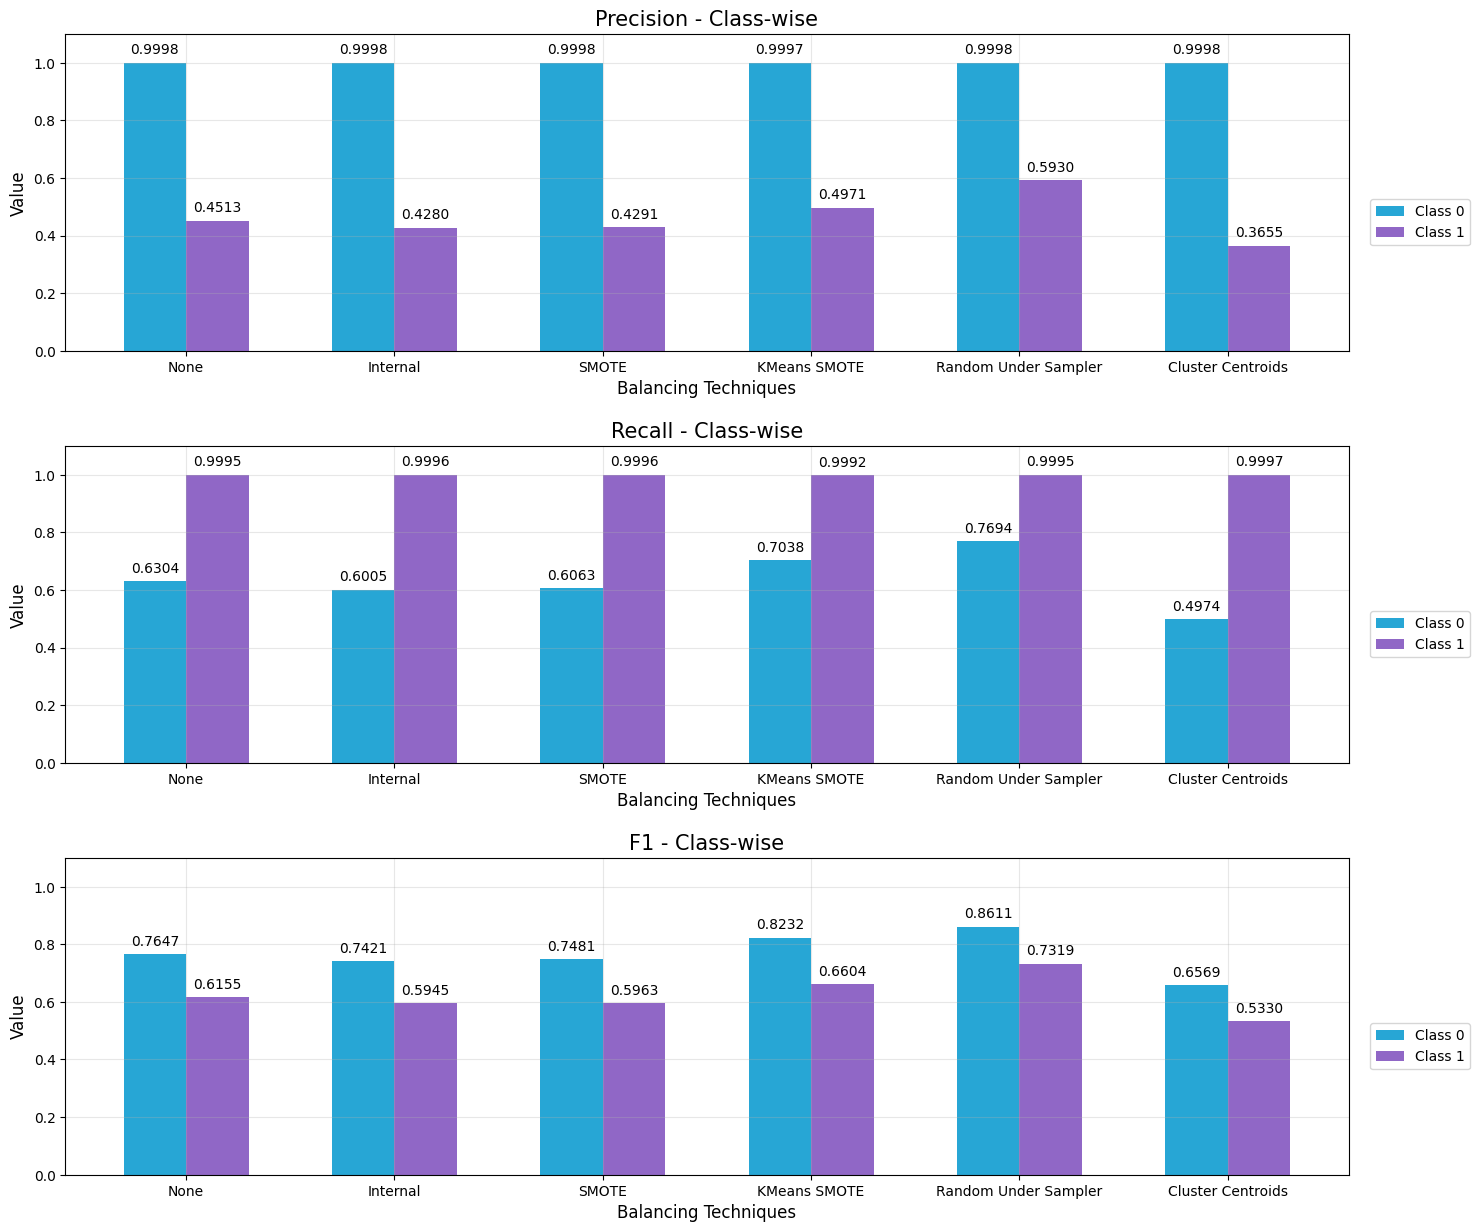

In [409]:
plot_metrics(nv3, color_map3)

##### Naive Bayes for dataset including **Galaxy** and **Star**:

In [19]:
nv_fold4 = kfold('Naive Bayes', models['NaiveBayes'], "None", X4, y4)
nv_fold_internal4 = kfold('Naive Bayes', models['BinaryNaiveBayesBalanced4'], "Internal", X4, y4)
nv_fold_smote4 = kfold('Naive Bayes', models['NaiveBayes'], "SMOTE", X4, y4, balancing_methods['SMOTE'])
nv_fold_kmeanssmote4 = kfold('Naive Bayes', models['NaiveBayes'], "KMeans SMOTE", X4, y4, balancing_methods['KMeansSMOTE'])
nv_fold_rus4 = kfold('Naive Bayes', models['NaiveBayes'], "Random Under Sampler", X4, y4, balancing_methods['RandomUnderSampler'])
nv_fold_cc4 = kfold('Naive Bayes', models['NaiveBayes'], "Cluster Centroids", X4, y4, balancing_methods['ClusterCentroids'])
nv4 = pd.concat([nv_fold4, nv_fold_internal4, nv_fold_smote4, nv_fold_kmeanssmote4, nv_fold_rus4, nv_fold_cc4])
nv4

Model             Balancing  Accuracy   ROC-AUC  Precision Class 0  \
0  Naive Bayes                  None  0.992085  0.997695           0.990680   
0  Naive Bayes              Internal  0.992230  0.997679           0.990923   
0  Naive Bayes                 SMOTE  0.991906  0.997593           0.990377   
0  Naive Bayes          KMeans SMOTE  0.990511  0.997365           0.988018   
0  Naive Bayes  Random Under Sampler  0.991772  0.997727           0.990021   
0  Naive Bayes     Cluster Centroids  0.991839  0.997535           0.990262   

   Precision Class 1  Recall Class 0  Recall Class 1  F1 Class 0  F1 Class 1  
0           0.994103        0.995835        0.986813    0.993248    0.990438  
0           0.994105        0.995835        0.987162    0.993370    0.990616  
0           0.994100        0.995835        0.986383    0.993096    0.990221  
0           0.994135        0.995873        0.982972    0.991921    0.988504  
0           0.994287        0.995969        0.985873    0.992983    0.990056  
0           0.994099        0.995835        0.986222    0.993039    0.990141

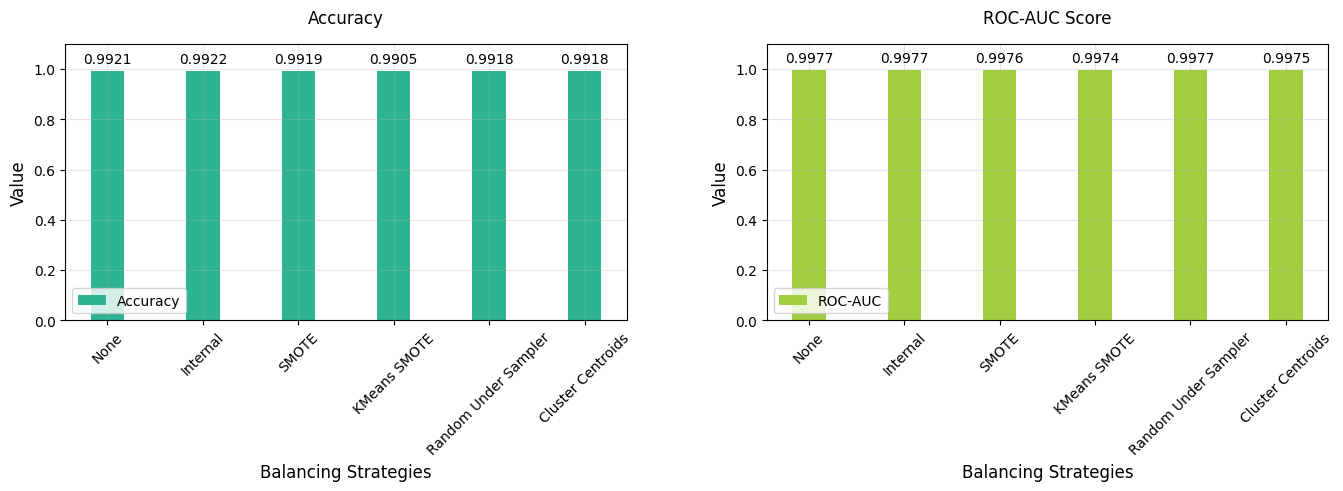

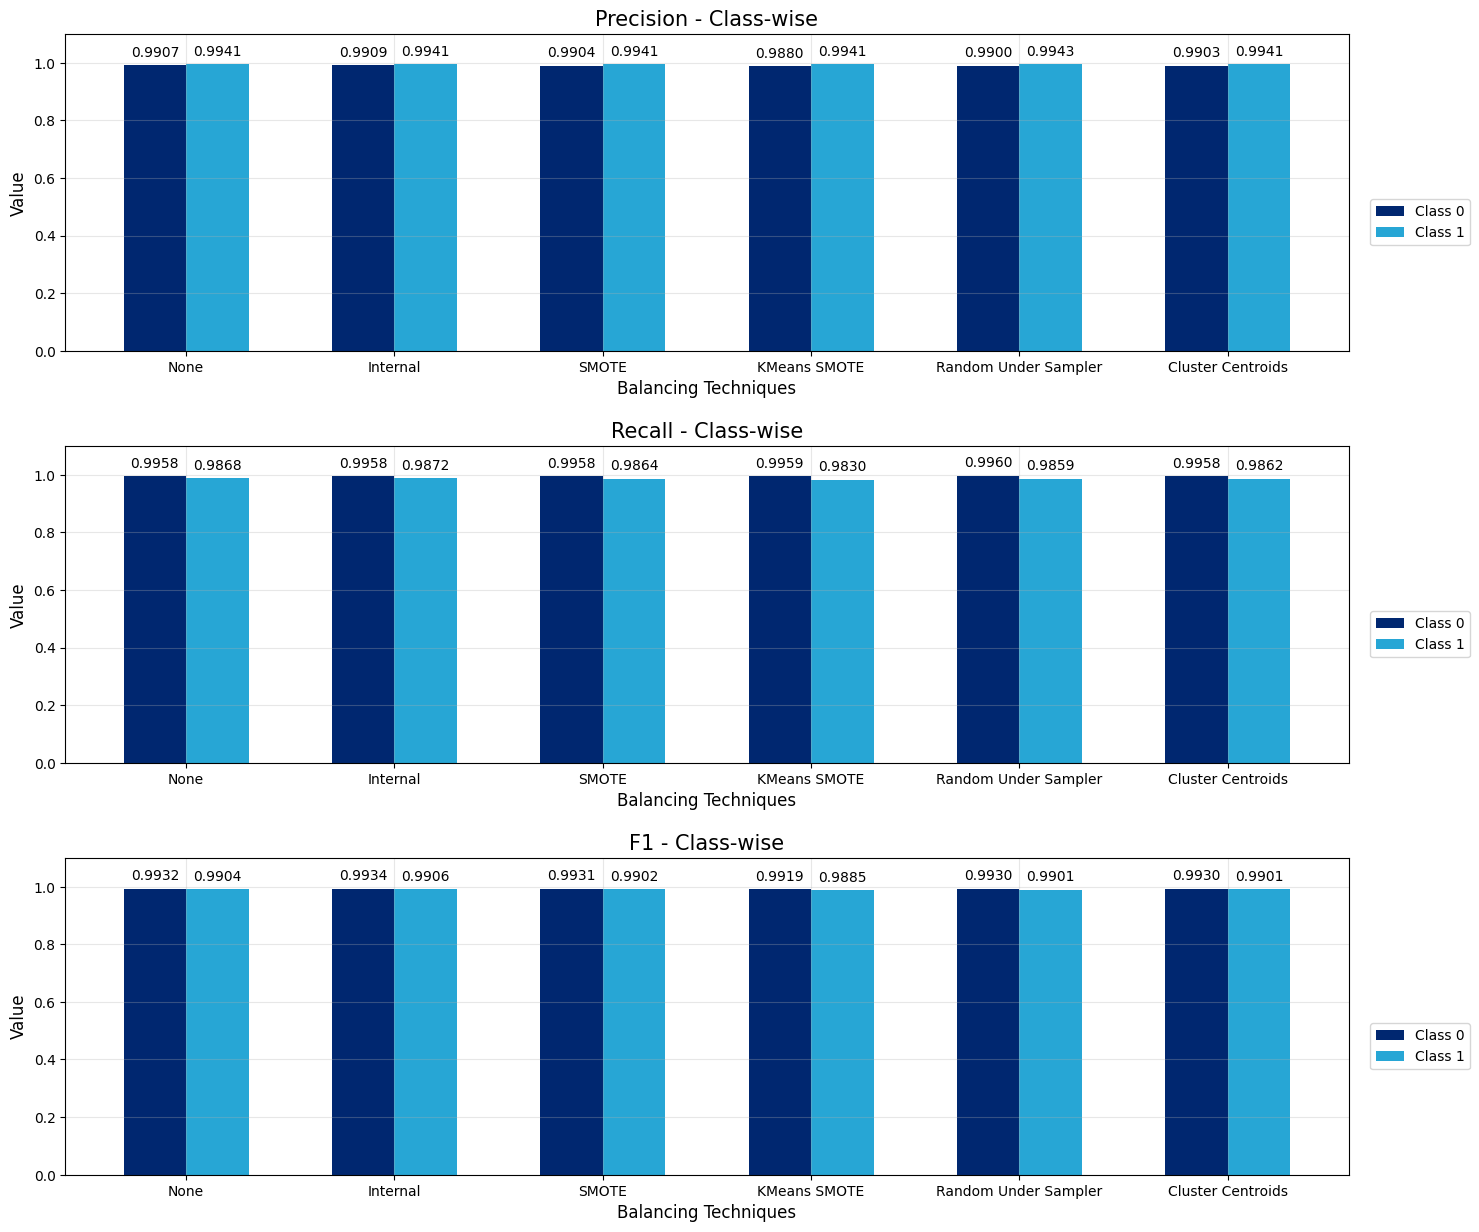

In [408]:
plot_metrics(nv4, color_map4)

## **XGBoost**

##### XGBoost for **original dataset**:

In [55]:
xgb_fold = kfold('XGBoost', models['XGBoost'], "None", X, y)
xgb_fold_internal = kfold('XGBoost', models['XGBoost'], "Internal", X, y, weights = True)
xgb_fold_smote = kfold('XGBoost', models['XGBoost'], "SMOTE", X, y, balancing_methods['SMOTE'])
xgb_fold_kmeanssmote = kfold('XGBoost', models['XGBoost'], "KMeans SMOTE", X, y, balancing_methods['KMeansSMOTE'])
xgb_fold_rus = kfold('XGBoost', models['XGBoost'], "Random Under Sampler", X, y, balancing_methods['RandomUnderSampler'])
xgb_fold_cc = kfold('XGBoost', models['XGBoost'], "Cluster Centroids", X, y, balancing_methods['ClusterCentroids'])
xgb = pd.concat([xgb_fold, xgb_fold_internal, xgb_fold_smote, xgb_fold_kmeanssmote, xgb_fold_rus, xgb_fold_cc])
xgb

Model             Balancing  Accuracy   ROC-AUC  Precision Class 0  \
0  XGBoost                  None   0.99166  0.998936           0.990516   
0  XGBoost              Internal   0.99130  0.998936           0.993065   
0  XGBoost                 SMOTE   0.99092  0.998904           0.993287   
0  XGBoost          KMeans SMOTE   0.99177  0.998952           0.991154   
0  XGBoost  Random Under Sampler   0.98948  0.998888           0.993440   
0  XGBoost     Cluster Centroids   0.98258  0.998540           0.992390   

   Precision Class 1  Precision Class 2  Recall Class 0  Recall Class 1  \
0           0.996166           0.981077        0.993676        0.997717   
0           0.994943           0.969398        0.990390        0.998711   
0           0.995023           0.964540        0.989435        0.998738   
0           0.995261           0.982149        0.993237        0.998415   
0           0.995127           0.950450        0.986512        0.998174   
0           0.997015           0.891478        0.974285        0.995864   

   Recall Class 2  F1 Class 0  F1 Class 1  F1 Class 2  
0        0.959904    0.992094    0.996941    0.970375  
0        0.969400    0.991726    0.996823    0.969399  
0        0.970456    0.991357    0.996877    0.967487  
0        0.960671    0.992194    0.996836    0.971292  
0        0.973333    0.989964    0.996648    0.961753  
0        0.976787    0.983254    0.996439    0.932173

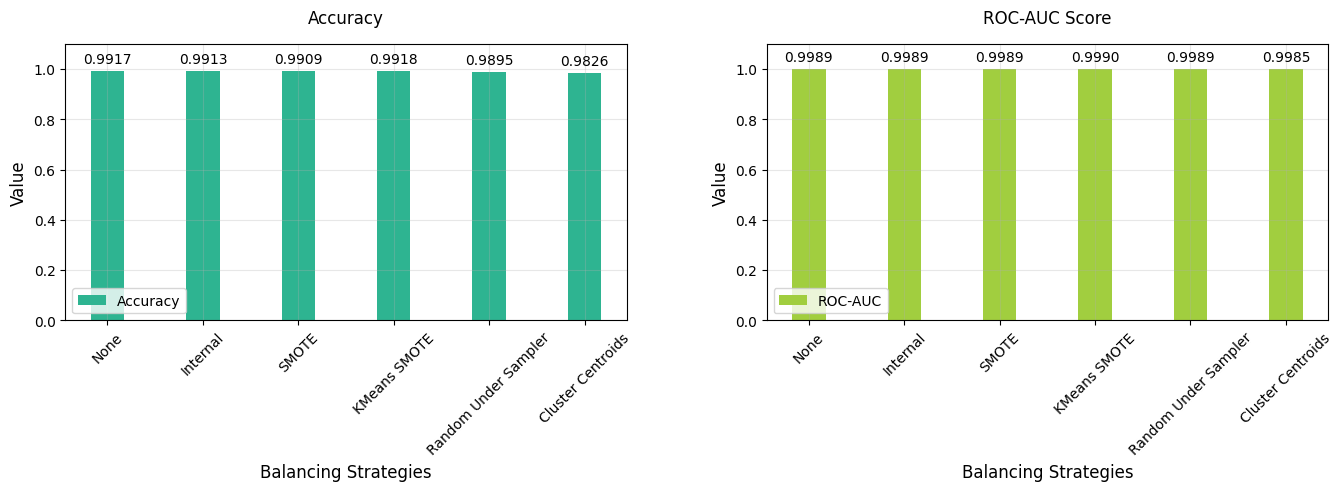

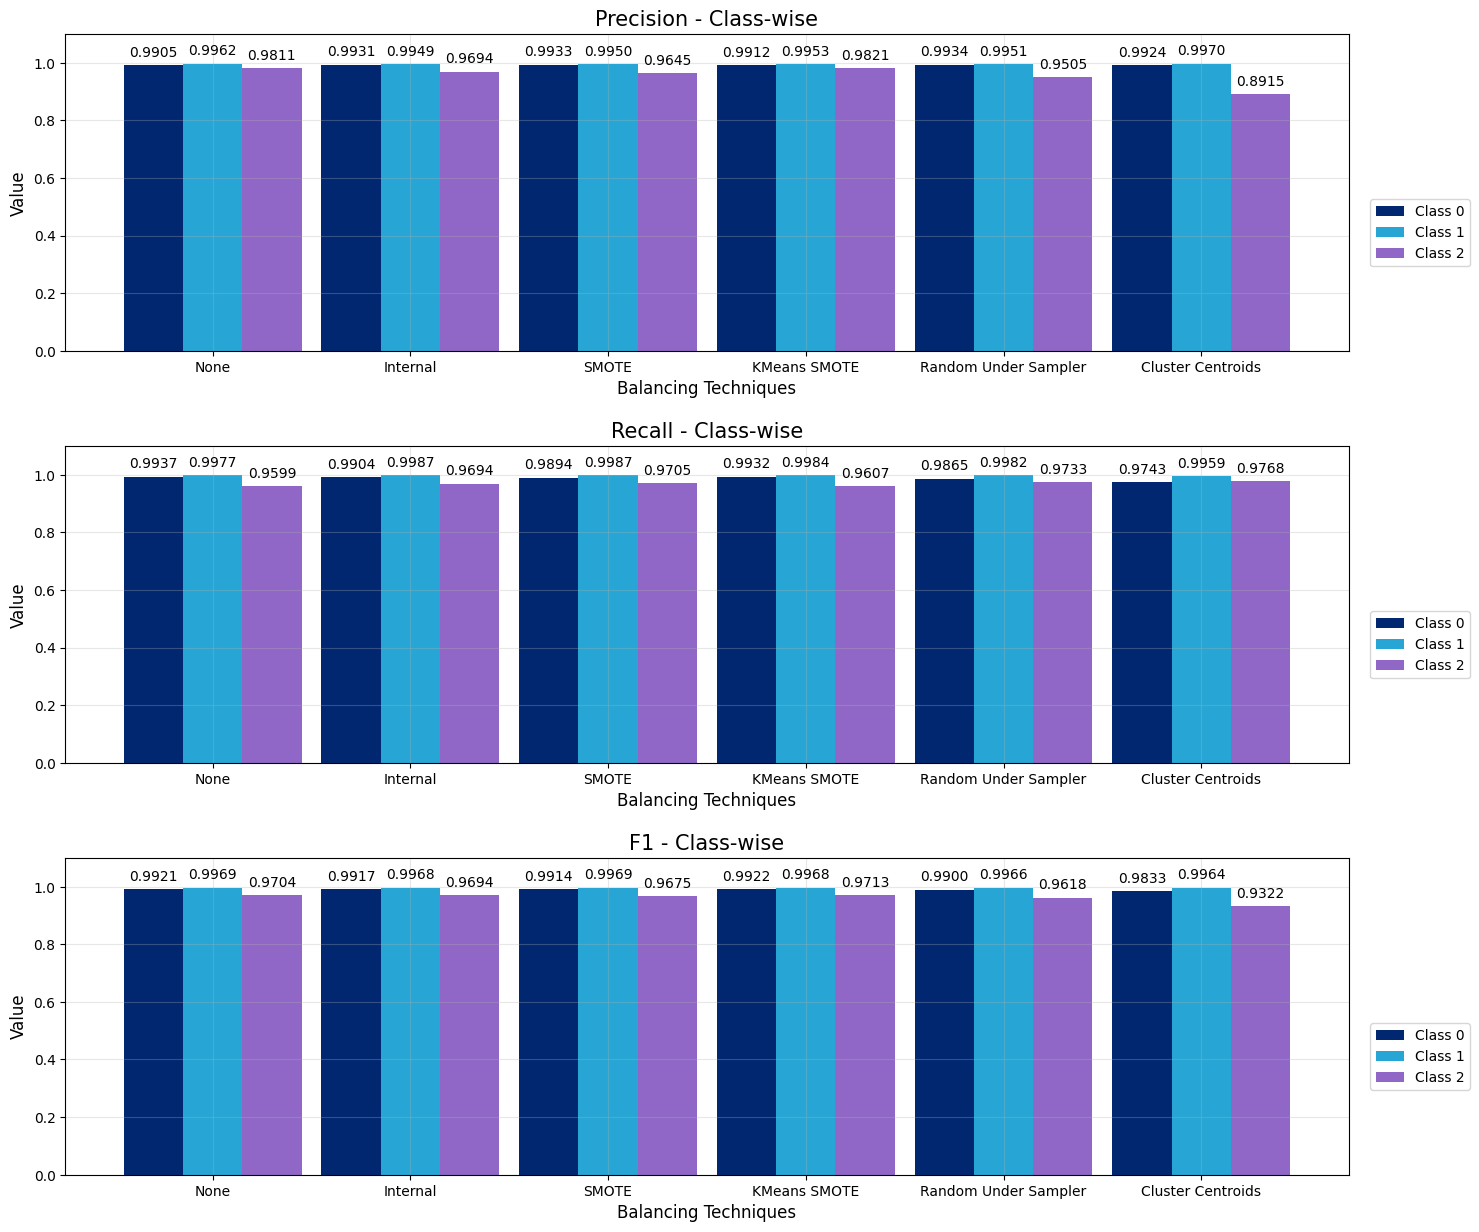

In [407]:
plot_metrics(xgb, color_map)

##### XGBoost for dataset including **Galaxy** and **QSO**:

In [49]:
xgb_fold2 = kfold('XGBoost', models['BinaryXGBoost'], "None", X2, y2)
xgb_fold_internal2 = kfold('XGBoost', models['BinaryXGBoost'], "Internal", X2, y2, weights = True)
xgb_fold_smote2 = kfold('XGBoost', models['BinaryXGBoost'], "SMOTE", X2, y2, balancing_methods['SMOTE'])
xgb_fold_kmeanssmote2 = kfold('XGBoost', models['BinaryXGBoost'], "KMeans SMOTE", X2, y2, balancing_methods['KMeansSMOTE'])
xgb_fold_rus2 = kfold('XGBoost', models['BinaryXGBoost'], "Random Under Sampler", X2, y2, balancing_methods['RandomUnderSampler'])
xgb_fold_cc2 = kfold('XGBoost', models['BinaryXGBoost'], "Cluster Centroids", X2, y2, balancing_methods['ClusterCentroids'])
xgb2 = pd.concat([xgb_fold2, xgb_fold_internal2, xgb_fold_smote2, xgb_fold_kmeanssmote2, xgb_fold_rus2, xgb_fold_cc2])
xgb2

Model             Balancing  Accuracy   ROC-AUC  Precision Class 0  \
0  XGBoost                  None  0.990712  0.996646           0.992315   
0  XGBoost              Internal  0.990138  0.996646           0.993795   
0  XGBoost                 SMOTE  0.989485  0.996612           0.994225   
0  XGBoost          KMeans SMOTE  0.990457  0.996564           0.992256   
0  XGBoost  Random Under Sampler  0.988195  0.996578           0.994841   
0  XGBoost     Cluster Centroids  0.977998  0.995606           0.994951   

   Precision Class 1  Recall Class 0  Recall Class 1  F1 Class 0  F1 Class 1  
0           0.982457        0.996580        0.961247    0.994443    0.971732  
0           0.971731        0.994383        0.968825    0.994089    0.970268  
0           0.965850        0.993160        0.971031    0.993692    0.968428  
0           0.981200        0.996332        0.960959    0.994290    0.970971  
0           0.955599        0.990983        0.974197    0.992908    0.964804  
0           0.900760        0.978584        0.975060    0.986698    0.936408

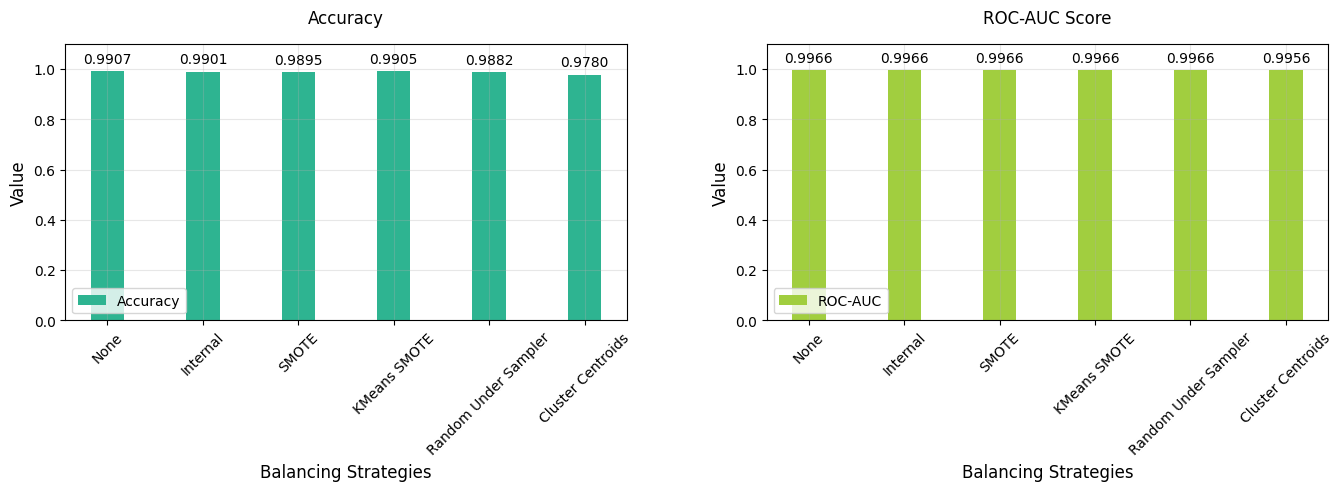

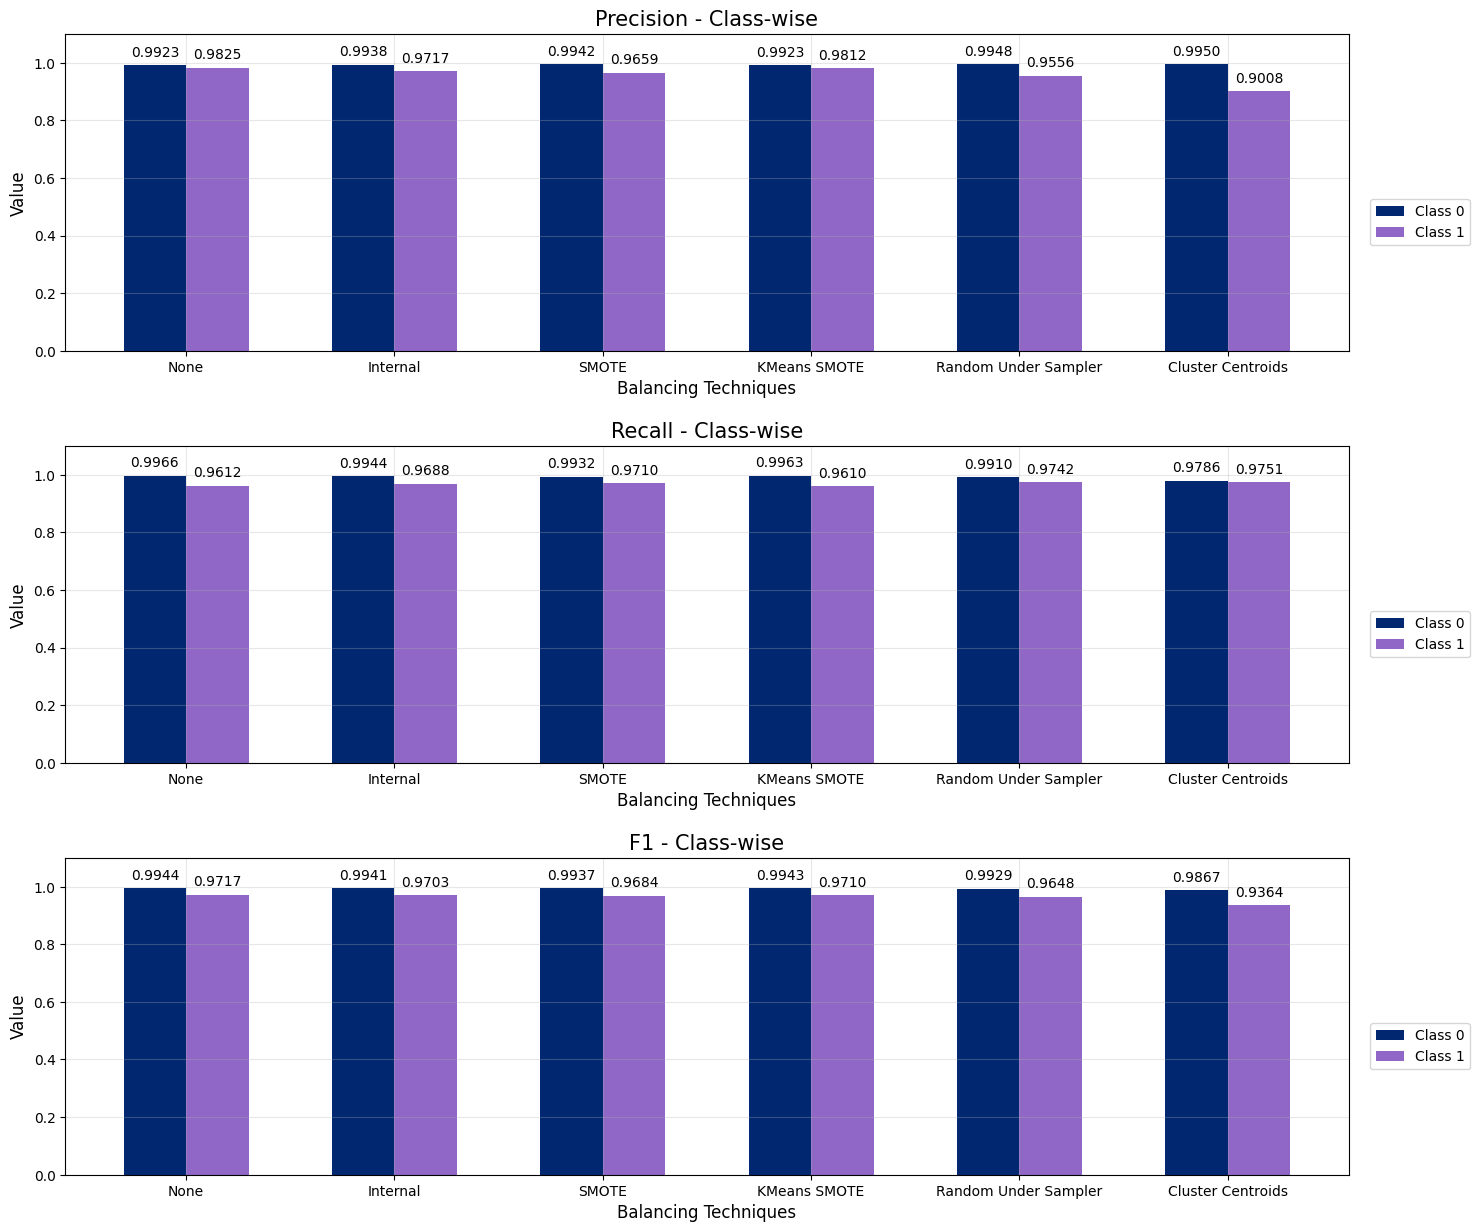

In [405]:
plot_metrics(xgb2, color_map2)

##### XGBoost for dataset including **Star** and **QSO**:

In [51]:
xgb_fold3 = kfold('XGBoost', models['BinaryXGBoost'], "None", X3, y3)
xgb_fold_internal3 = kfold('XGBoost', models['BinaryXGBoost'], "Internal", X3, y3, weights = True)
xgb_fold_smote3 = kfold('XGBoost', models['BinaryXGBoost'], "SMOTE", X3, y3, balancing_methods['SMOTE'])
xgb_fold_kmeanssmote3 = kfold('XGBoost', models['BinaryXGBoost'], "KMeans SMOTE", X3, y3, balancing_methods['KMeansSMOTE'])
xgb_fold_rus3 = kfold('XGBoost', models['BinaryXGBoost'], "Random Under Sampler", X3, y3, balancing_methods['RandomUnderSampler'])
xgb_fold_cc3 = kfold('XGBoost', models['BinaryXGBoost'], "Cluster Centroids", X3, y3, balancing_methods['ClusterCentroids'])
xgb3 = pd.concat([xgb_fold3, xgb_fold_internal3, xgb_fold_smote3, xgb_fold_kmeanssmote3, xgb_fold_rus3, xgb_fold_cc3])
xgb3

Model             Balancing  Accuracy   ROC-AUC  Precision Class 0  \
0  XGBoost                  None  0.999727  0.999985           0.999839   
0  XGBoost              Internal  0.999832  0.999985           0.999785   
0  XGBoost                 SMOTE  0.999811  0.999988           0.999758   
0  XGBoost          KMeans SMOTE  0.999727  0.999986           0.999758   
0  XGBoost  Random Under Sampler  0.999517  0.999984           0.999812   
0  XGBoost     Cluster Centroids  0.999601  0.999988           0.999785   

   Precision Class 1  Recall Class 0  Recall Class 1  F1 Class 0  F1 Class 1  
0           0.999329        0.999812        0.999424    0.999825    0.999377  
0           1.000000        1.000000        0.999233    0.999893    0.999616  
0           1.000000        1.000000        0.999137    0.999879    0.999568  
0           0.999616        0.999893        0.999137    0.999825    0.999376  
0           0.998471        0.999570        0.999329    0.999691    0.998898  
0           0.998947        0.999705        0.999233    0.999745    0.999089

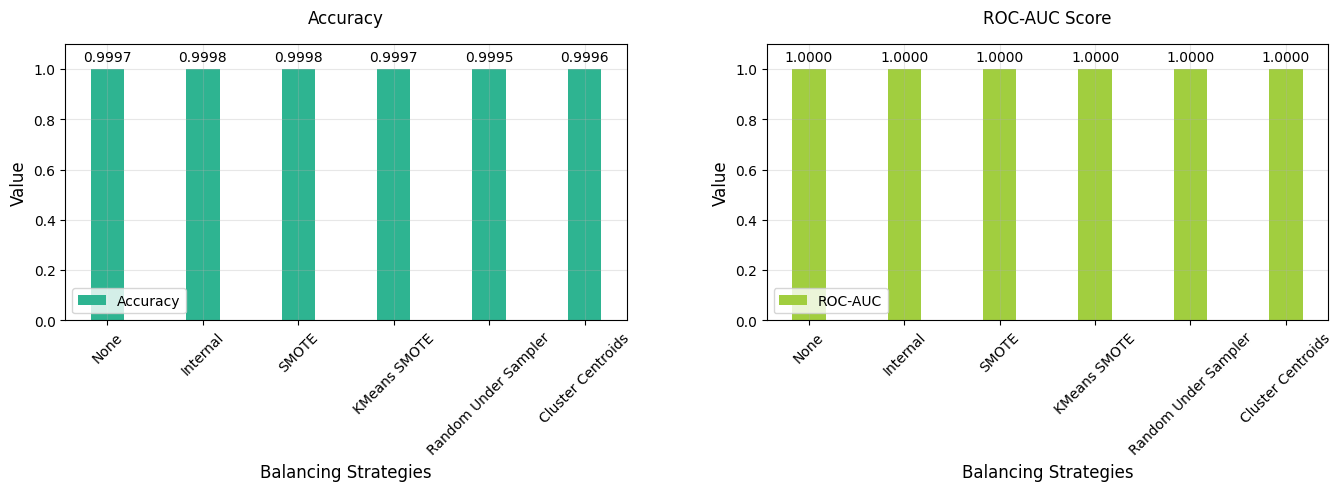

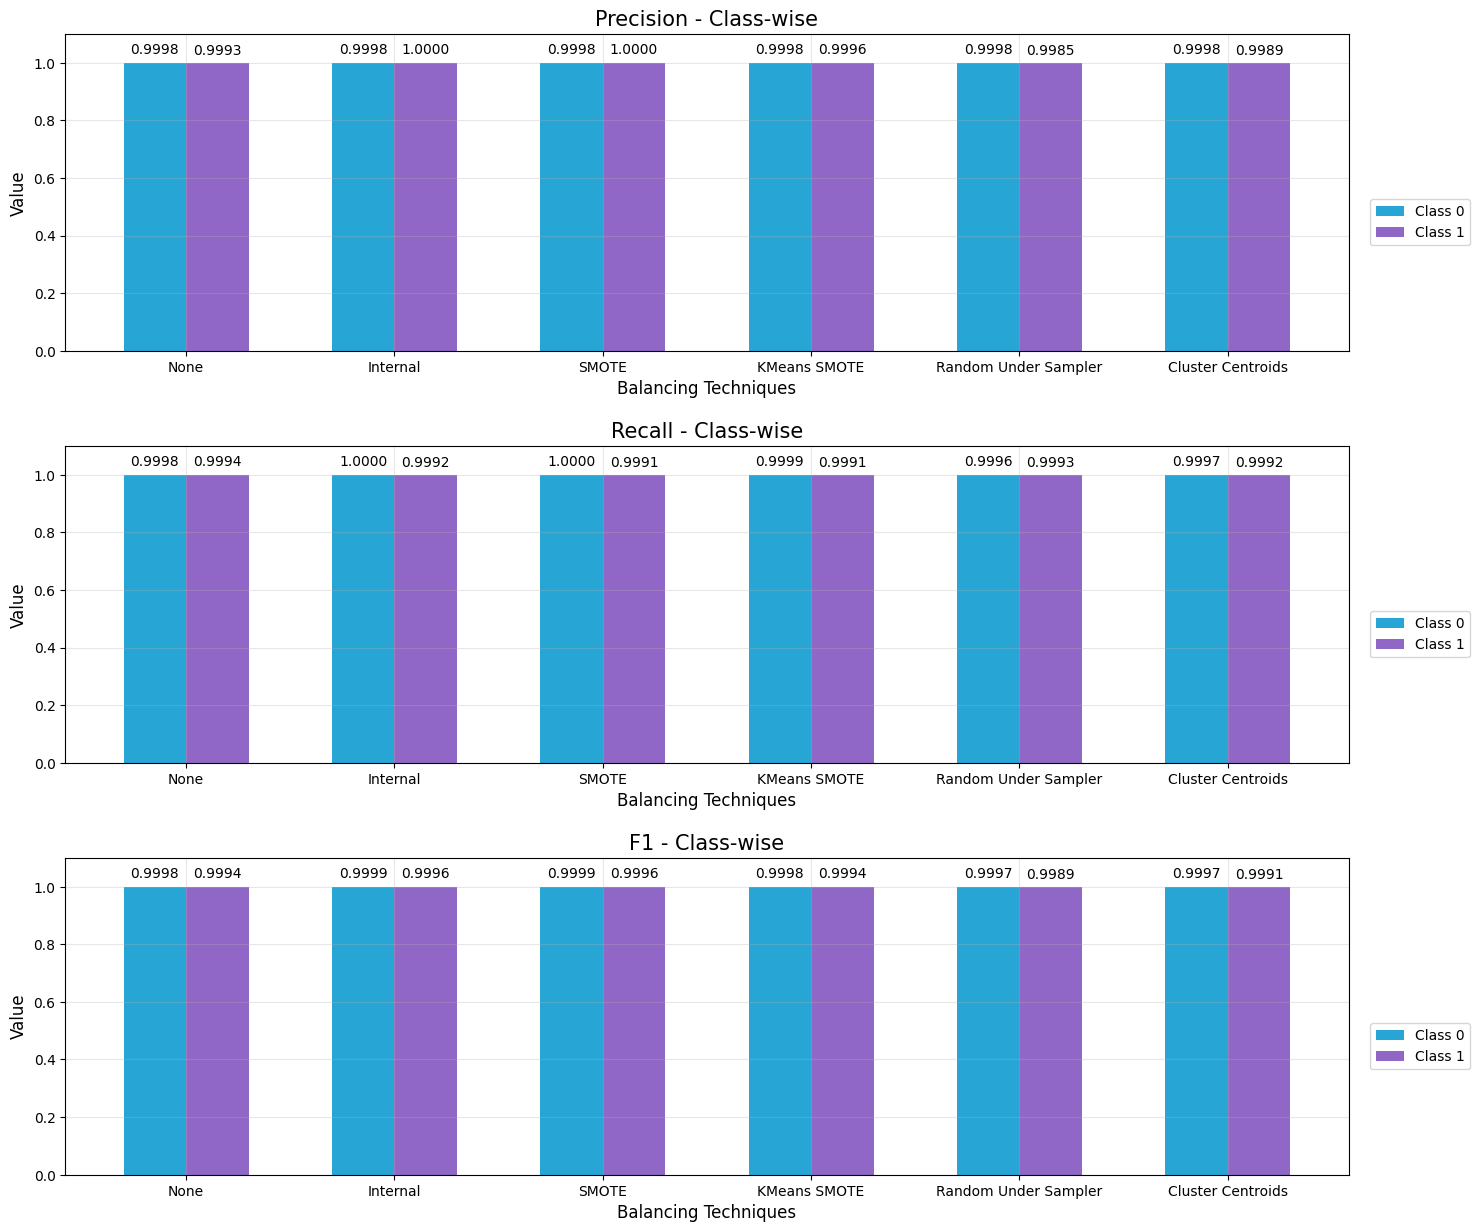

In [404]:
plot_metrics(xgb3, color_map3)

##### XBGoost for dataset including **Galaxy** and **Star**:

In [53]:
xgb_fold4 = kfold('XGBoost', models['BinaryXGBoost'], "None", X4, y4)
xgb_fold_internal4 = kfold('XGBoost', models['BinaryXGBoost'], "Internal", X4, y4, weights = True)
xgb_fold_smote4 = kfold('XGBoost', models['BinaryXGBoost'], "SMOTE", X4, y4, balancing_methods['SMOTE'])
xgb_fold_kmeanssmote4 = kfold('XGBoost', models['BinaryXGBoost'], "KMeans SMOTE", X4, y4, balancing_methods['KMeansSMOTE'])
xgb_fold_rus4 = kfold('XGBoost', models['BinaryXGBoost'], "Random Under Sampler", X4, y4, balancing_methods['RandomUnderSampler'])
xgb_fold_cc4 = kfold('XGBoost', models['BinaryXGBoost'], "Cluster Centroids", X4, y4, balancing_methods['ClusterCentroids'])
xgb4 = pd.concat([xgb_fold4, xgb_fold_internal4, xgb_fold_smote4, xgb_fold_kmeanssmote4, xgb_fold_rus4, xgb_fold_cc4])
xgb4

Model             Balancing  Accuracy   ROC-AUC  Precision Class 0  \
0  XGBoost                  None  0.997622  0.999901           0.998375   
0  XGBoost              Internal  0.997656  0.999901           0.998547   
0  XGBoost                 SMOTE  0.997510  0.999890           0.998623   
0  XGBoost          KMeans SMOTE  0.997376  0.999918           0.998584   
0  XGBoost  Random Under Sampler  0.997656  0.999898           0.998928   
0  XGBoost     Cluster Centroids  0.998035  0.999899           0.998395   

   Precision Class 1  Recall Class 0  Recall Class 1  F1 Class 0  F1 Class 1  
0           0.996568        0.997555        0.997717    0.997964    0.997141  
0           0.996408        0.997440        0.997959    0.997993    0.997182  
0           0.995954        0.997115        0.998066    0.997868    0.997008  
0           0.995686        0.996924        0.998012    0.997753    0.996848  
0           0.995875        0.997058        0.998496    0.997992    0.997184  
0           0.997530        0.998242        0.997744    0.998319    0.997637

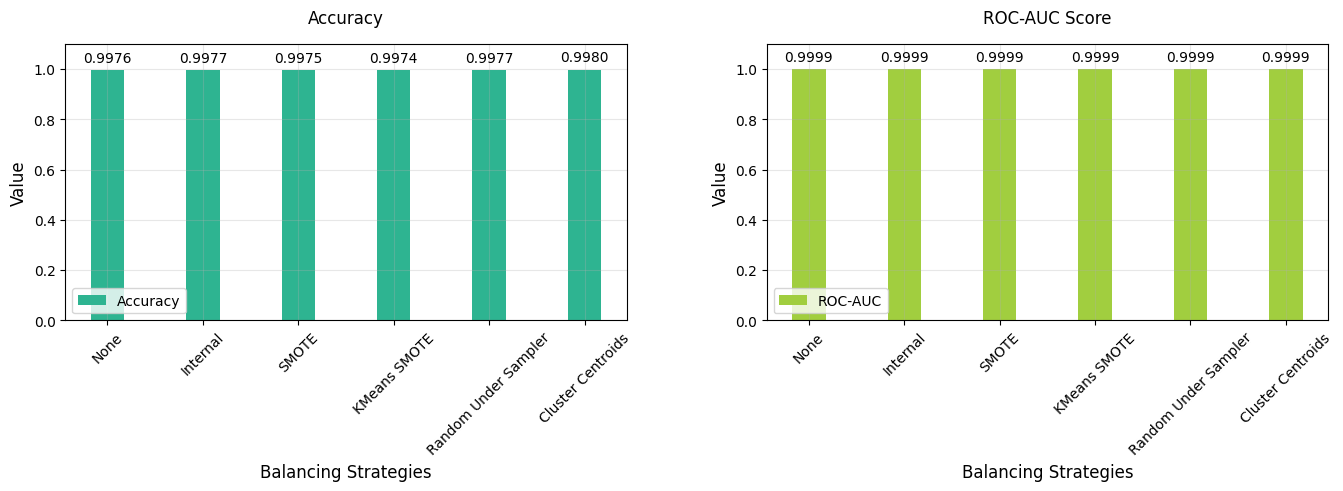

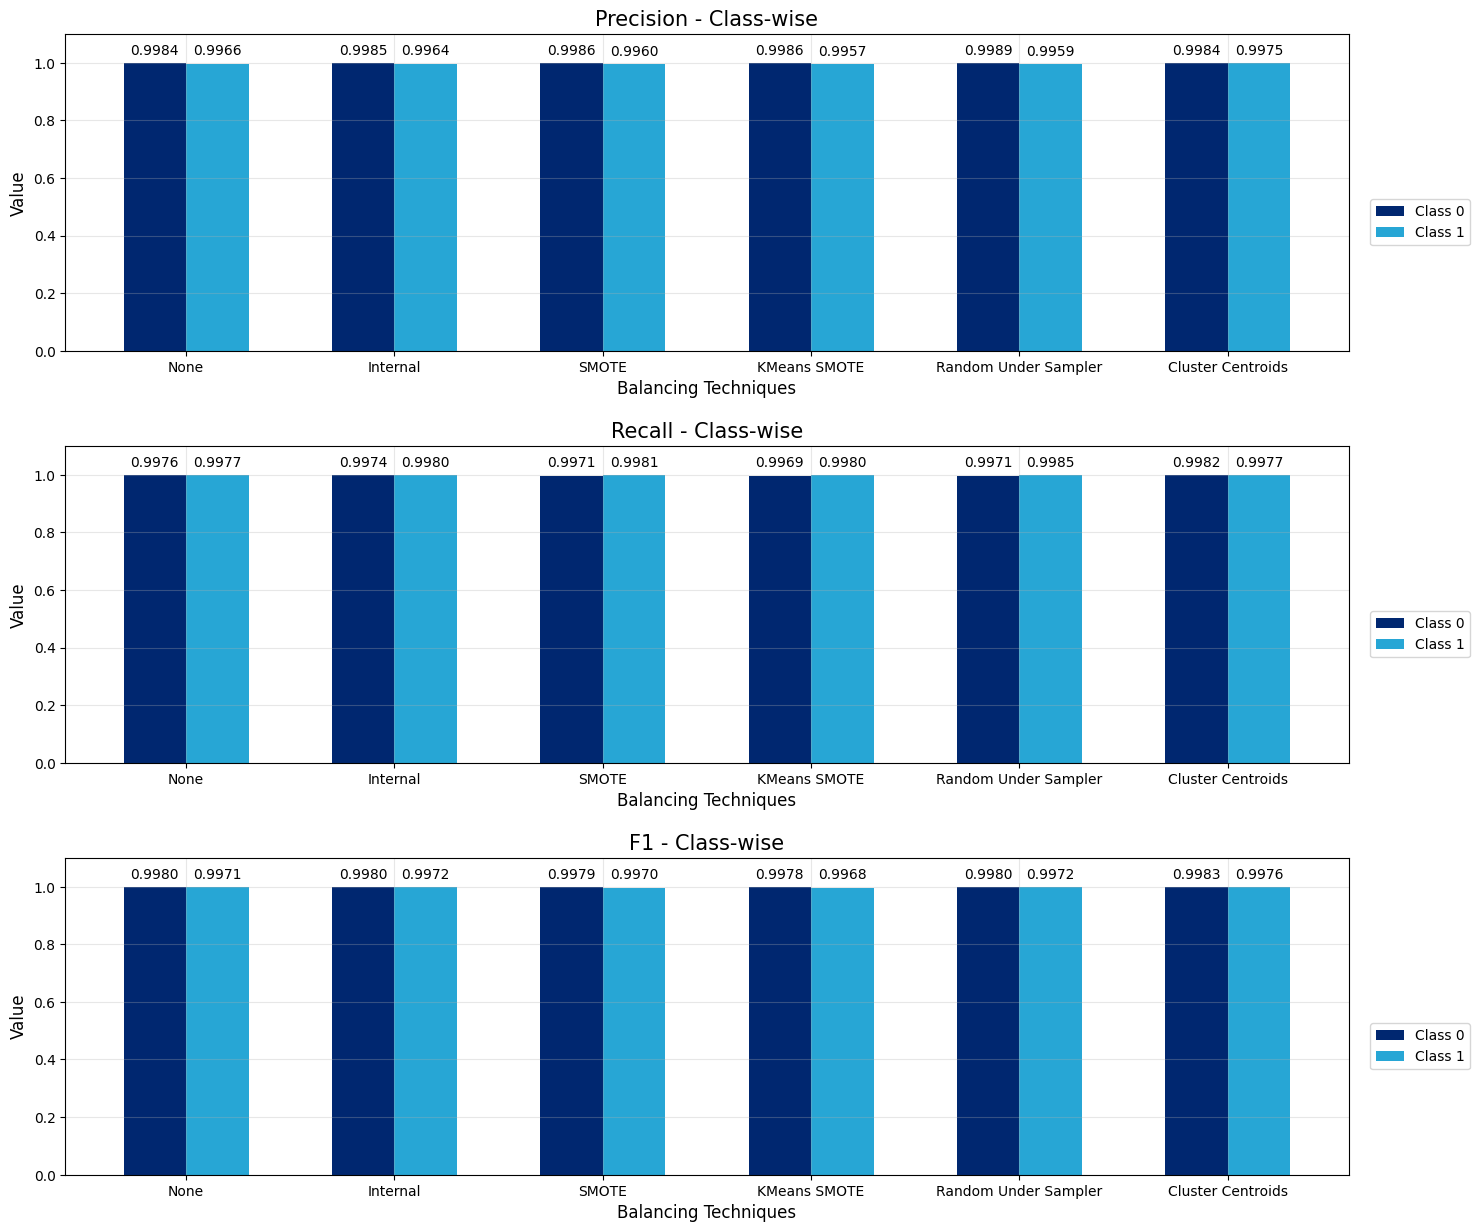

In [406]:
plot_metrics(xgb4, color_map4)